## 0. Importing external modules

In [1]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [2]:
## imports

import numpy as np
import xarray as xr
import GriddedData
import time

In [3]:
#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal

%matplotlib inline

In [4]:
## Dataset

dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
dirin="/media/extra/DATA/NATL60/NATL60-I/"


In [5]:
gridfile=dirin+"NATL60_grid.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


/media/extra/DATA/NATL60/NATL60-I/NATL60_grid.nc


In [6]:
filt_files03="NATL60-CJM165_y2013m03d*.1d_sosstsst_filt-n80-f0.0125.nc"
filt_files09="NATL60-CJM165_y2013m09d*.1d_sosstsst_filt-n80-f0.0125.nc"

tf_files03=dir+filt_files03
tf_files09=dir+filt_files09

!ls $tf_files03
!ls $tf_files09

/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d01.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d02.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d03.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d04.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d05.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d06.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d07.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d08.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d09.1d_sosstsst_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03d10.1d_sosstsst_filt-n80-f0.0125.nc
/media/ext

In [7]:
def fine_scale_variance(files):
    ''' from a list of files containing one month of data compute variance and average in 1°x1°x1 month boxes
    '''
    hpcurl = xr.open_mfdataset(files,concat_dim='time_counter',decode_times=False)['sosstsst_filt']
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    return loncrsm,latcrsm,hpcurl2mcm,hpcurl2m



In [8]:
loncrsm03, latcrsm03, boxvarcurl03, hpvarm03 = fine_scale_variance(tf_files03)

/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [9]:
loncrsm09, latcrsm09, boxvarcurl09, hpvarm09  = fine_scale_variance(tf_files09)

In [10]:
def plot_fine_scale_variance(var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    fig = plt.figure(figsize=(15,11))
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=1,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales sst variance in '+month,fontsize=25)
    plt.savefig('fine_scale_variance_sst_NATL60-CJM165_'+month+'.png')
  

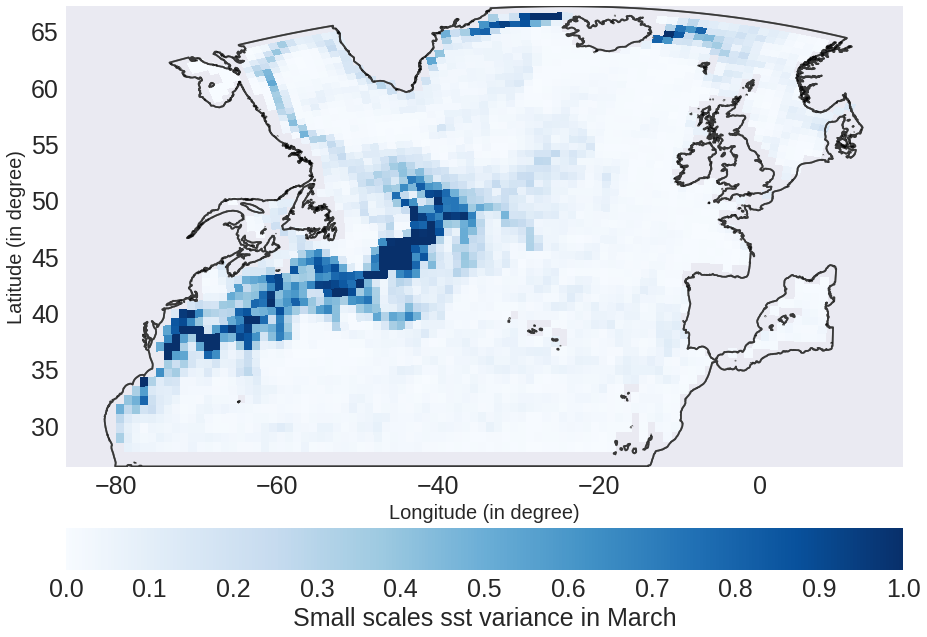

In [11]:
plot_fine_scale_variance(boxvarcurl03,loncrsm03, latcrsm03,navlon,navlat,hpvarm03,'March')

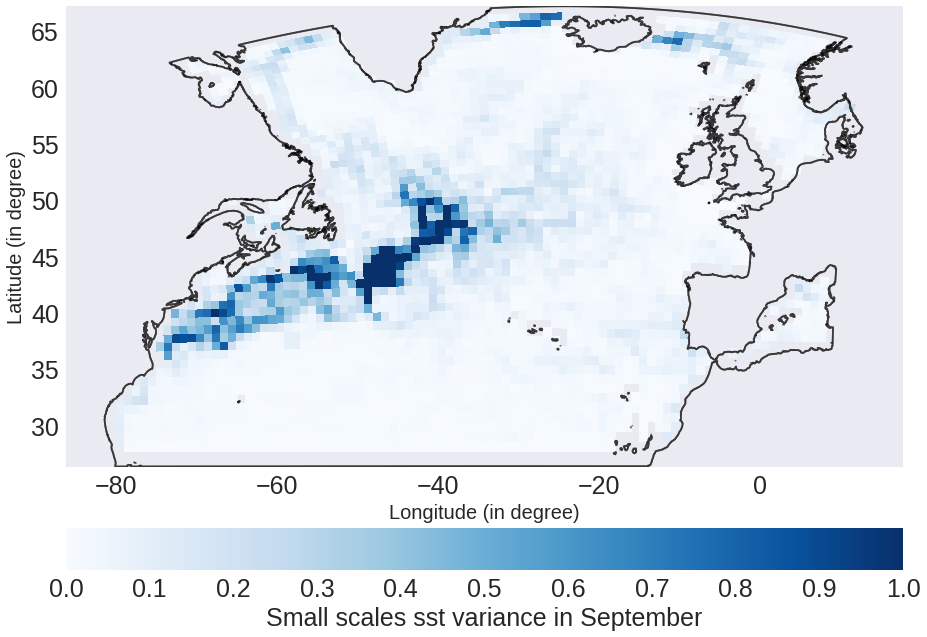

In [12]:
plot_fine_scale_variance(boxvarcurl09,loncrsm09, latcrsm09,navlon,navlat,hpvarm09,'September')

In [11]:
wherehigh03=np.where(boxvarcurl03>2)
wherelow03=np.where(boxvarcurl03<0.0001)

wherehigh09=np.where(boxvarcurl09>1.5)
wherelow09=np.where(boxvarcurl09<0.0015)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [14]:
def one_histo(xbox,ybox,month):

    if month == 3:
        tfiles=tf_files03
        nmonth="March"
        boxvarcurl=boxvarcurl03
    if month == 9:
        tfiles=tf_files09
        nmonth="Sept"
        boxvarcurl=boxvarcurl09

    def all_data_one_box_one_month(files,xbox,ybox):
        ''' from a list of files containing one month of filtered data select a 1°x1 box of data°
        '''
        hpcurl = np.squeeze(xr.open_mfdataset(files)['sosstsst_filt'])
        navlat2=np.array(navlat).squeeze()
        navlon2=np.array(navlon).squeeze()
        mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
        crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
        nday=hpcurl.shape[0]
        latcrs=crs.return_ravel(np.asarray(navlat2))
        loncrs=crs.return_ravel(np.asarray(navlon2))
        latcrsm=np.mean(latcrs,axis=-3)
        loncrsm=np.mean(loncrs,axis=-3)
        xcrs=latcrsm.shape[0]
        ycrs=latcrsm.shape[1]
        hpcurlcm=np.zeros((nday,3600))
        for t in np.arange(0,nday):
            hpcurlc = crs.return_ravel(np.asarray(np.squeeze(hpcurl[t,:,:])))
            hpcurlcm[t,:] = np.squeeze(hpcurlc[:,xbox,ybox]  )
        return hpcurlcm
    
    
    hpcurl=all_data_one_box_one_month(tfiles,xbox,ybox)
    hpstack=np.reshape(hpcurl,(hpcurl.shape[0]*hpcurl.shape[1]))
    
    sns.distplot(hpstack,hist=True,color='b', kde=False)
    plt.title(nmonth+' variance : '+'%.2E' % Decimal(str(boxvarcurl[xbox,ybox]))+' at '+str(np.around(latcrsm03[xbox,ybox],decimals=1))+'degN, '+str(np.around(loncrsm03[xbox,ybox],decimals=1))+'degE')
    

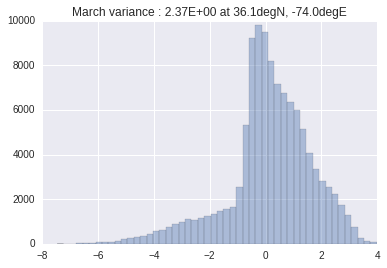

In [15]:
one_histo(wherehigh03[0][0],wherehigh03[1][0],3)

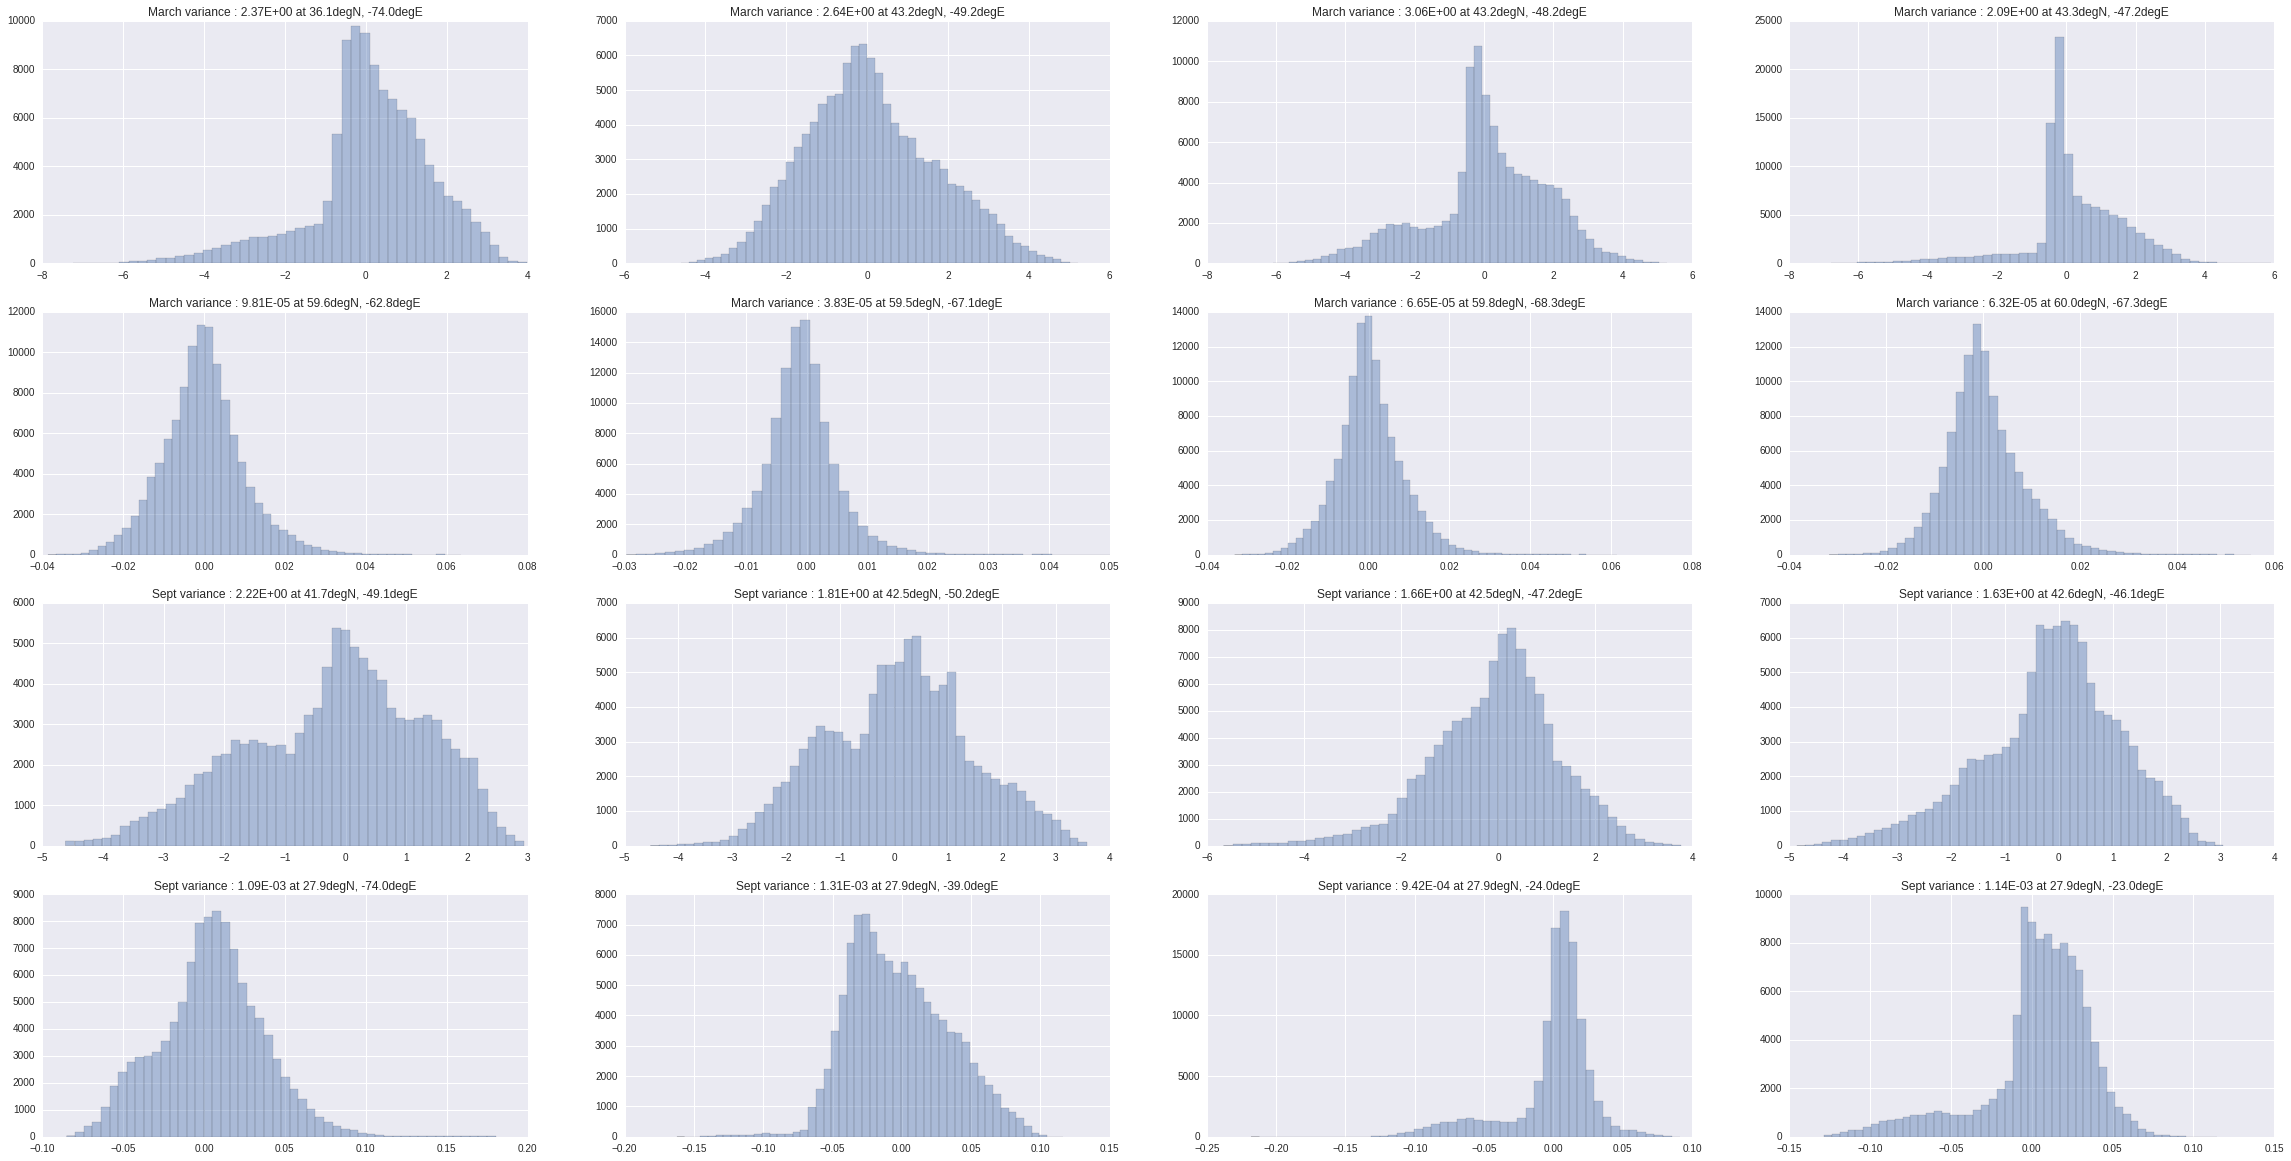

In [16]:
fig = plt.figure(figsize=(40.0, 20.0))
axes1 = fig.add_subplot(4, 4, 1)
one_histo(wherehigh03[0][0],wherehigh03[1][0],3)
axes1 = fig.add_subplot(4, 4, 2)
one_histo(wherehigh03[0][1],wherehigh03[1][1],3)
axes1 = fig.add_subplot(4, 4, 3)
one_histo(wherehigh03[0][2],wherehigh03[1][2],3)
axes1 = fig.add_subplot(4, 4, 4)
one_histo(wherehigh03[0][3],wherehigh03[1][3],3)
axes1 = fig.add_subplot(4, 4, 5)
one_histo(wherelow03[0][0],wherelow03[1][0],3)
axes1 = fig.add_subplot(4, 4, 6)
one_histo(wherelow03[0][1],wherelow03[1][1],3)
axes1 = fig.add_subplot(4, 4, 7)
one_histo(wherelow03[0][2],wherelow03[1][2],3)
axes1 = fig.add_subplot(4, 4, 8)
one_histo(wherelow03[0][3],wherelow03[1][3],3)
axes1 = fig.add_subplot(4, 4, 9)
one_histo(wherehigh09[0][0],wherehigh09[1][0],9)
axes1 = fig.add_subplot(4, 4, 10)
one_histo(wherehigh09[0][1],wherehigh09[1][1],9)
axes1 = fig.add_subplot(4, 4, 11)
one_histo(wherehigh09[0][2],wherehigh09[1][2],9)
axes1 = fig.add_subplot(4, 4, 12)
one_histo(wherehigh09[0][3],wherehigh09[1][3],9)
axes1 = fig.add_subplot(4, 4, 13)
one_histo(wherelow09[0][0],wherelow09[1][0],9)
axes1 = fig.add_subplot(4, 4, 14)
one_histo(wherelow09[0][1],wherelow09[1][1],9)
axes1 = fig.add_subplot(4, 4, 15)
one_histo(wherelow09[0][2],wherelow09[1][2],9)
axes1 = fig.add_subplot(4, 4, 16)
one_histo(wherelow09[0][3],wherelow09[1][3],9)
plt.savefig('hist_box.png')

In [17]:
def histo_low_high_variance(latlow,lonlow,lathigh,lonhigh):
            
    wherelow = np.where( ((loncrsm03 - lonlow)**2 + (latcrsm03-latlow)**2) < 1)
    
    if np.size(wherelow[0]) == 1:
        if np.isnan(boxvarcurl03[wherelow[0],wherelow[1]]) == False:
            xboxlow=wherelow[0]
            yboxlow=wherelow[1]
        else:
            sys.exit("On the land")
    else:
        t=0
        while np.isnan(boxvarcurl03[wherelow[0][t],wherelow[1][t]]) == True and t < np.size(wherelow[0]):
            t=t+1
            
        if np.isnan(boxvarcurl03[wherelow[0][t],wherelow[1][t]]) == False:
            xboxlow=wherelow[0][t]
            yboxlow=wherelow[1][t]
        else:
            sys.exit("On the land")
            
    
    print 'xboxlow = '+str(xboxlow)+', yboxlow = '+str(yboxlow)

    wherehigh = np.where( ((loncrsm03 - lonhigh)**2 + (latcrsm03-lathigh)**2) < 1)
    
    if np.size(wherehigh[0]) == 1:
        if np.isnan(boxvarcurl03[wherehigh[0],wherehigh[1]]) == False:
            xboxhigh=wherehigh[0]
            yboxhigh=wherehigh[1]
        else:
            sys.exit("On the land")
    else:
        t=0
        while np.isnan(boxvarcurl03[wherehigh[0][t],wherehigh[1][t]]) == True and t < np.size(wherehigh[0]):
            t=t+1
            
        if np.isnan(boxvarcurl03[wherehigh[0][t],wherehigh[1][t]]) == False:
            xboxhigh=wherehigh[0][t]
            yboxhigh=wherehigh[1][t]
        else:
            sys.exit("On the land")
             
        
    print 'xboxhigh = '+str(xboxhigh)+', yboxhigh = '+str(yboxhigh)
    

    def all_data_one_box_one_month(files,xbox,ybox):
        ''' from a list of files containing one month of filtered data select a 1°x1 box of data°
        '''
        hpcurl = np.squeeze(xr.open_mfdataset(files)['sosstsst_filt'])
        navlat2=np.array(navlat).squeeze()
        navlon2=np.array(navlon).squeeze()
        mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
        crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
        nday=hpcurl.shape[0]
        latcrs=crs.return_ravel(np.asarray(navlat2))
        loncrs=crs.return_ravel(np.asarray(navlon2))
        latcrsm=np.mean(latcrs,axis=-3)
        loncrsm=np.mean(loncrs,axis=-3)
        xcrs=latcrsm.shape[0]
        ycrs=latcrsm.shape[1]
        hpcurlcm=np.zeros((nday,3600))
        for t in np.arange(0,nday):
            hpcurlc = crs.return_ravel(np.asarray(np.squeeze(hpcurl[t,:,:])))
            hpcurlcm[t,:] = np.squeeze(hpcurlc[:,xbox,ybox]  )
        return hpcurlcm
    
    
    hpcurlhigh03=all_data_one_box_one_month(tf_files03,xboxhigh,yboxhigh)
    hpcurllow03 =all_data_one_box_one_month(tf_files03,xboxlow,yboxlow)
    hpcurlhigh09=all_data_one_box_one_month(tf_files09,xboxhigh,yboxhigh)
    hpcurllow09 =all_data_one_box_one_month(tf_files09,xboxlow,yboxlow)
    
    hpstackhigh03=np.reshape(hpcurlhigh03,(hpcurlhigh03.shape[0]*hpcurlhigh03.shape[1]))
    hpstacklow03=np.reshape(hpcurllow03,(hpcurllow03.shape[0]*hpcurllow03.shape[1]))
    hpstackhigh09=np.reshape(hpcurlhigh09,(hpcurlhigh09.shape[0]*hpcurlhigh09.shape[1]))
    hpstacklow09=np.reshape(hpcurllow09,(hpcurllow09.shape[0]*hpcurllow09.shape[1]))
    
    fig = plt.figure(figsize=(20.0, 10.0))
    axes1 = fig.add_subplot(2, 2, 1)
    sns.distplot(hpstacklow03,hist=True,color='b', kde=False)
    plt.title('March Low variance box : '+'%.2E' % Decimal(str(boxvarcurl03[xboxlow,yboxlow]))+' at '+str(np.around(latcrsm03[xboxlow,yboxlow],decimals=1))+'degN, '+str(np.around(loncrsm03[xboxlow,yboxlow],decimals=1))+'degE')
 
    axes1 = fig.add_subplot(2, 2, 2)
    sns.distplot(hpstackhigh03,hist=True,color='r', kde=False)
    plt.title('March High variance box : '+'%.2E' % Decimal(str(boxvarcurl03[xboxhigh,yboxhigh]))+' at '+str(np.around(latcrsm03[xboxhigh,yboxhigh],decimals=1))+'degN, '+str(np.around(loncrsm03[xboxhigh,yboxhigh],decimals=1))+'degE')

    axes3 = fig.add_subplot(2, 2, 3)
    sns.distplot(hpstacklow09,hist=True,color='b', kde=False)
    plt.title('Sept Low variance box : '+'%.2E' % Decimal(str(boxvarcurl09[xboxlow,yboxlow]))+' at '+str(np.around(latcrsm03[xboxlow,yboxlow],decimals=1))+'degN, '+str(np.around(loncrsm03[xboxlow,yboxlow],decimals=1))+'degE')
    
    axes4 = fig.add_subplot(2, 2, 4)
    sns.distplot(hpstackhigh09,hist=True,color='r', kde=False)
    plt.title('Sept High variance box : '+'%.2E' % Decimal(str(boxvarcurl09[xboxhigh,yboxhigh]))+' at '+str(np.around(latcrsm03[xboxhigh,yboxhigh],decimals=1))+'degN, '+str(np.around(loncrsm03[xboxhigh,yboxhigh],decimals=1))+'degE')


xboxlow = 54, yboxlow = 16
xboxhigh = 20, yboxhigh = 34


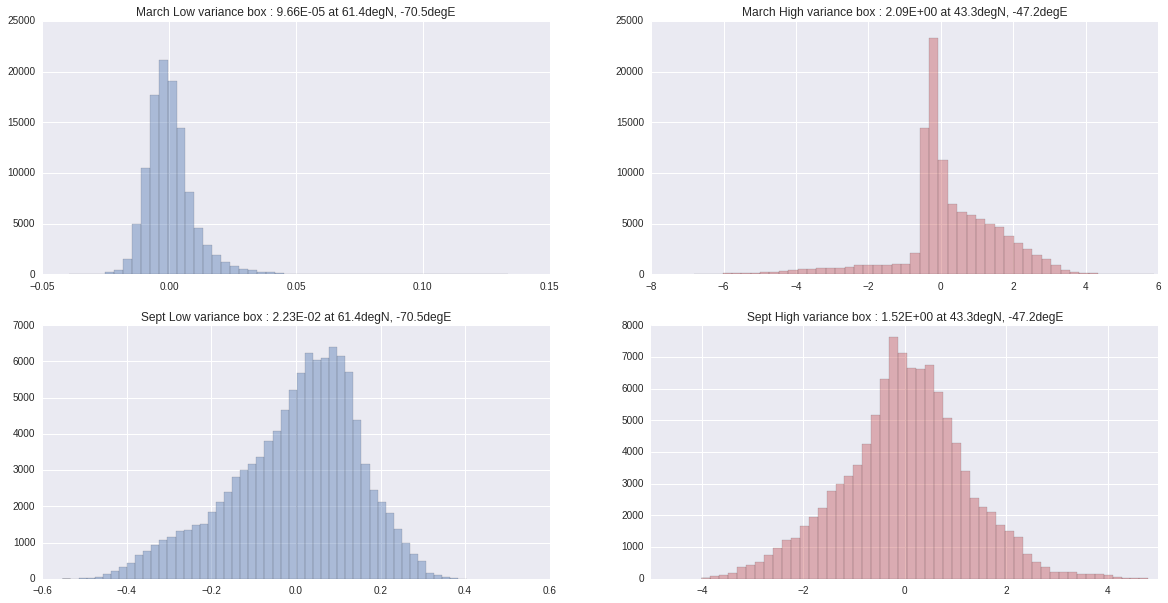

In [18]:
histo_low_high_variance(62,-71,44,-47)

xboxlow = 3, yboxlow = 41
xboxhigh = 21, yboxhigh = 41


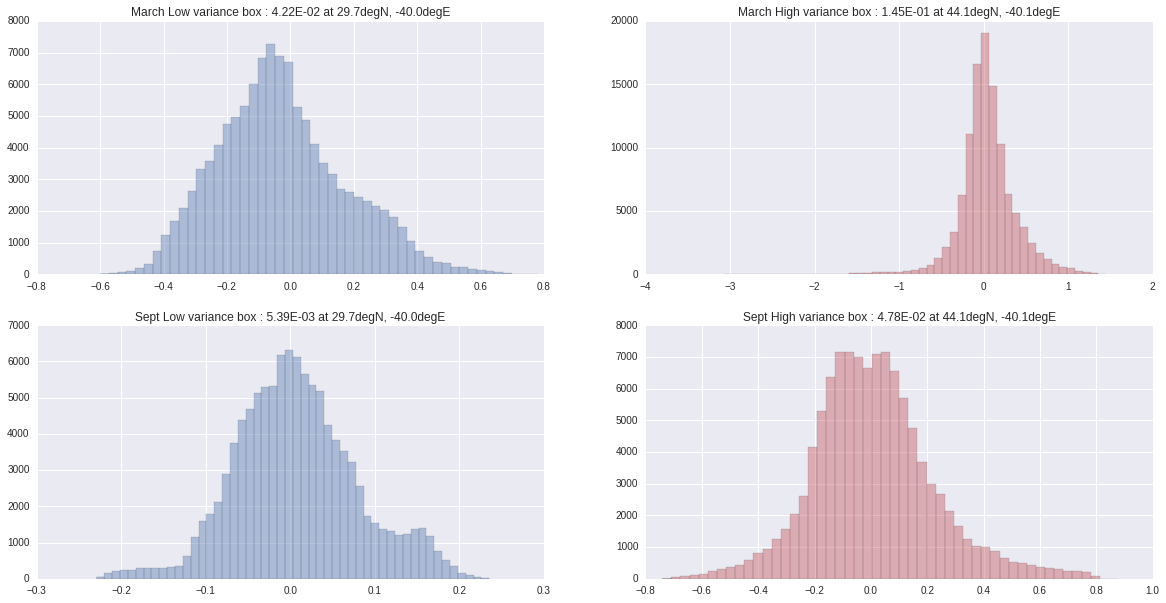

In [19]:
histo_low_high_variance(30,-40,45,-40)

In [23]:
def one_histo_and_snapshot(nbox,xbox,ybox,month,day):

    if month == 3:
        tfiles=tf_files03
        nmonth="March"
        boxvarcurl=boxvarcurl03
    if month == 9:
        tfiles=tf_files09
        nmonth="Sept"
        boxvarcurl=boxvarcurl09

    hpcurl = np.squeeze(xr.open_mfdataset(tfiles)['sosstsst_filt'])
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    nday=hpcurl.shape[0]
    latcrs=crs.return_deep_ravel(np.asarray(navlat2))
    loncrs=crs.return_deep_ravel(np.asarray(navlon2))
    latsnap=latcrs[xbox*90+ybox,:,:]
    lonsnap=loncrs[xbox*90+ybox,:,:]
    t=day
    hpcurlc = crs.return_deep_ravel(np.asarray(np.squeeze(hpcurl[t,:,:])))
    hpcurlsnap=hpcurlc[xbox*90+ybox,:,:]

    def all_data_one_box_one_month(files,xbox,ybox):
        ''' from a list of files containing one month of filtered data select a 1°x1 box of data°
        '''
        hpcurl = np.squeeze(xr.open_mfdataset(files)['sosstsst_filt'])
        navlat2=np.array(navlat).squeeze()
        navlon2=np.array(navlon).squeeze()
        mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
        crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
        nday=hpcurl.shape[0]
        latcrs=crs.return_ravel(np.asarray(navlat2))
        loncrs=crs.return_ravel(np.asarray(navlon2))
        latcrsm=np.mean(latcrs,axis=-3)
        loncrsm=np.mean(loncrs,axis=-3)
        xcrs=latcrsm.shape[0]
        ycrs=latcrsm.shape[1]
        hpcurlcm=np.zeros((nday,3600))
        for t in np.arange(0,nday):
            hpcurlc = crs.return_ravel(np.asarray(np.squeeze(hpcurl[t,:,:])))
            hpcurlcm[t,:] = np.squeeze(hpcurlc[:,xbox,ybox]  )
        return hpcurlcm
    
    
    hpcurl=all_data_one_box_one_month(tfiles,xbox,ybox)
    hpstack=np.reshape(hpcurl,(hpcurl.shape[0]*hpcurl.shape[1]))
    
    fig = plt.figure(figsize=(20.0, 7.0))
    axes1 = fig.add_subplot(1, 2, 1)

    sns.distplot(hpstack,hist=True,color='b', kde=False)
    plt.title(nmonth+' variance : '+'%.2E' % Decimal(str(boxvarcurl[xbox,ybox]))+' at '+str(np.around(latcrsm03[xbox,ybox],decimals=1))+'degN, '+str(np.around(loncrsm03[xbox,ybox],decimals=1))+'degE')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.autoscale(tight=True)

    pcolor = ax.pcolormesh(lonsnap,latsnap,ma.masked_invalid(hpcurlsnap),cmap=seq_cmap,vmin=np.min(hpstack),vmax=np.max(hpstack),alpha=1)
    ax.tick_params(labelsize=10)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    ax.set_xlabel('Longitude (in degree)',fontsize=10)
    ax.set_ylabel('Latitude (in degree)',fontsize=10)
    cbar.set_label(' variance : '+'%.2E' % Decimal(str(np.mean(np.mean(hpcurlsnap))))+' in day '+str(day+1)+' of '+nmonth,fontsize=10)
    plt.savefig('/media/extra/DATA/NATL60/NATL60-CJM165-PLOTS/pdf_snapshot/pdf_snapshot_'+nbox+'_day'+str(day+1)+'.png')

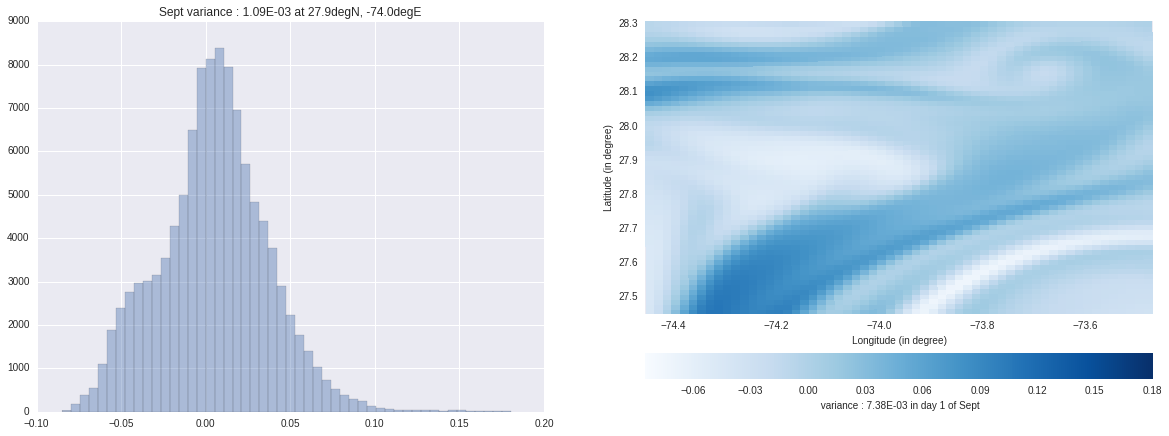

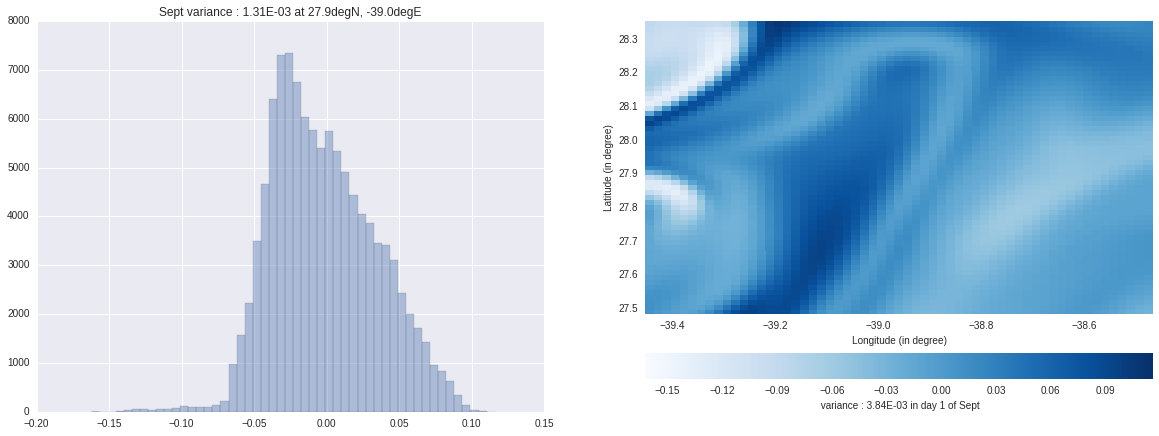

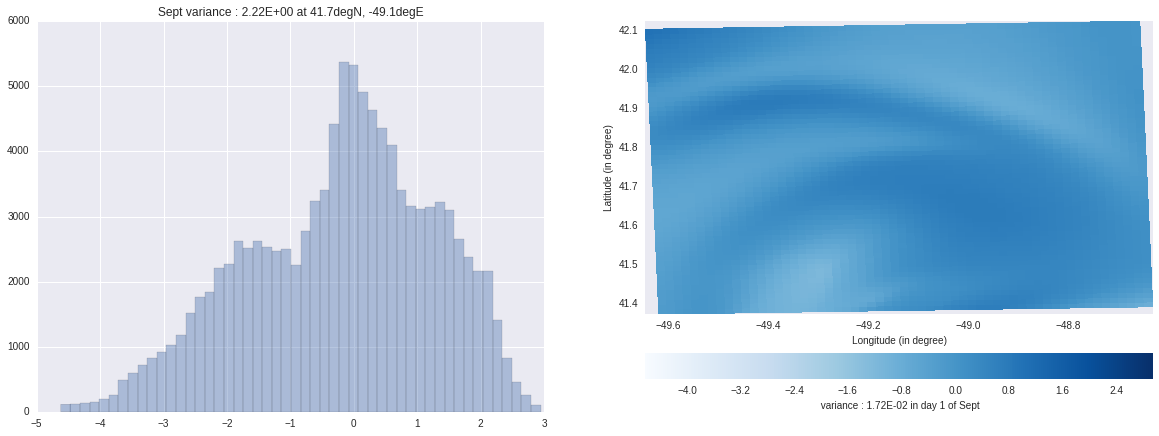

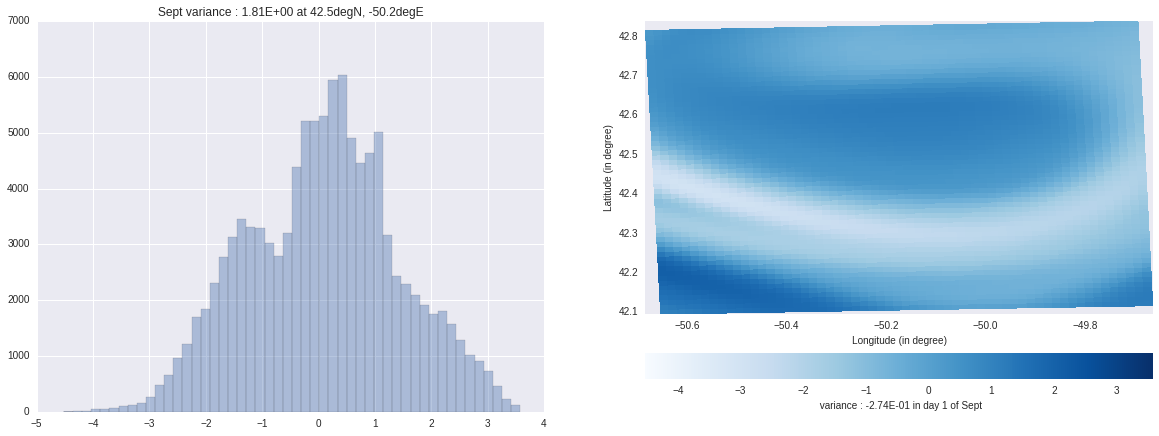

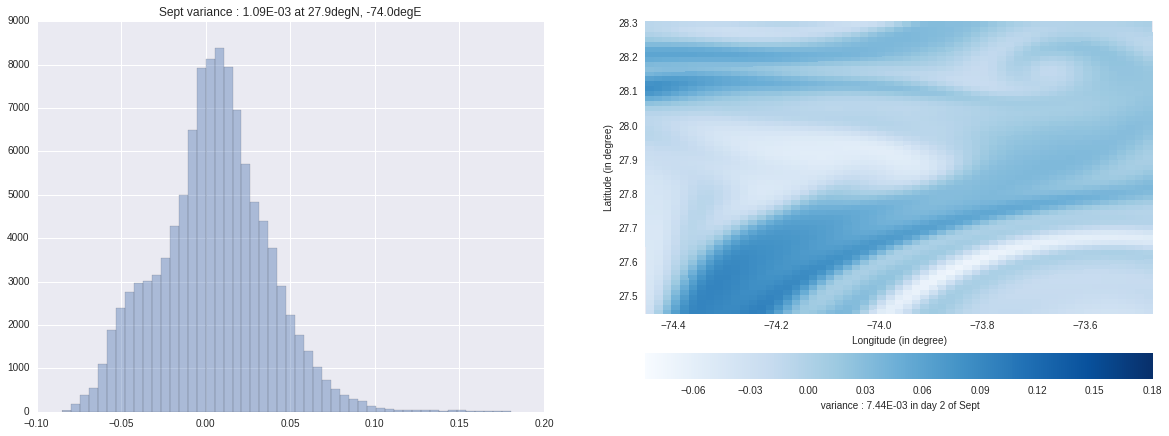

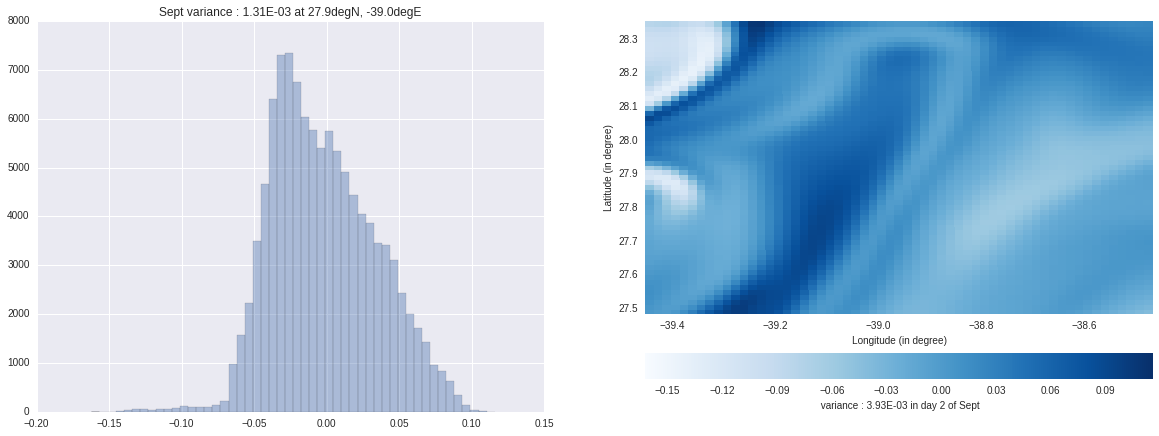

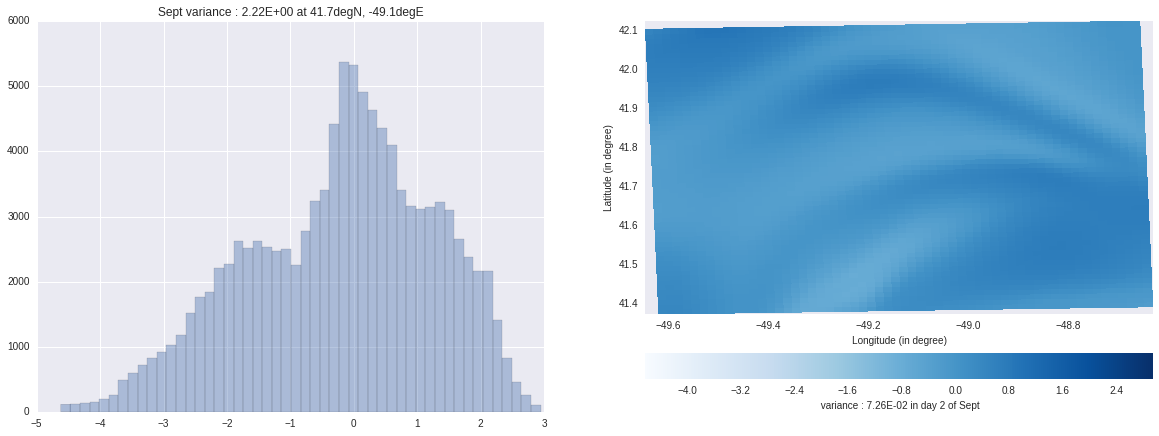

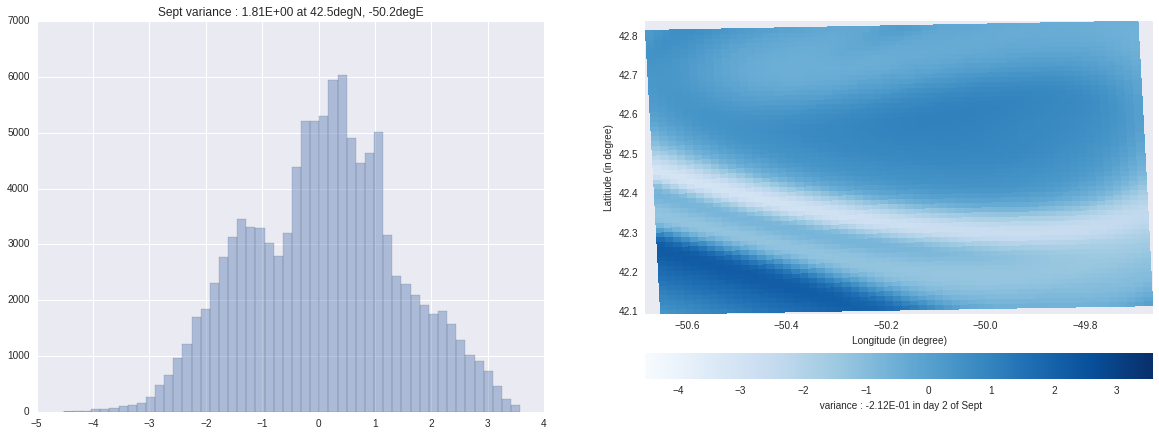

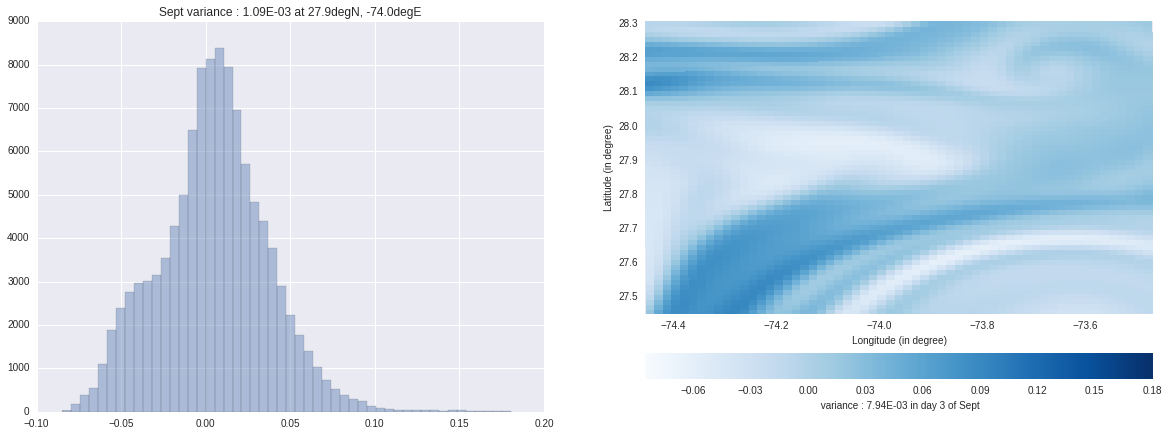

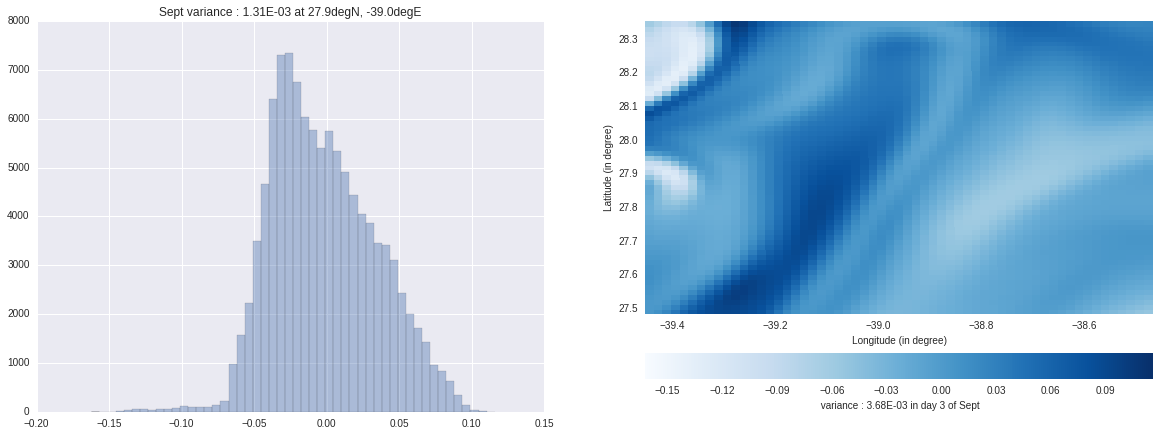

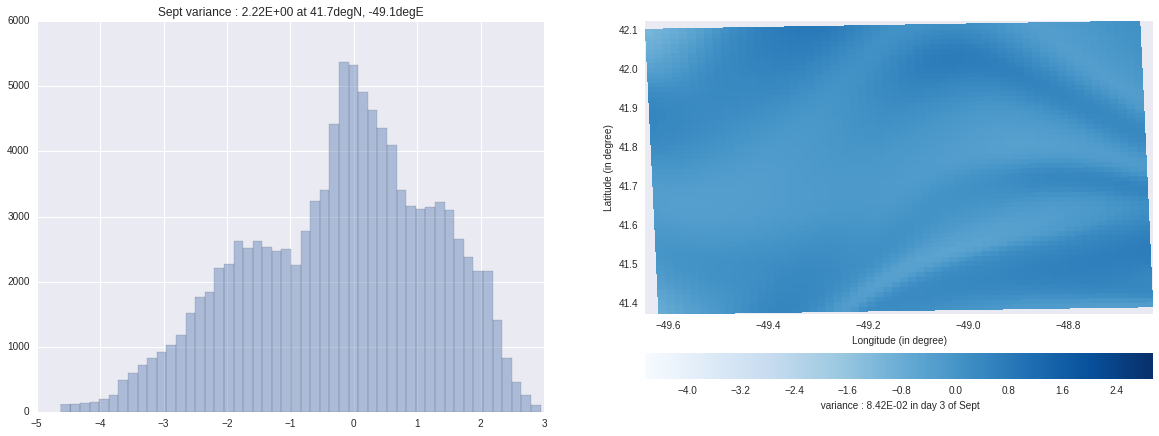

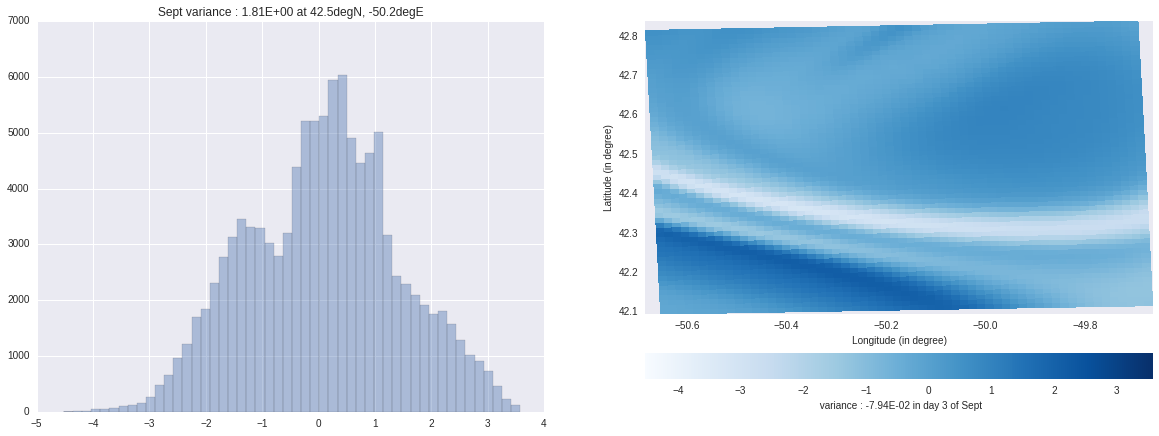

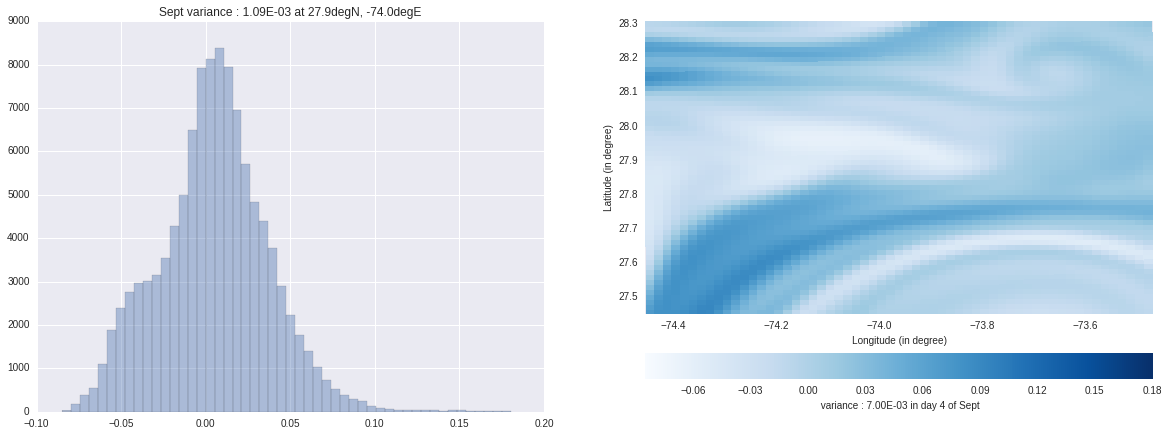

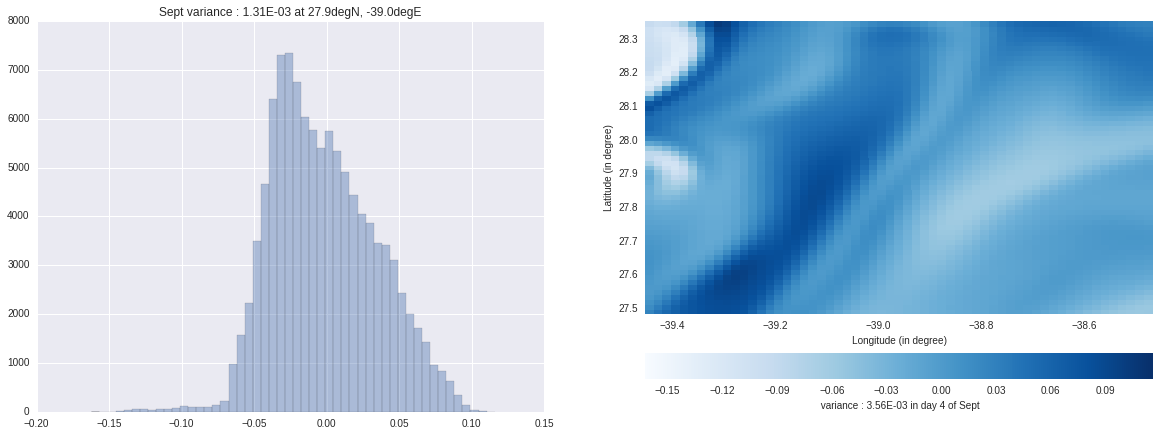

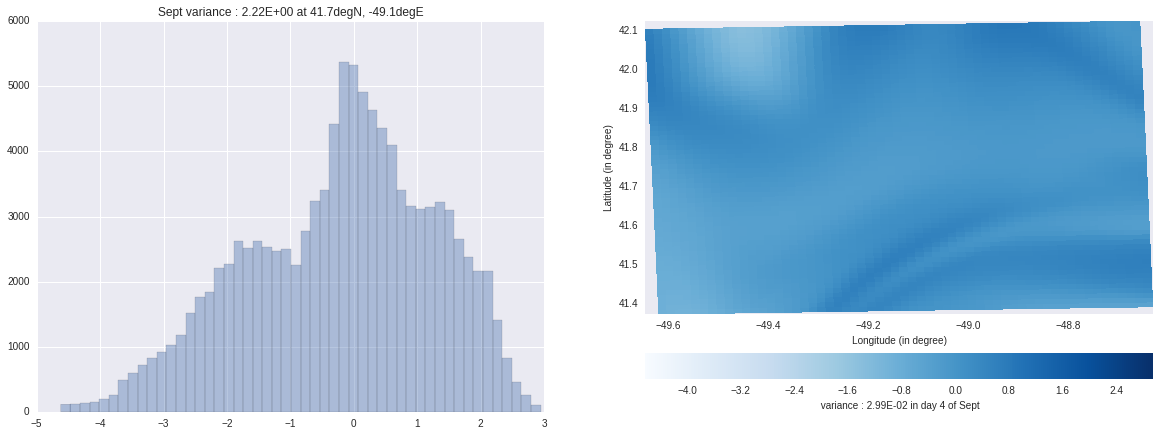

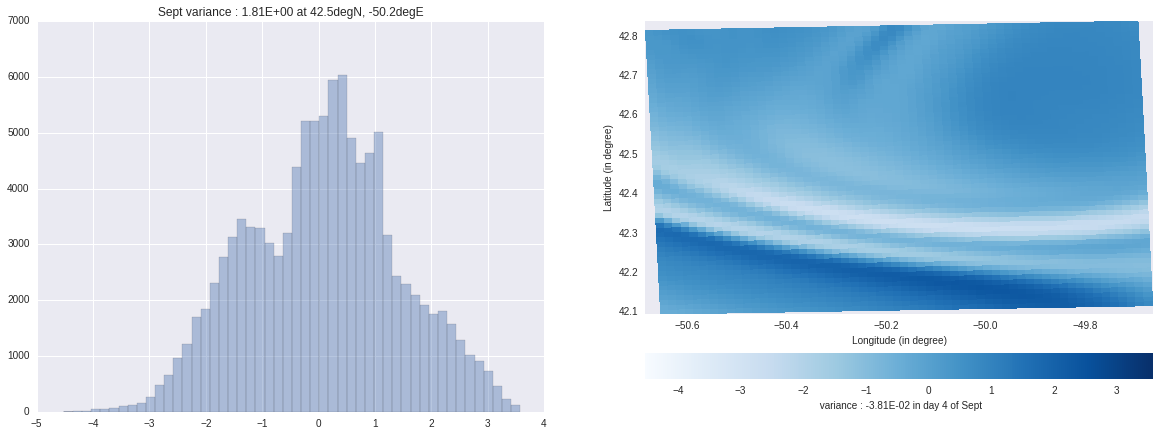

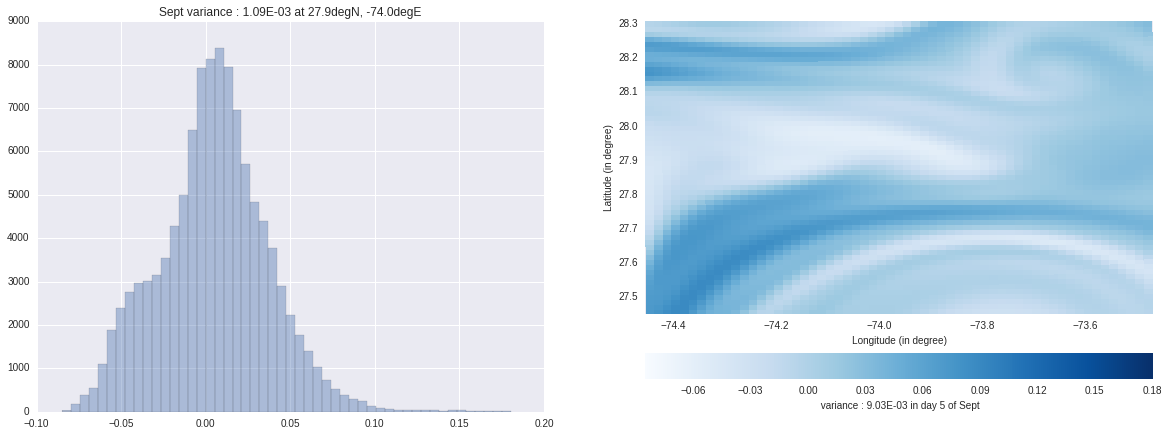

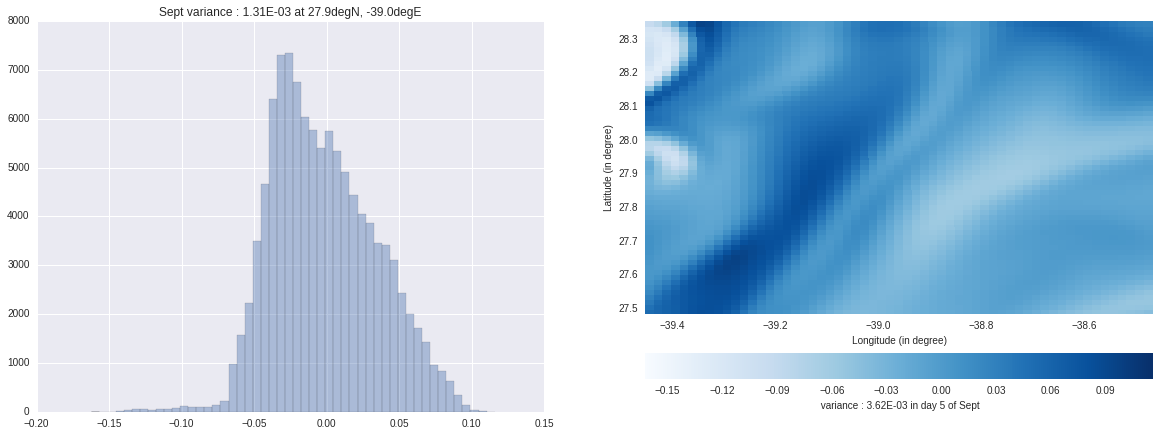

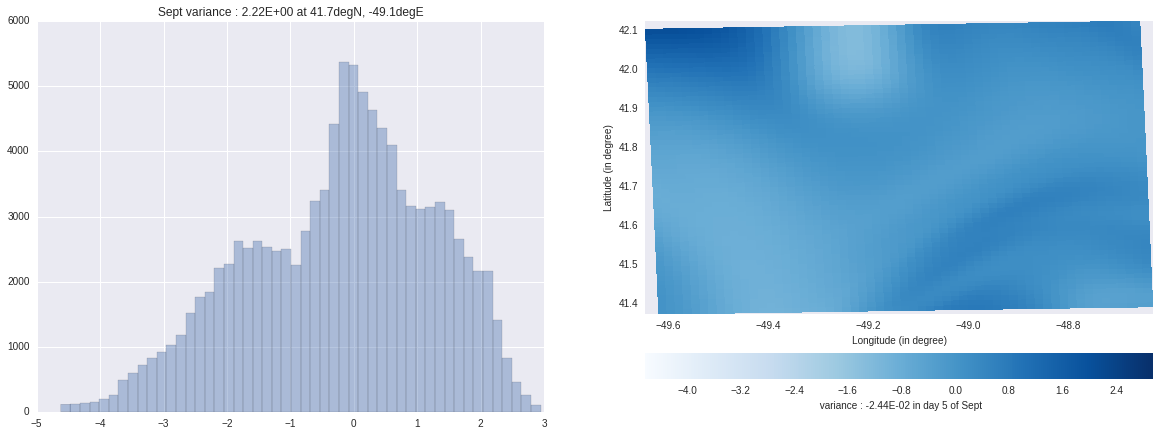

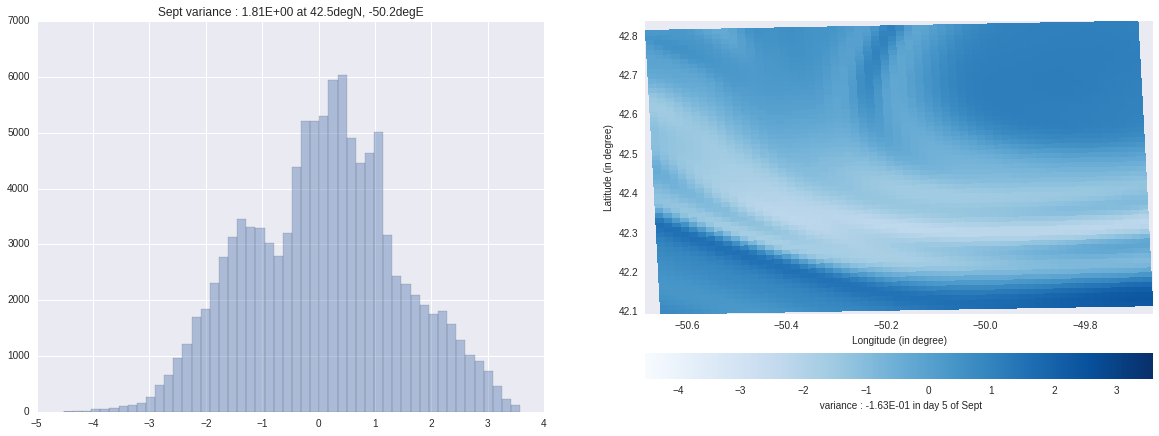

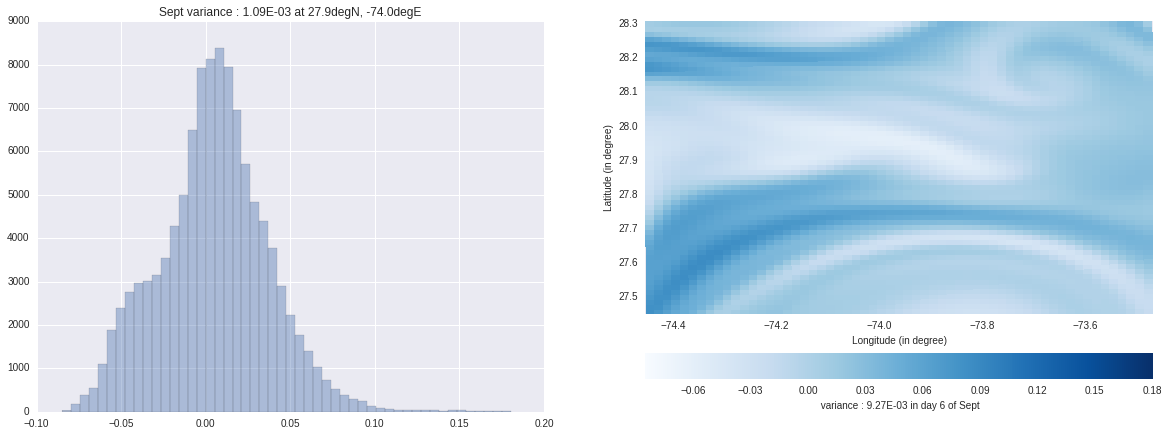

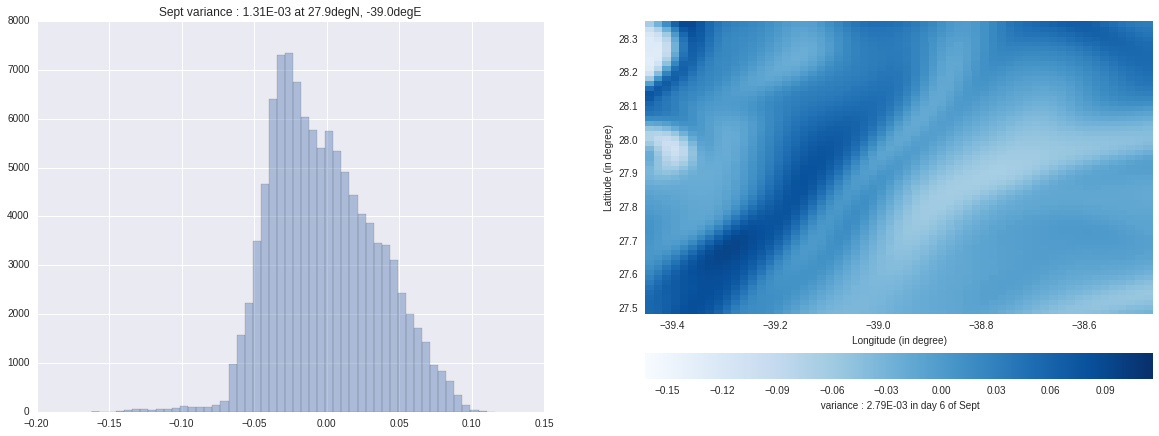

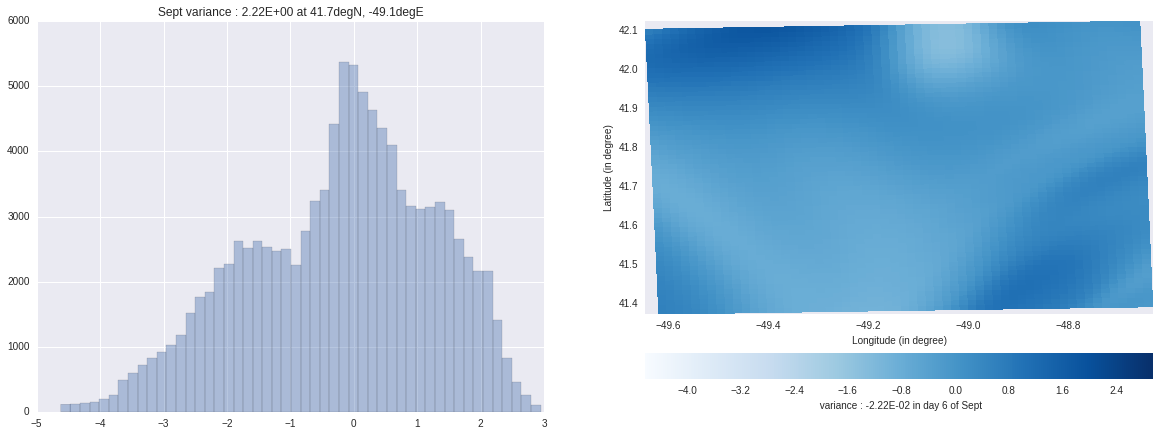

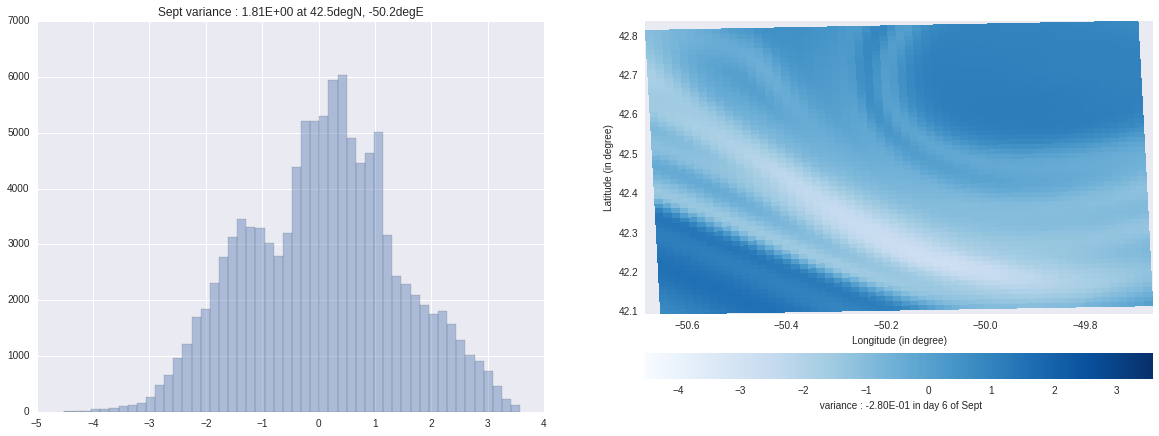

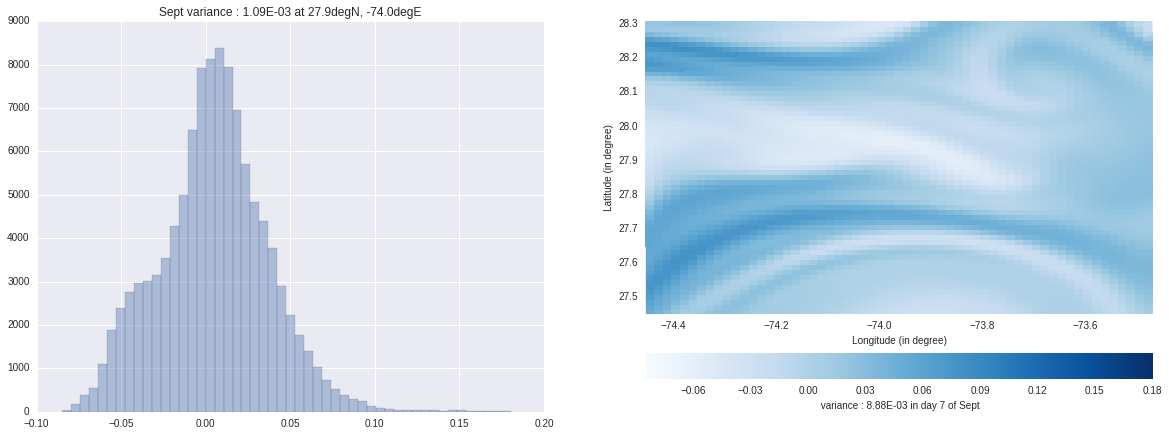

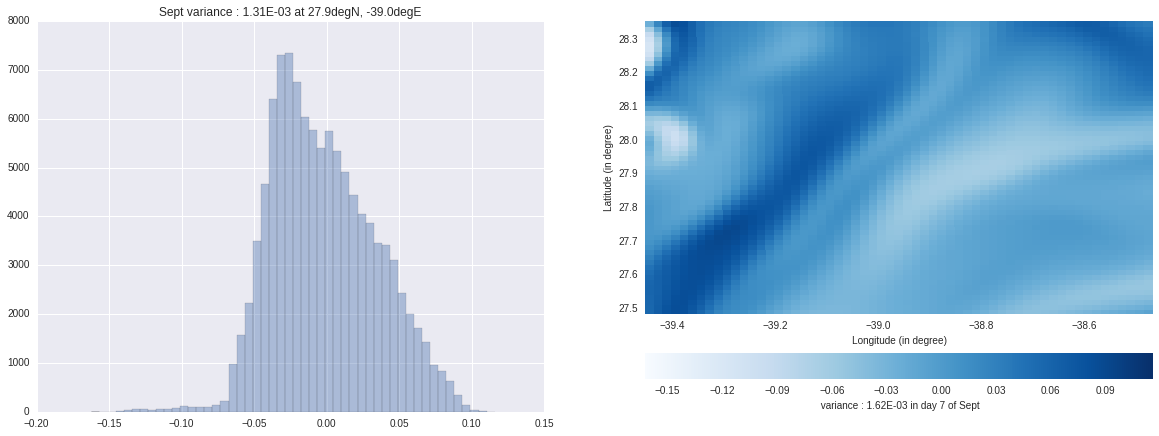

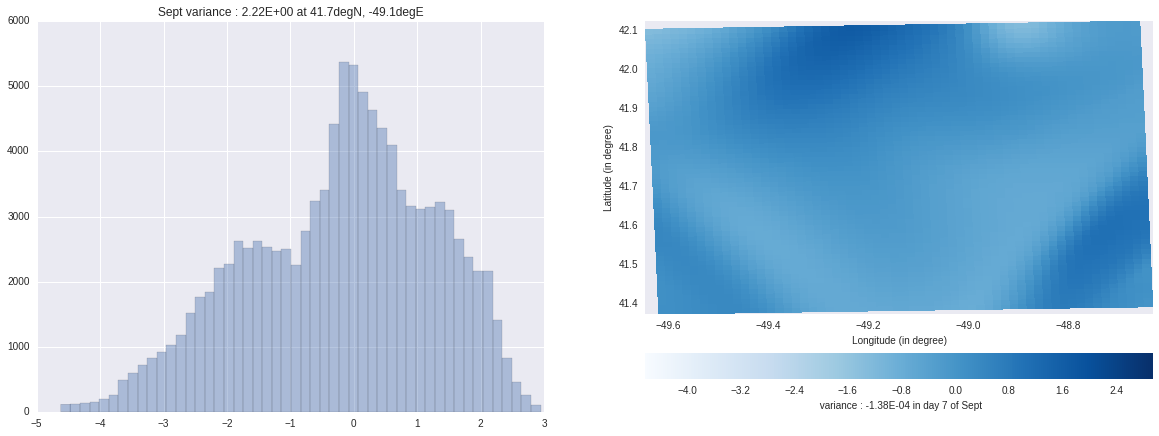

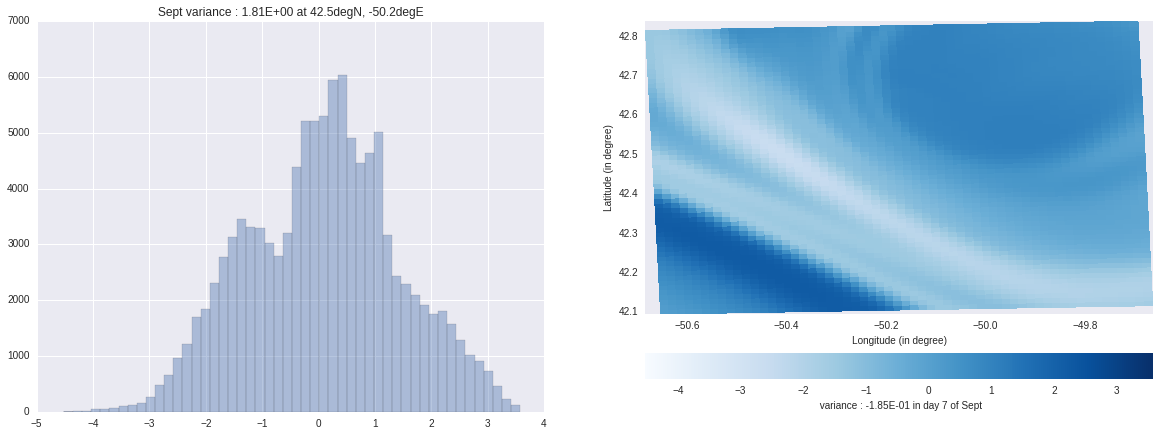

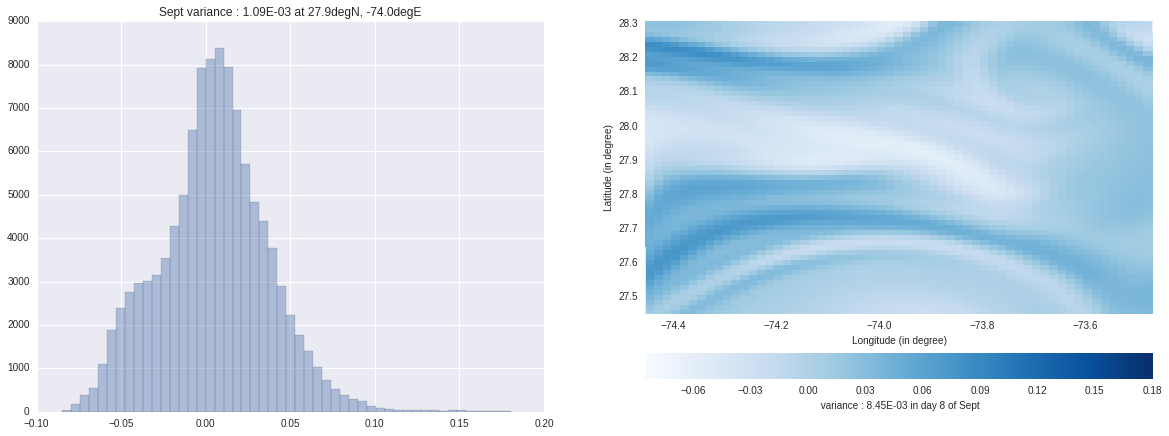

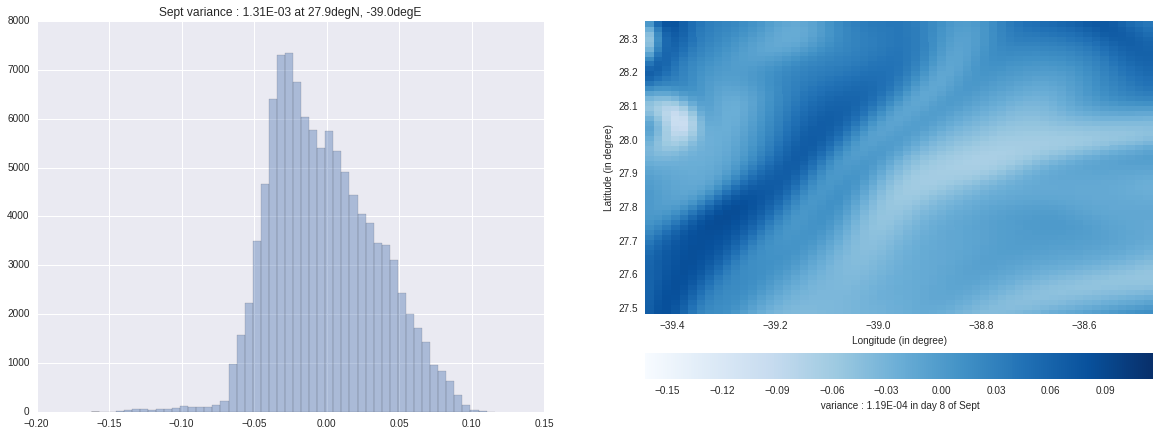

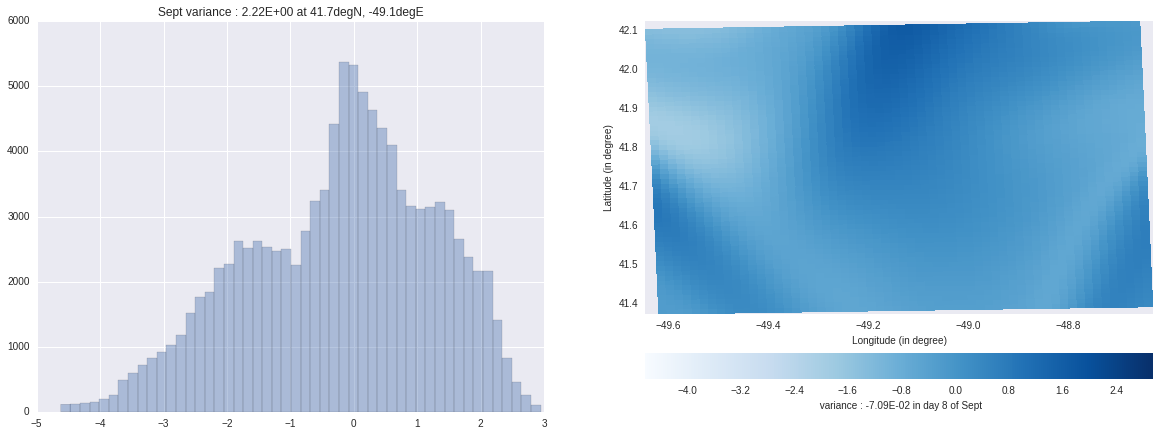

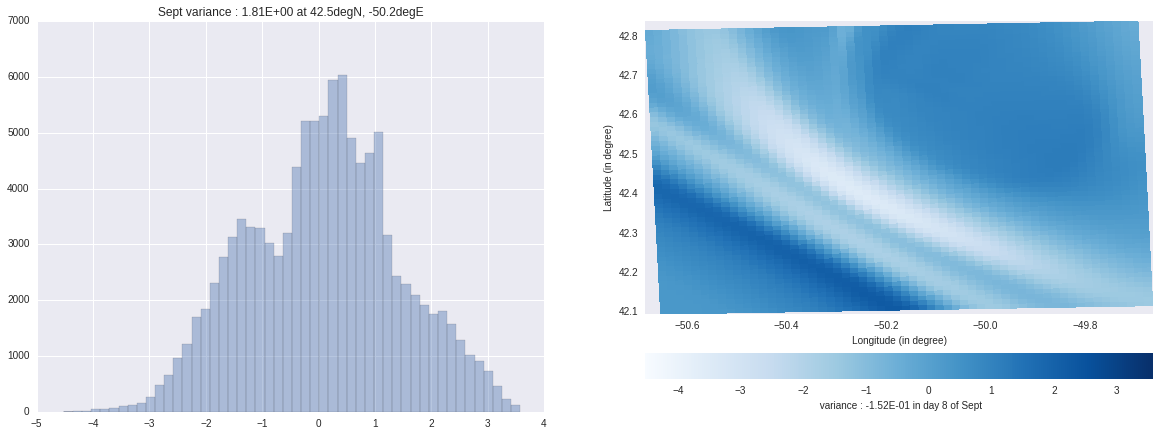

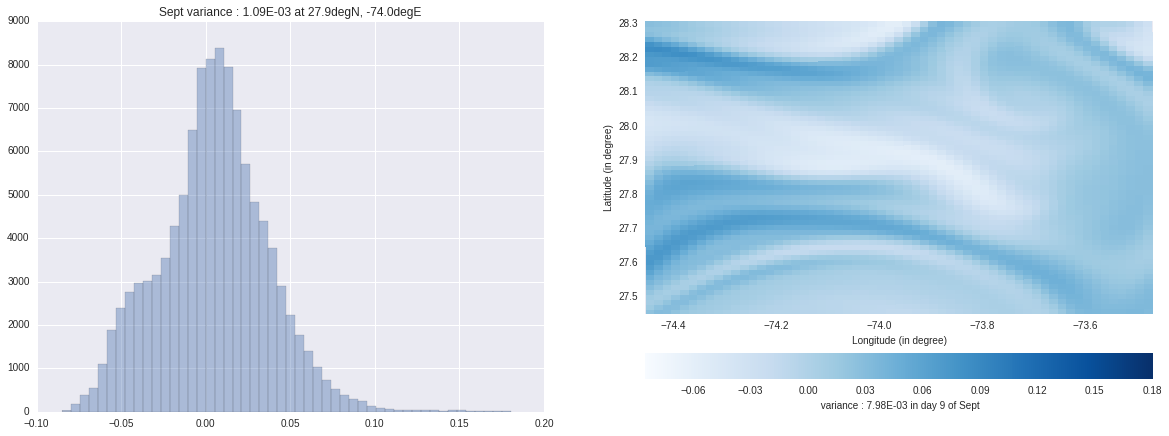

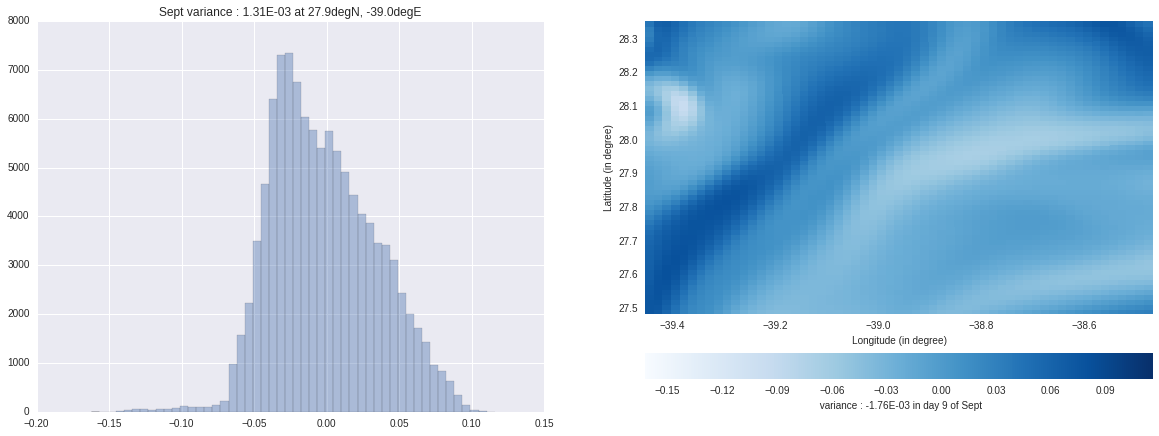

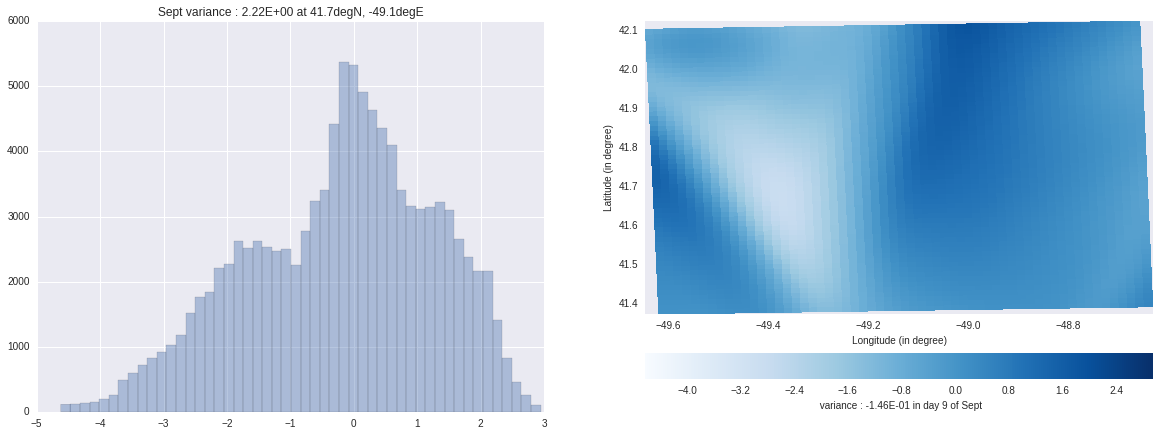

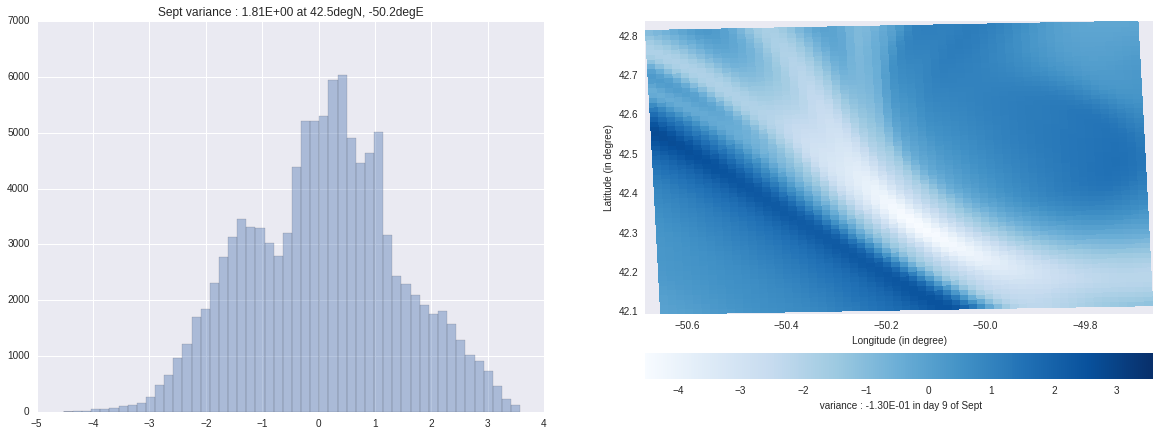

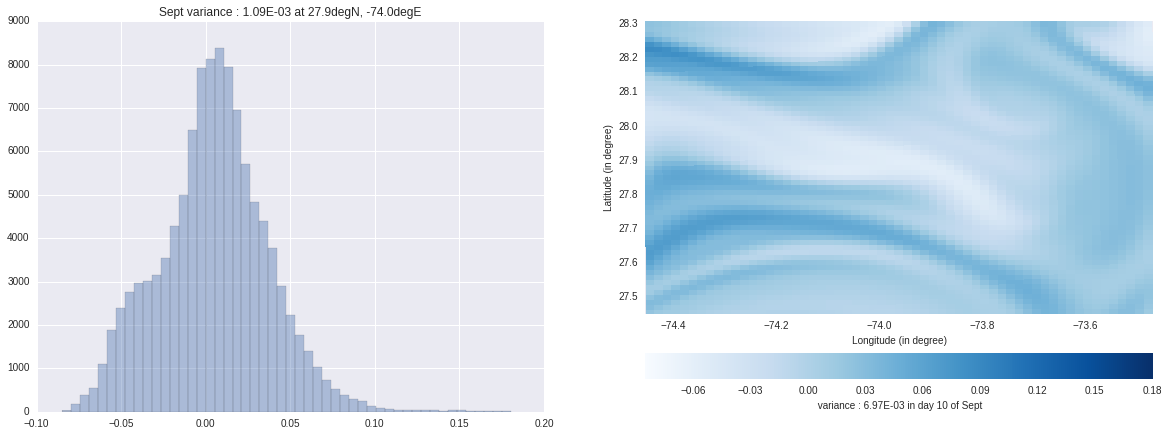

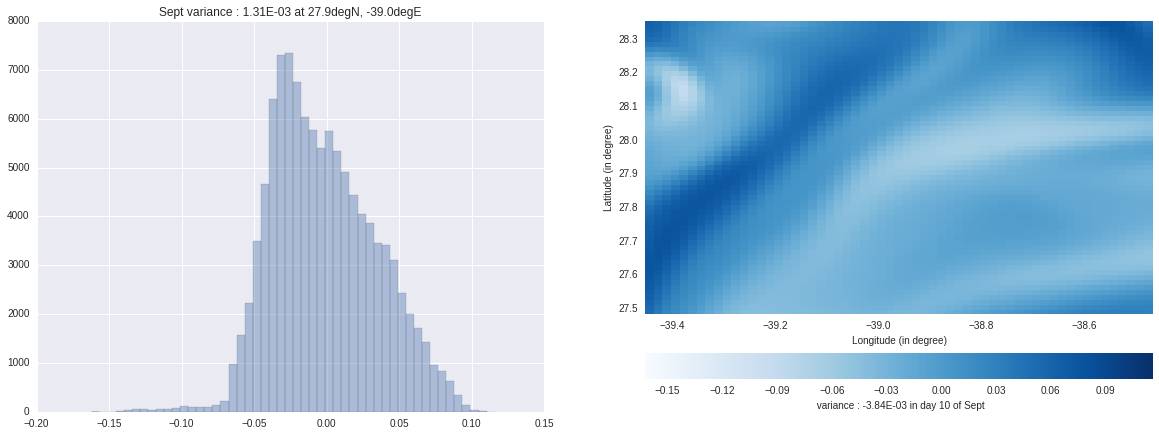

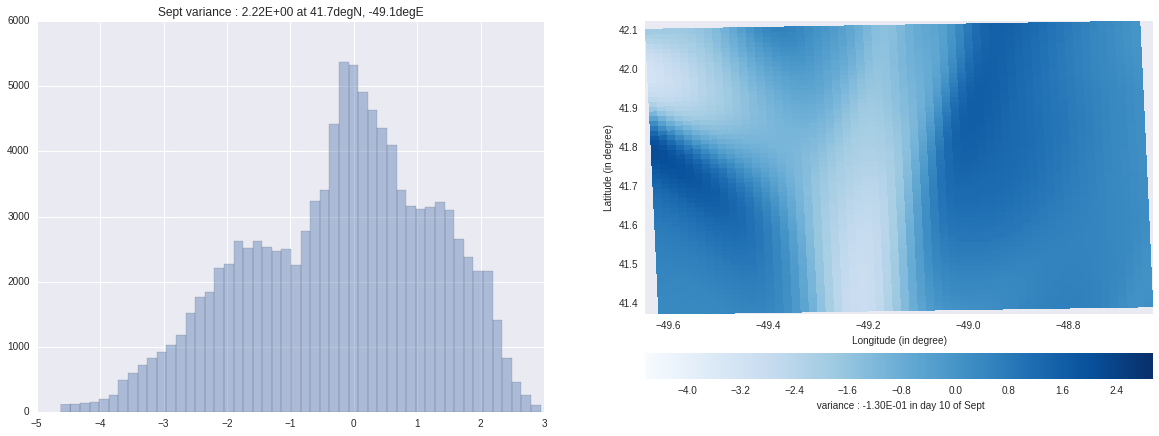

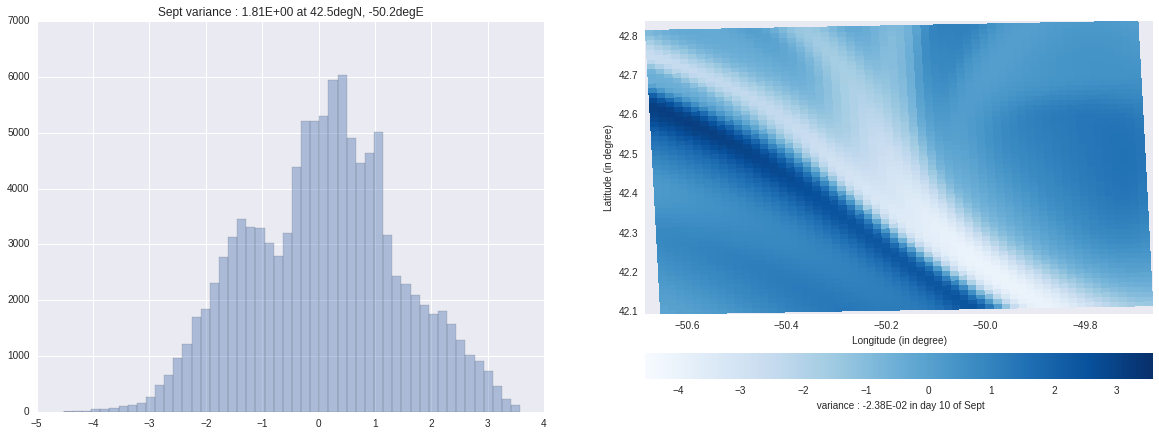

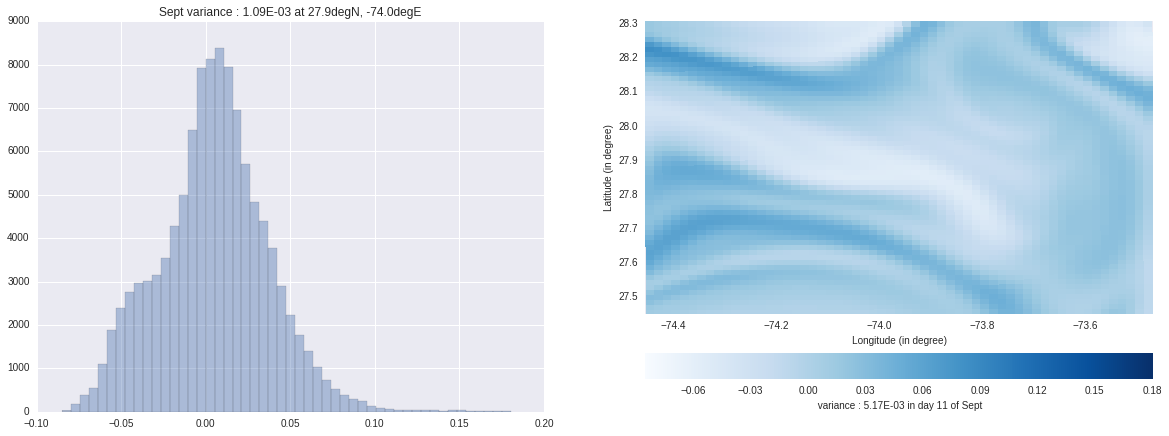

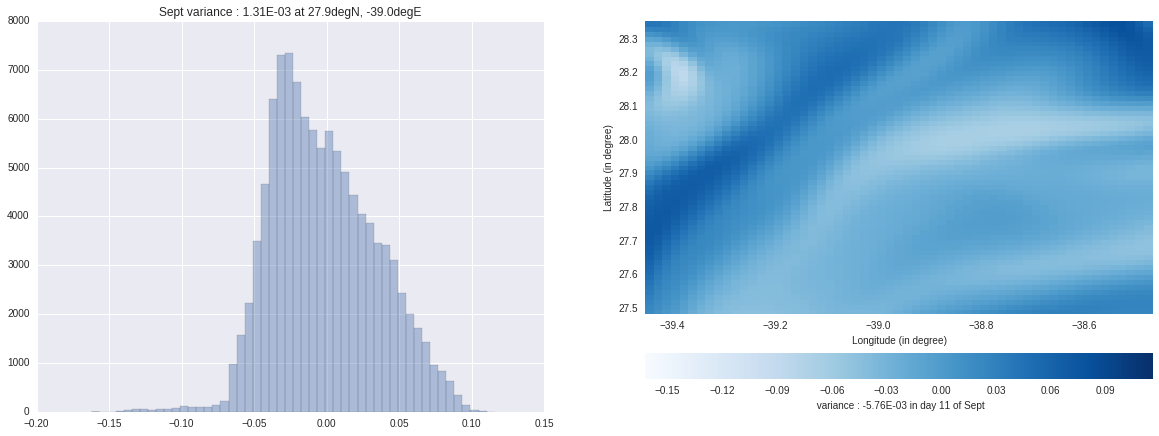

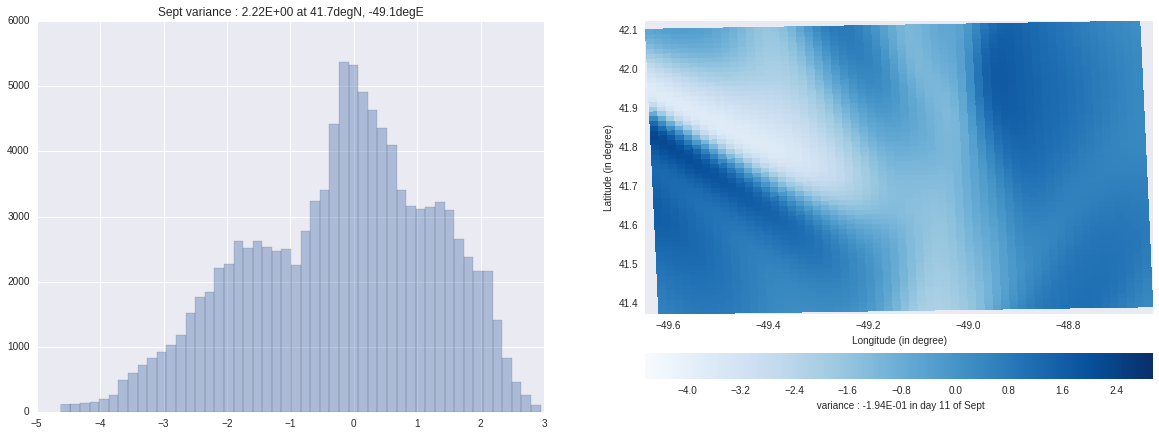

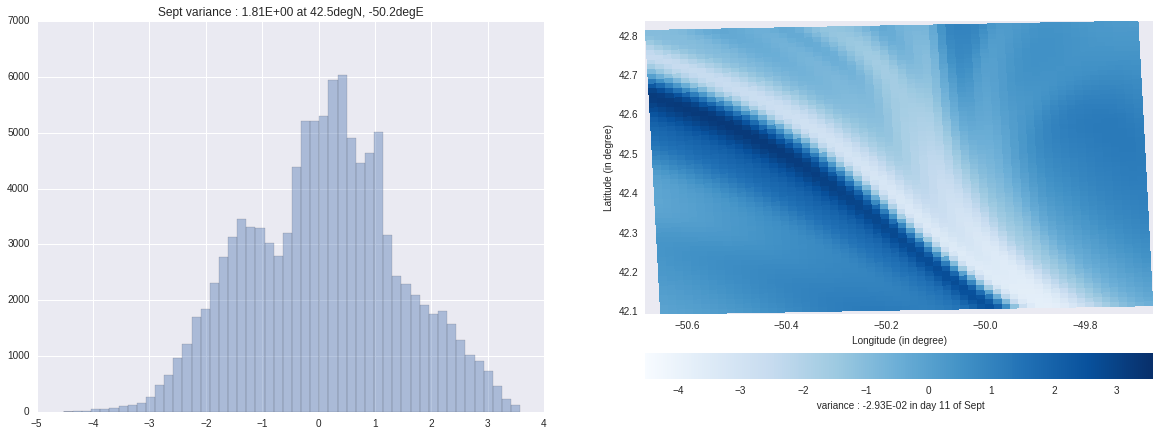

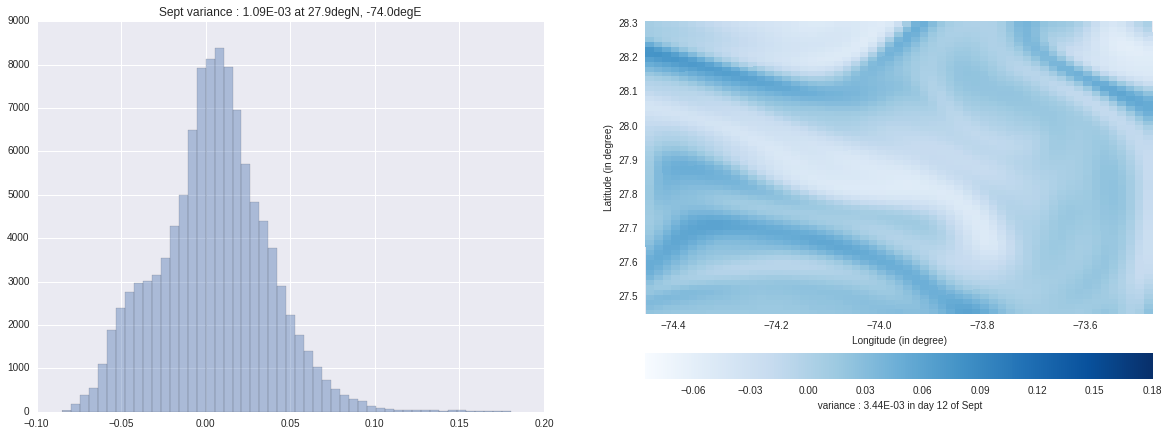

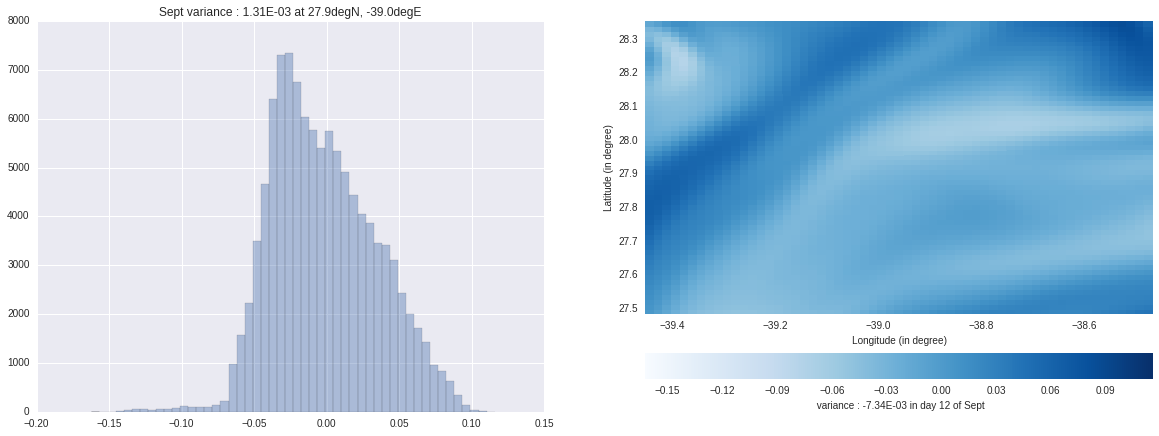

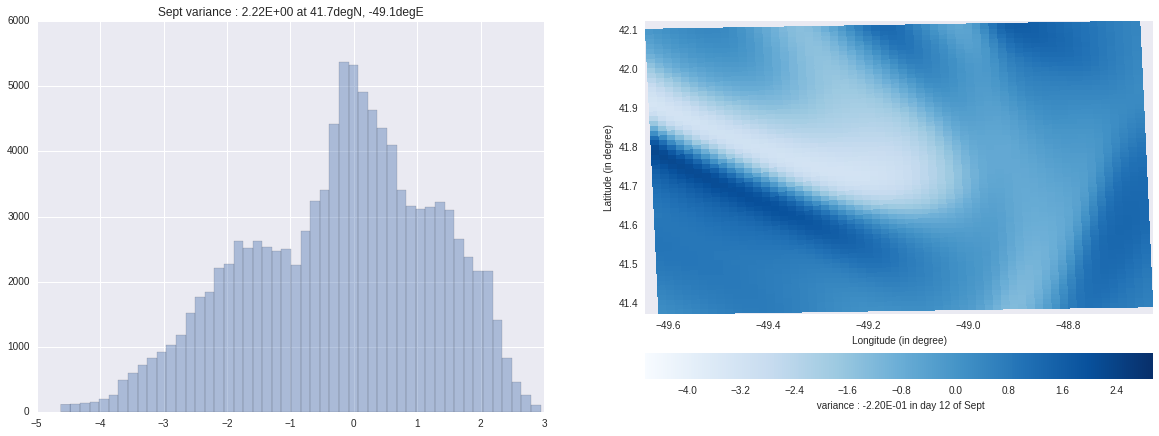

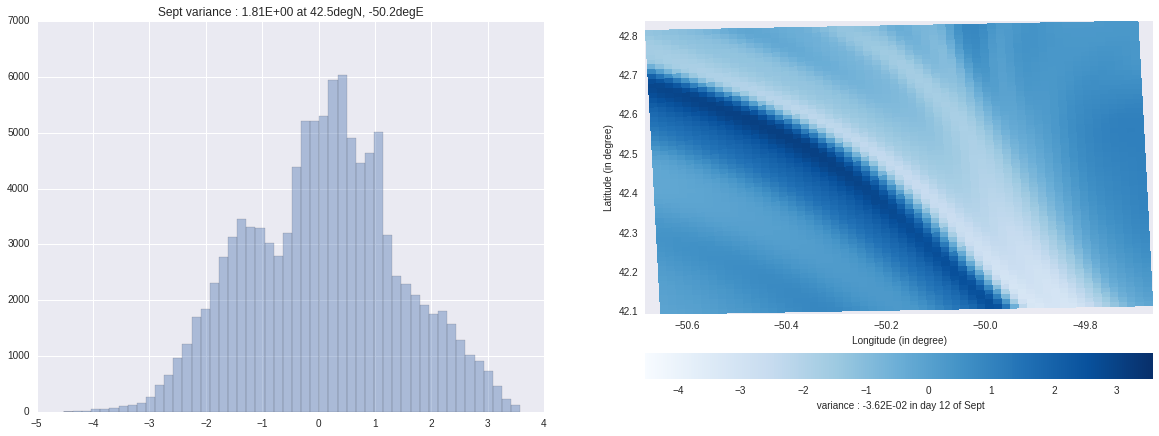

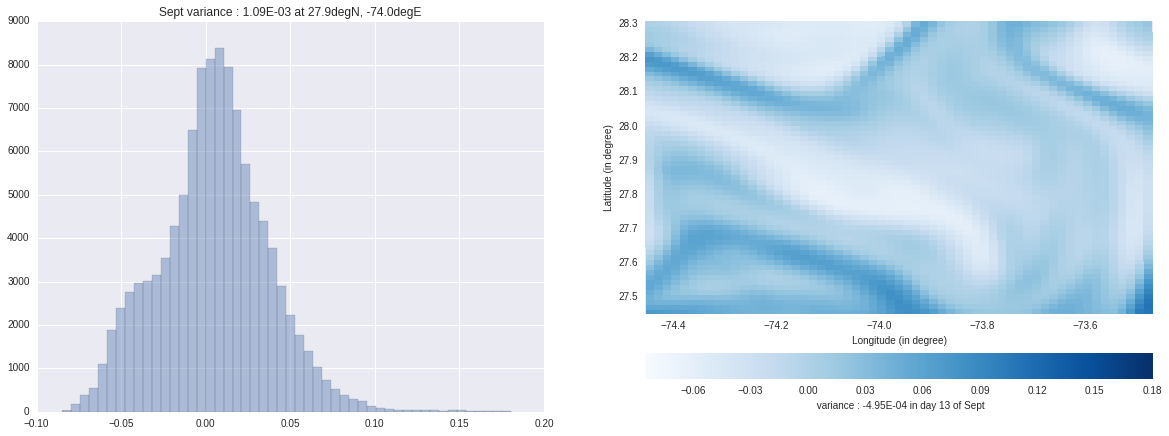

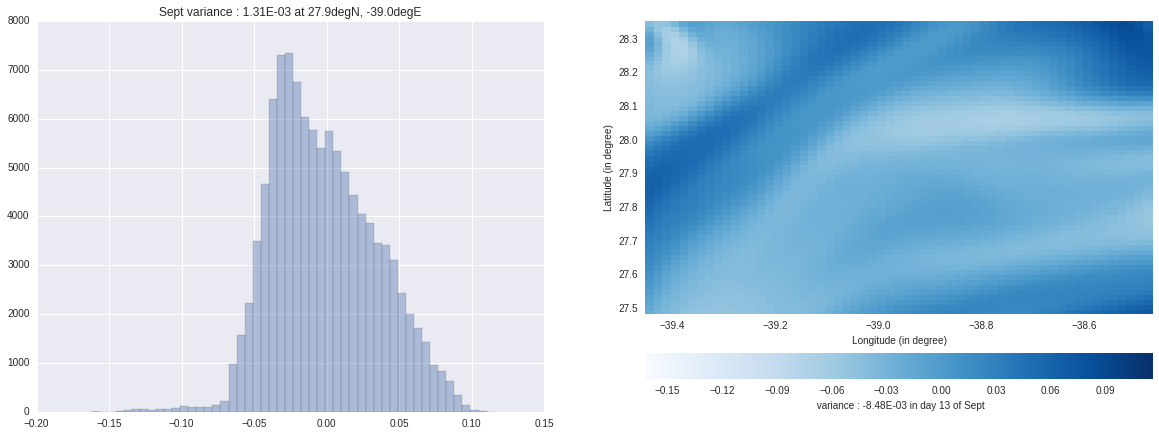

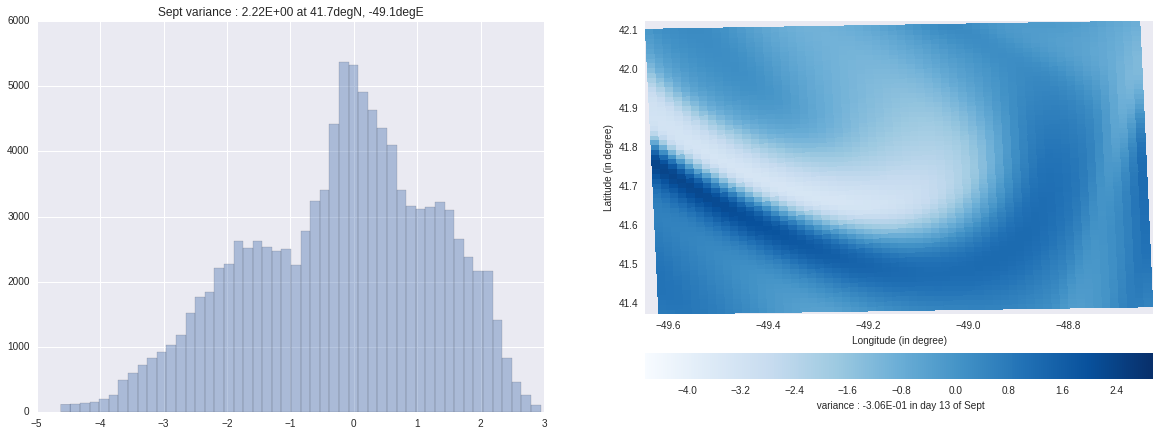

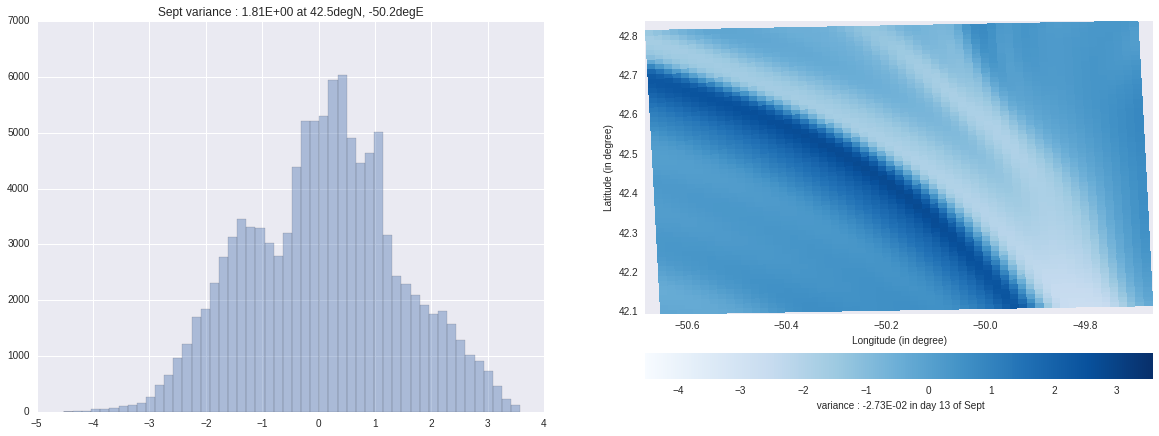

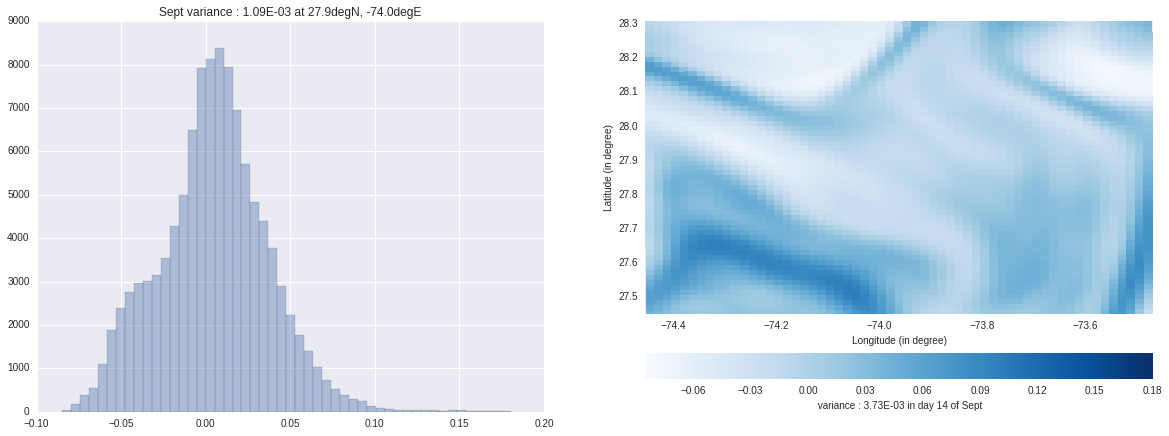

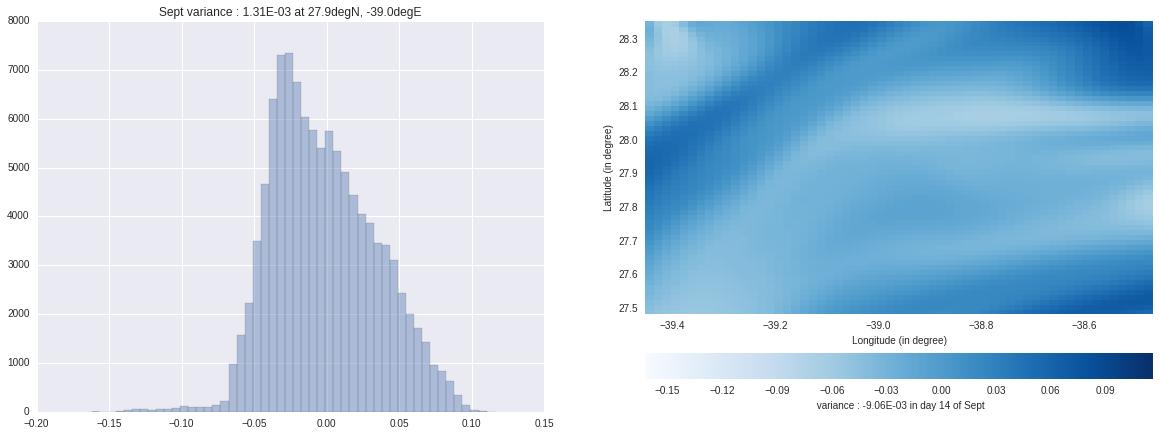

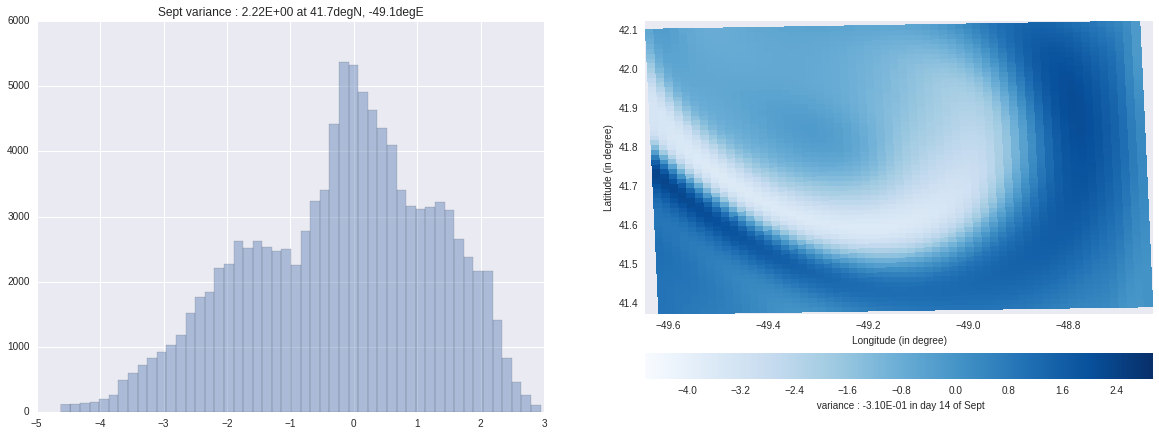

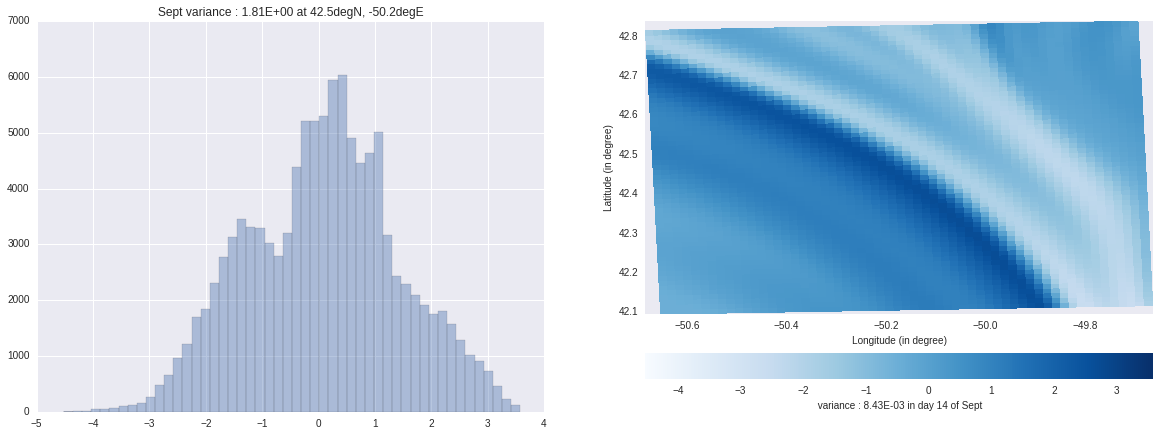

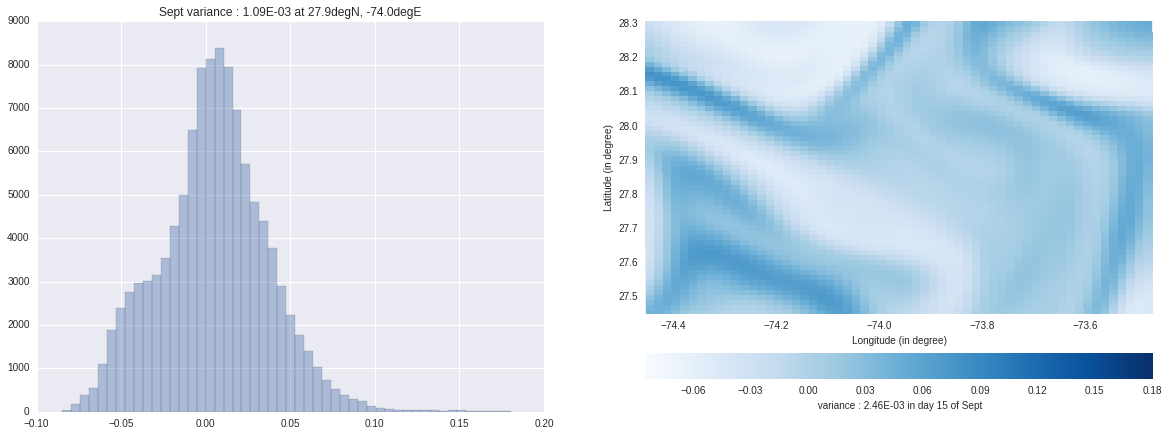

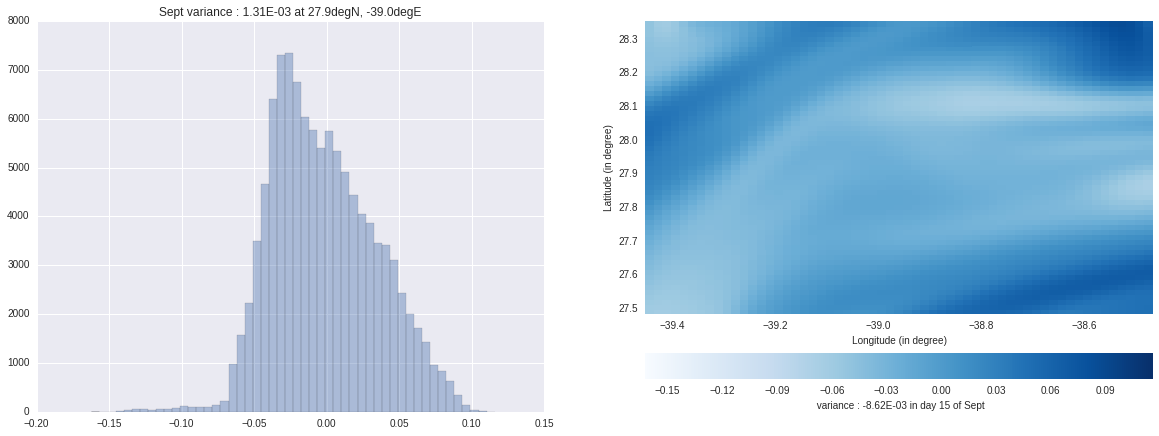

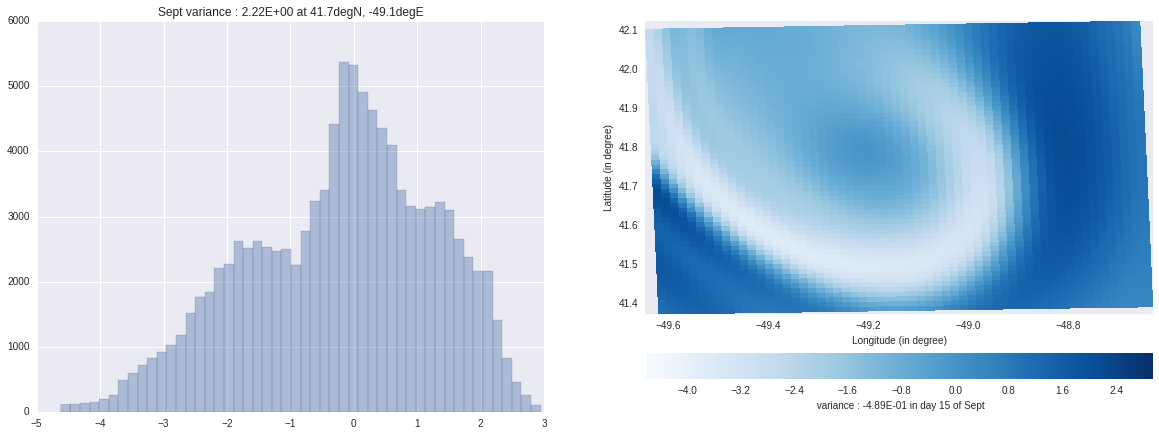

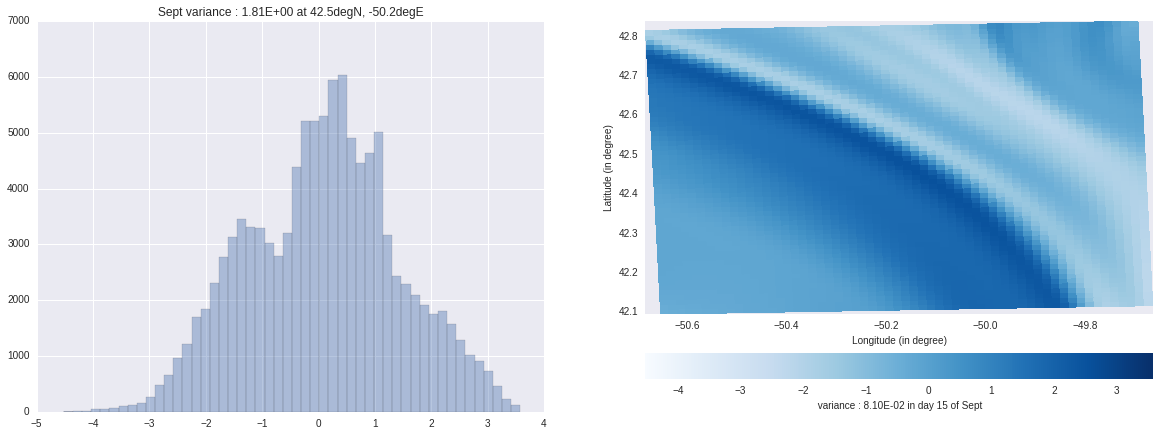

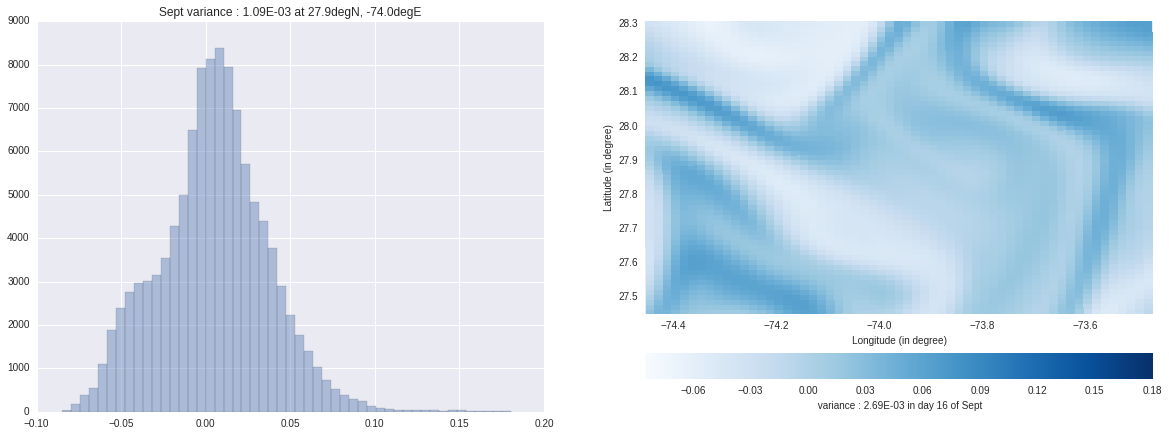

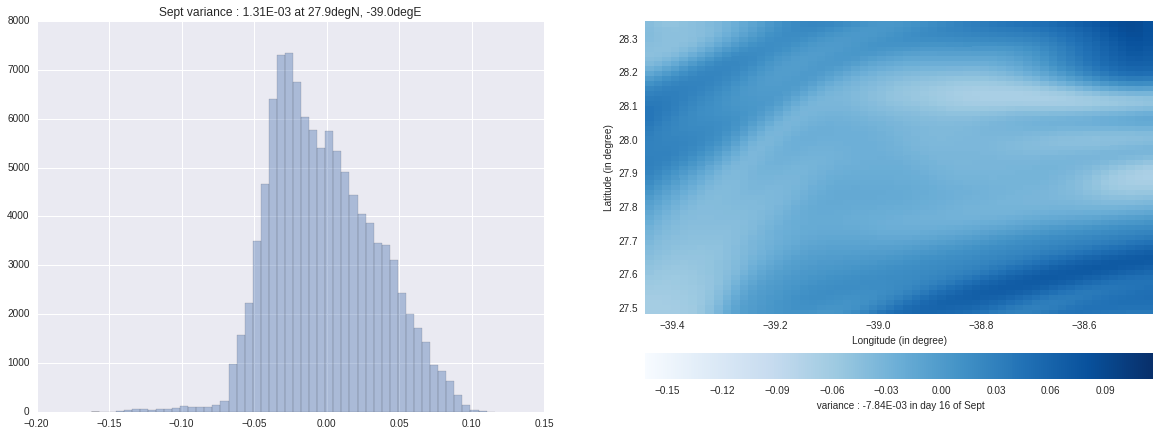

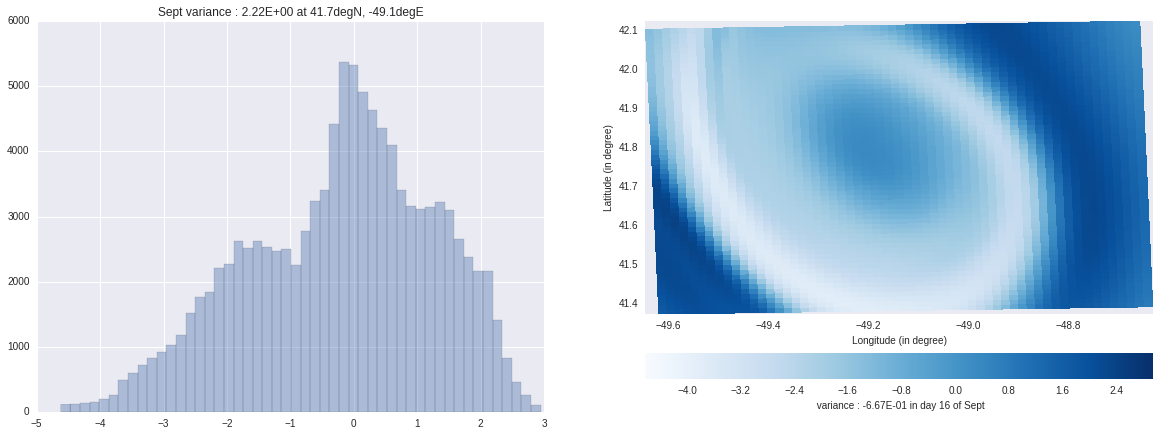

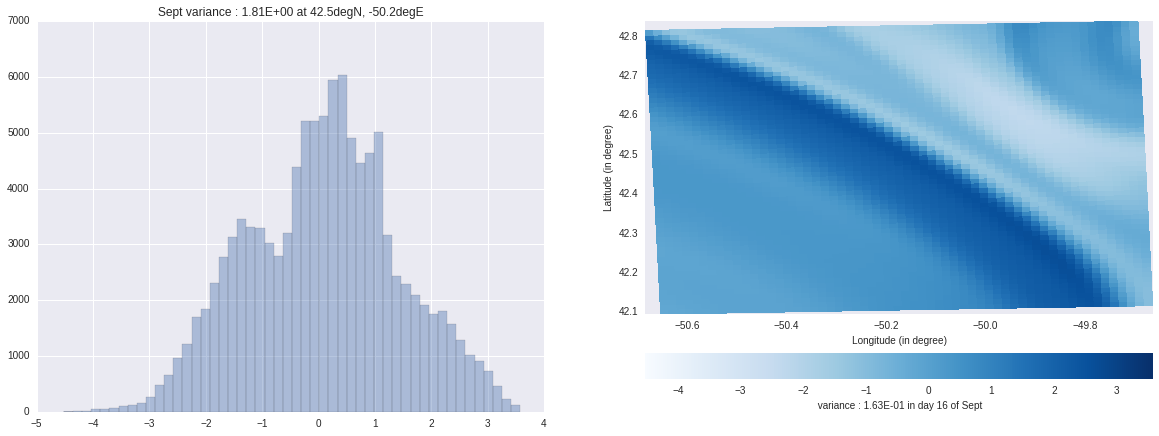

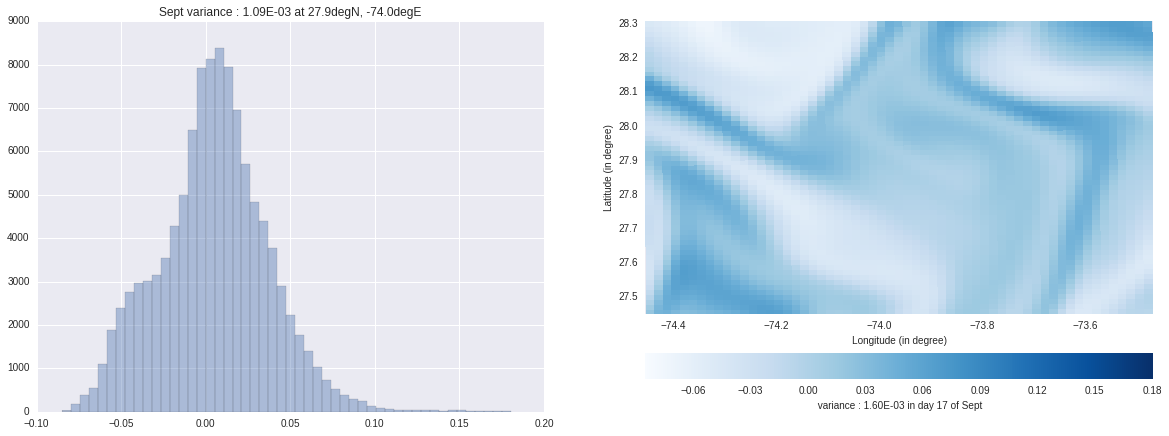

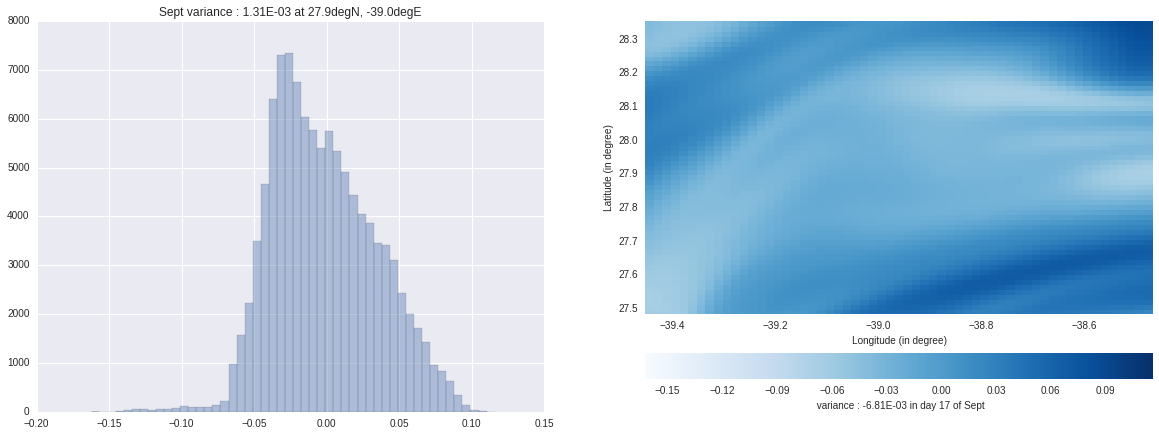

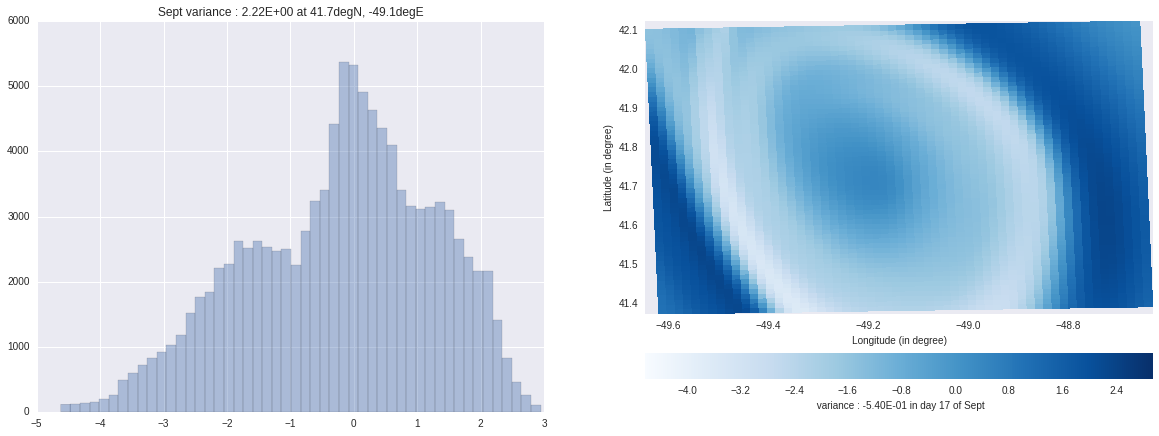

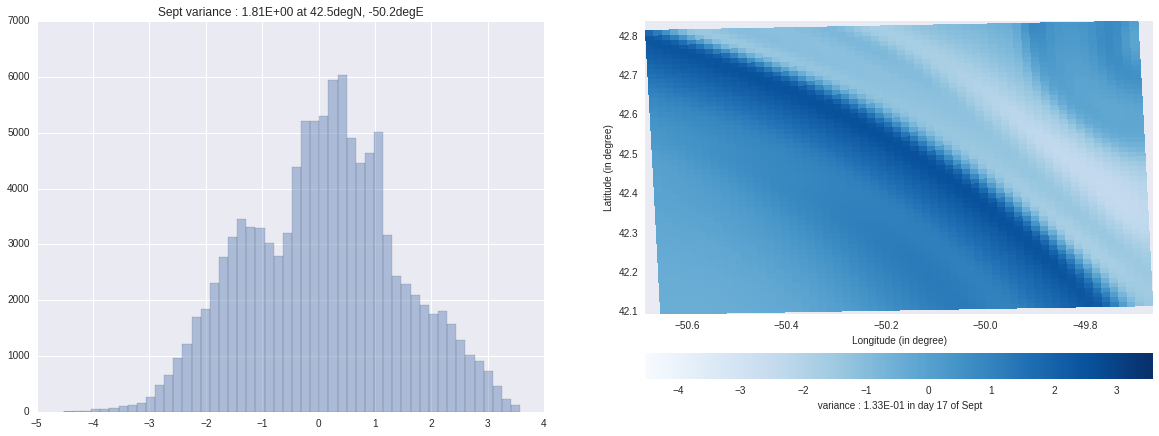

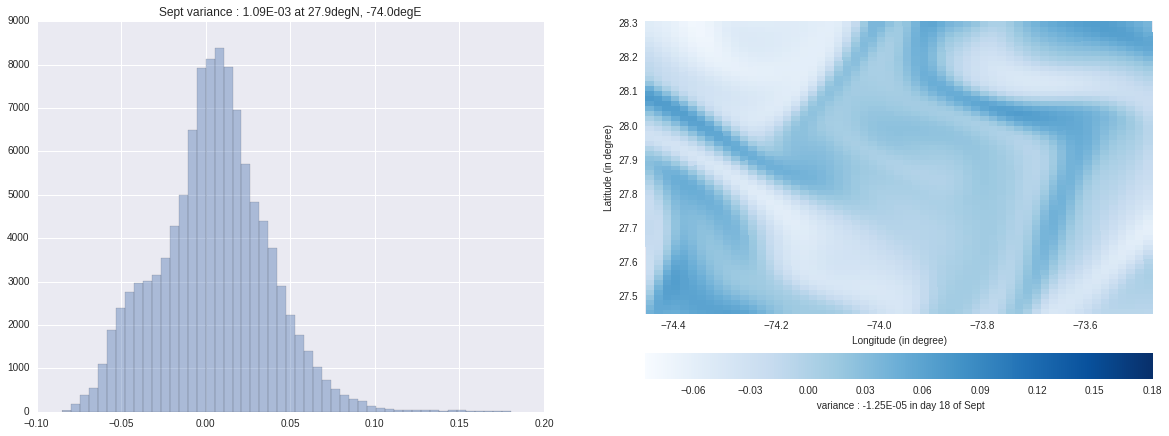

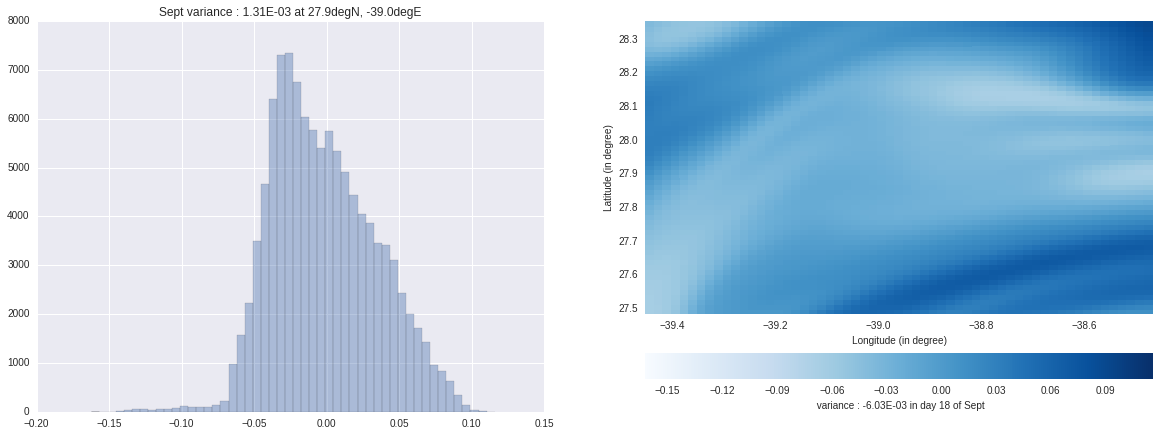

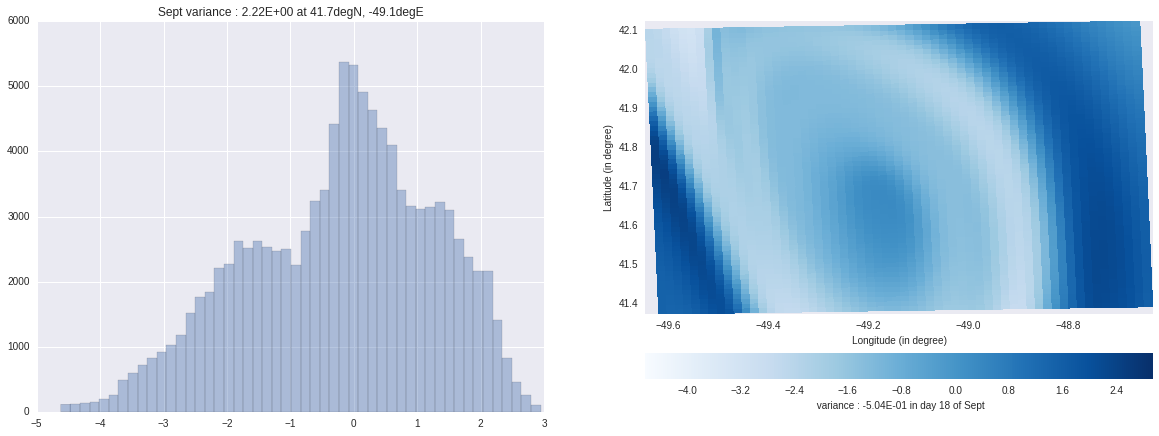

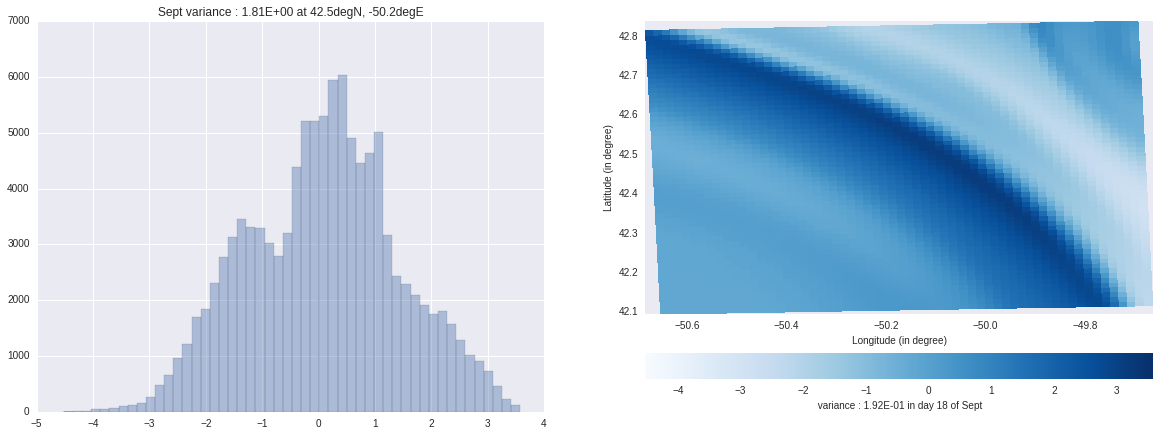

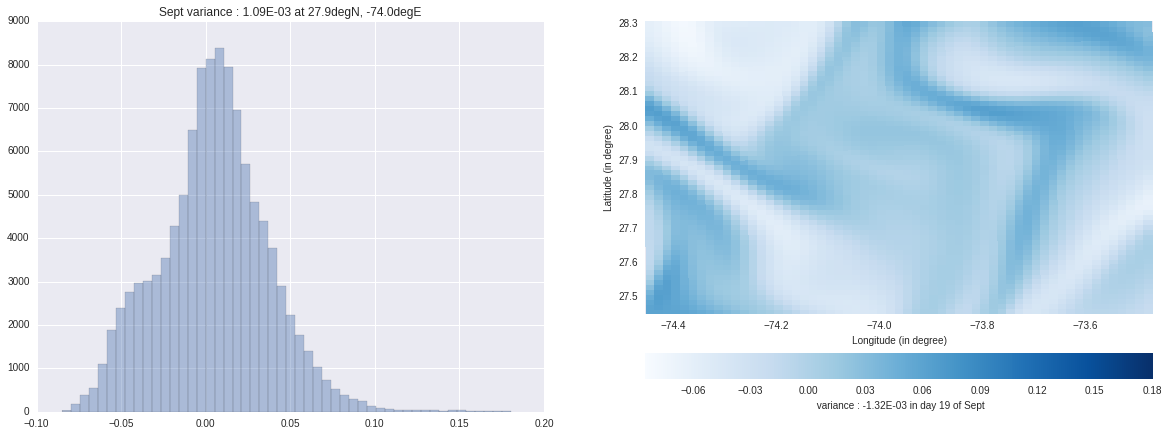

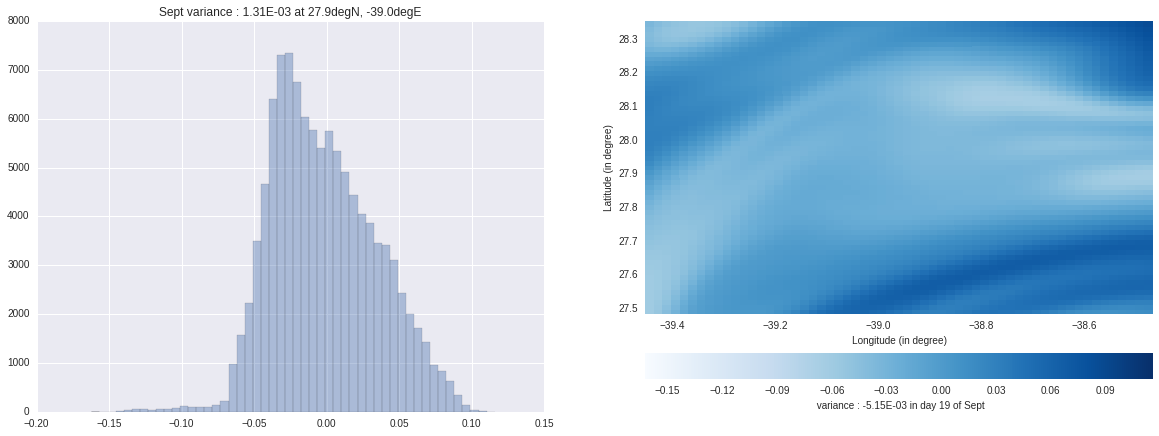

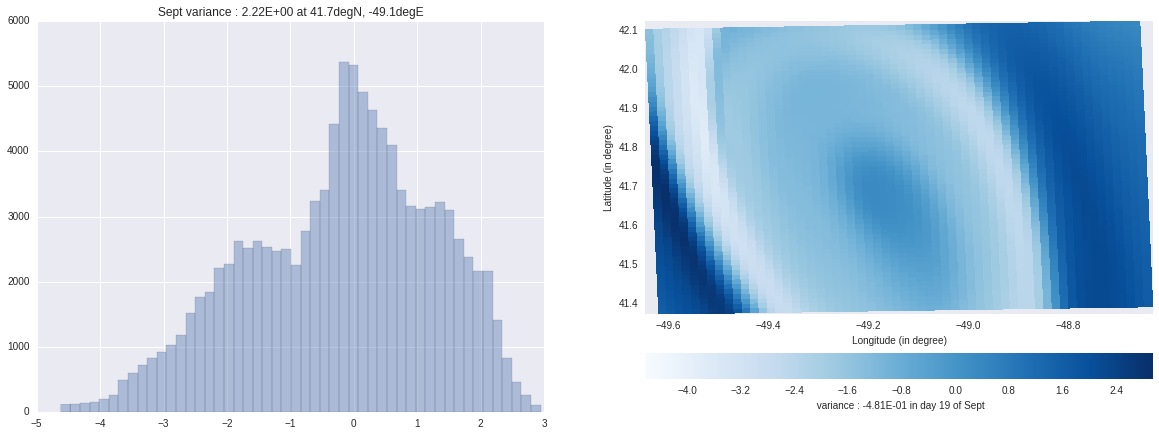

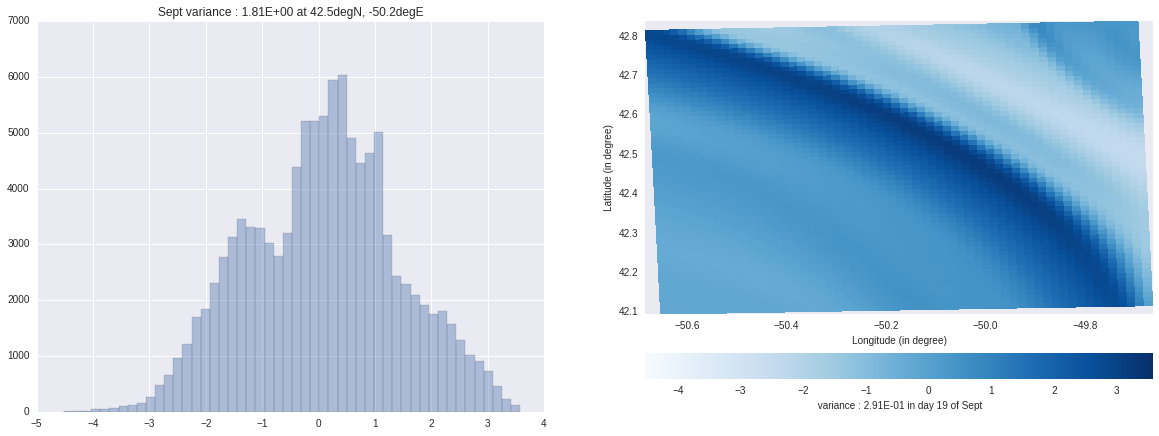

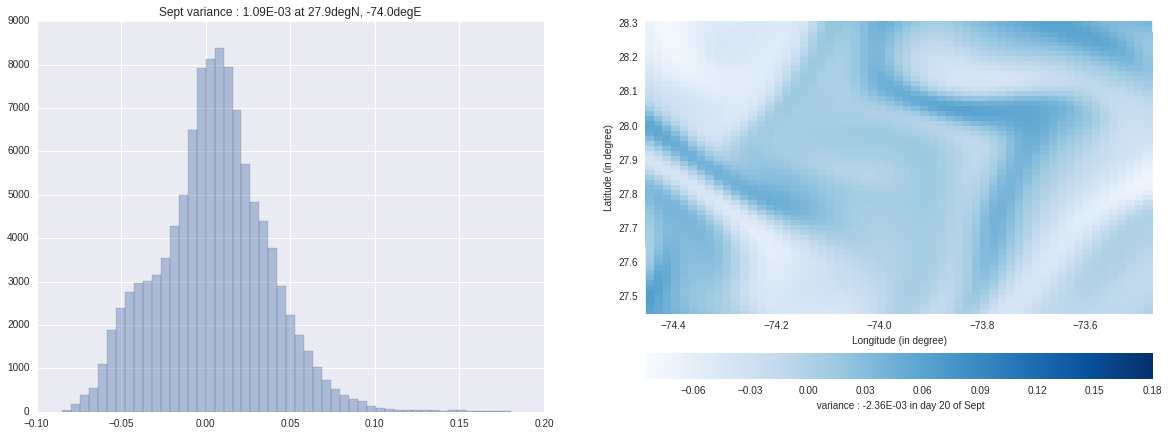

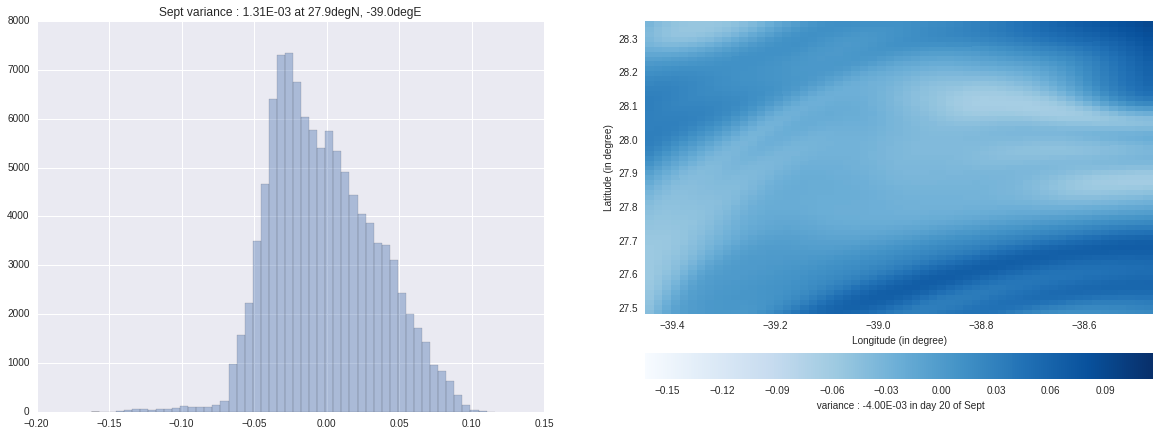

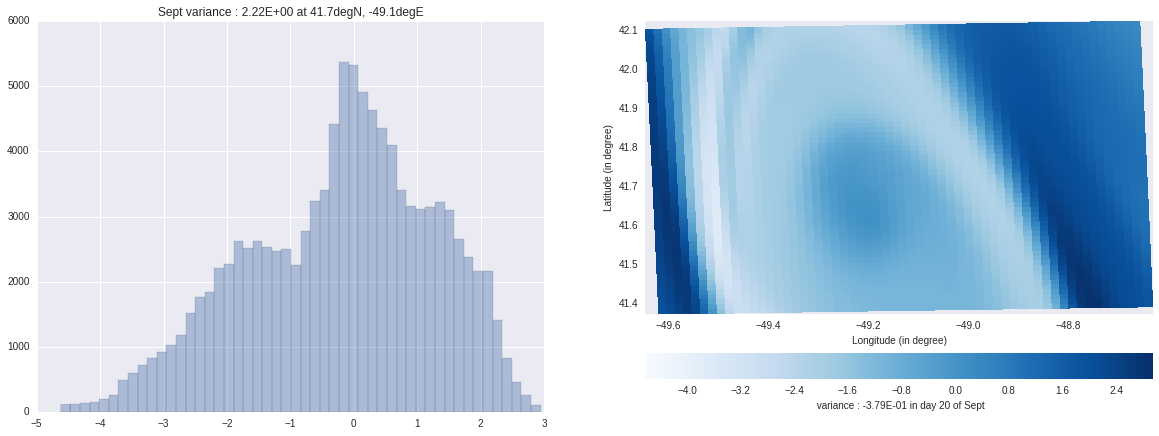

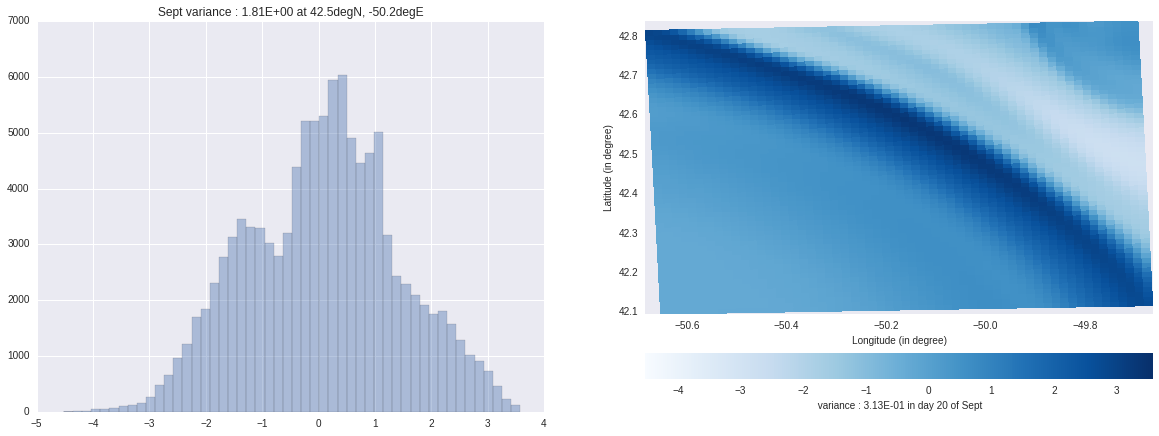

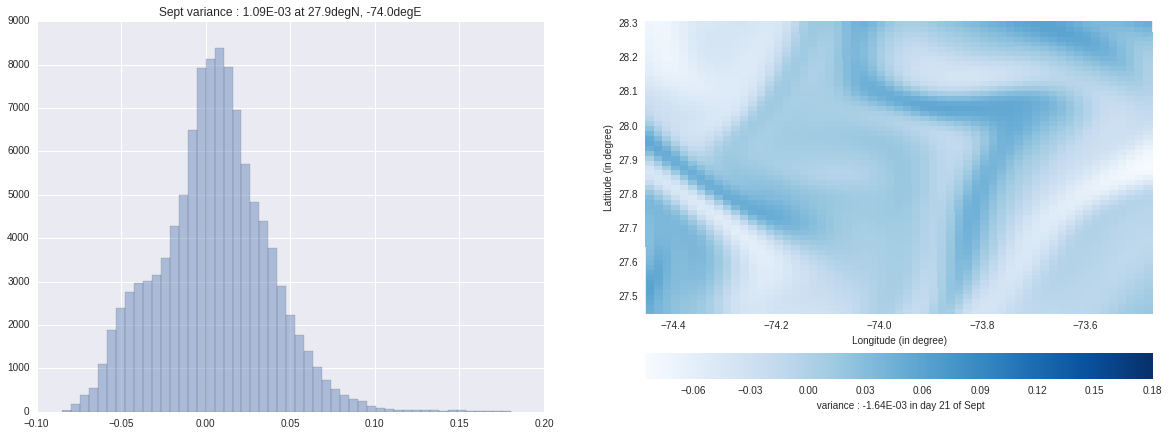

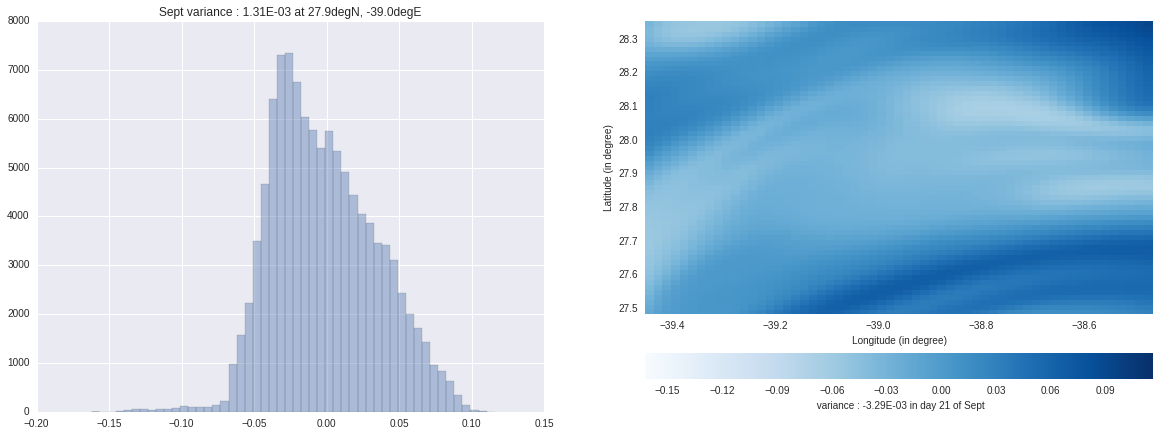

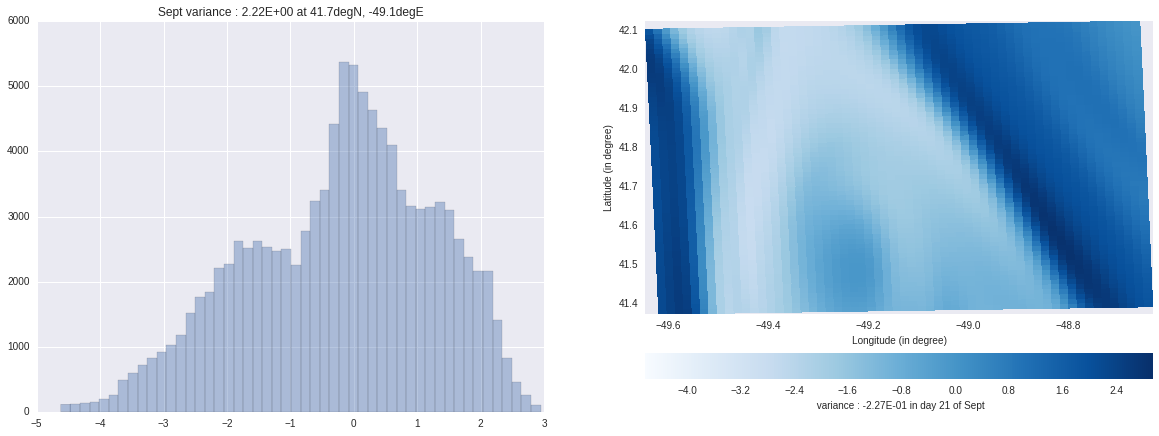

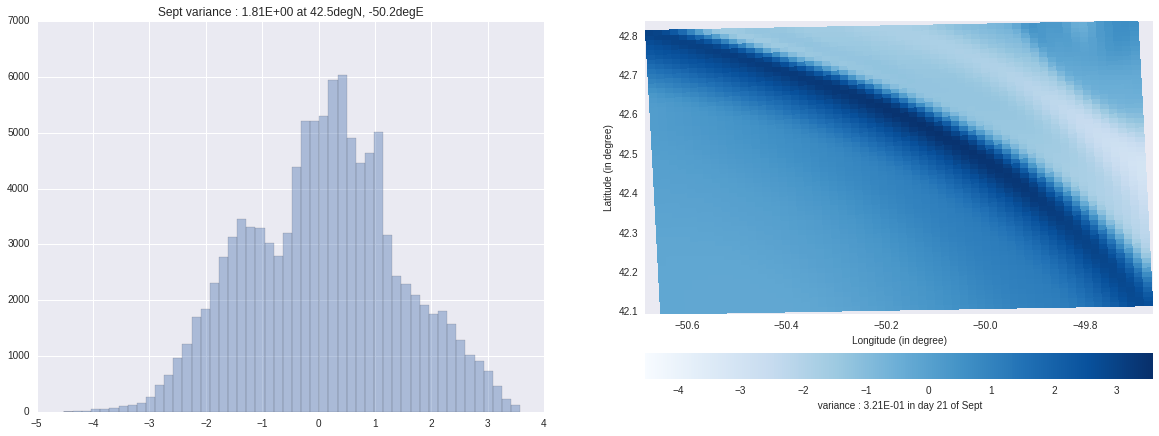

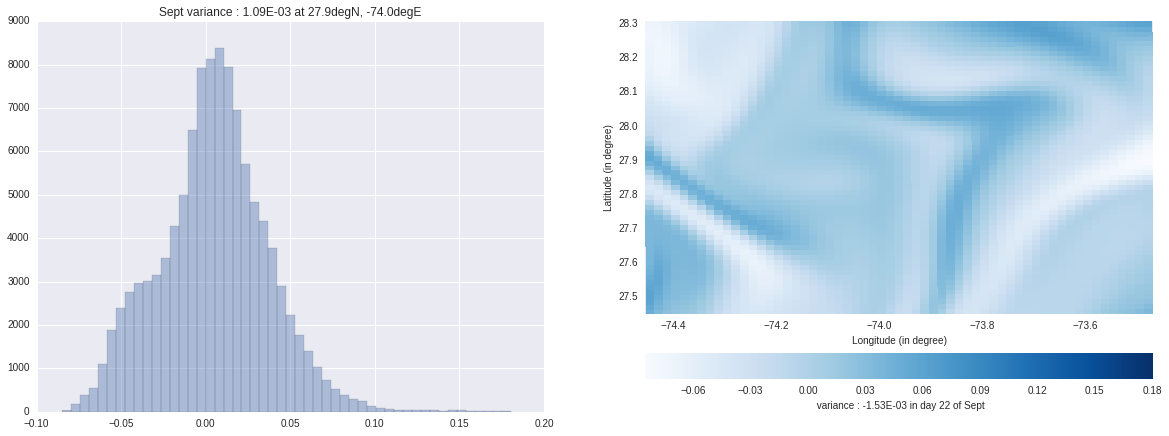

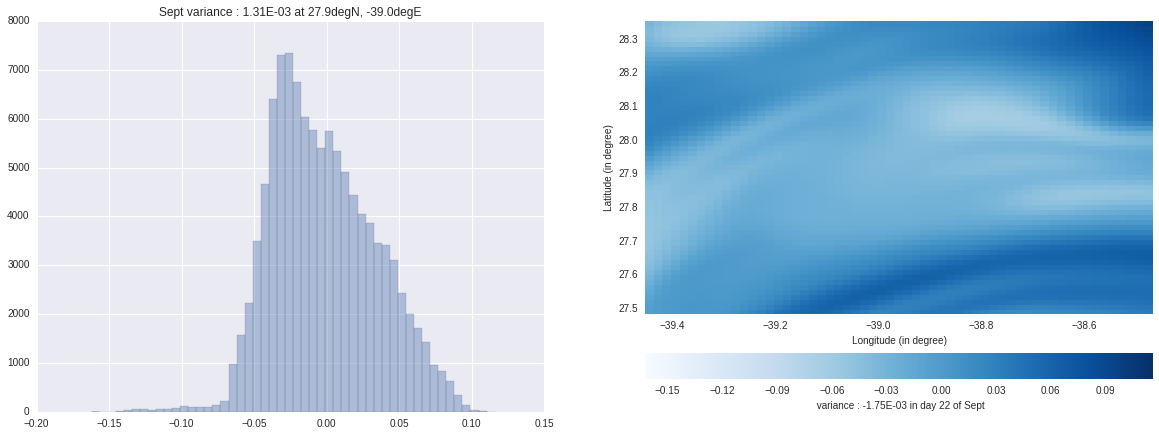

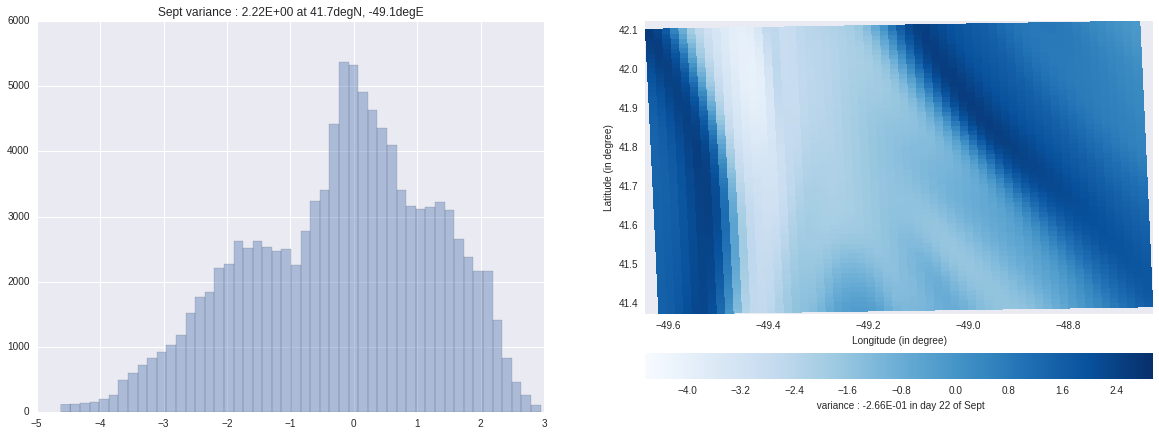

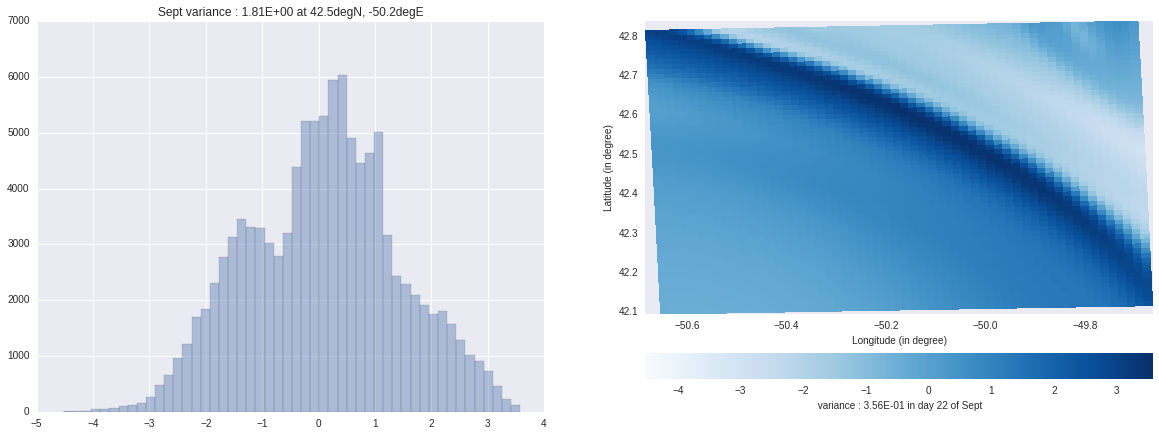

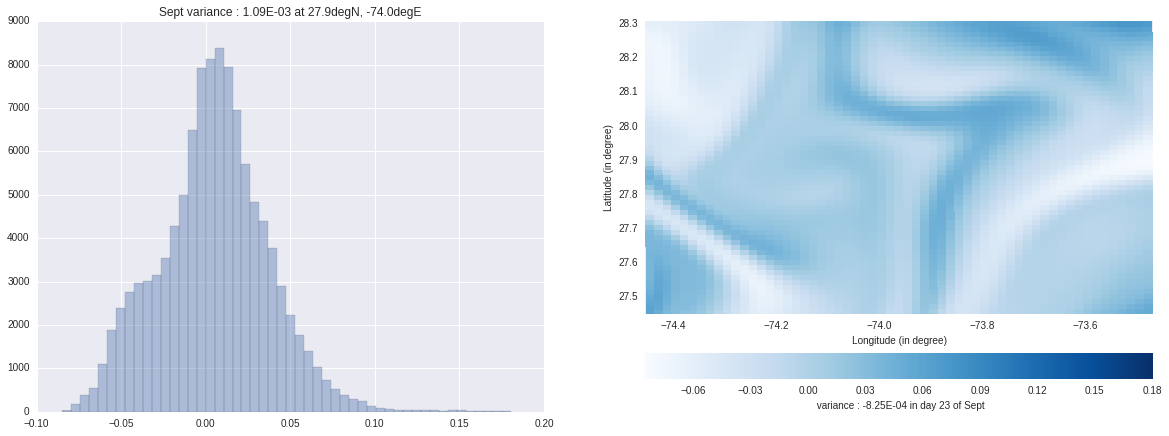

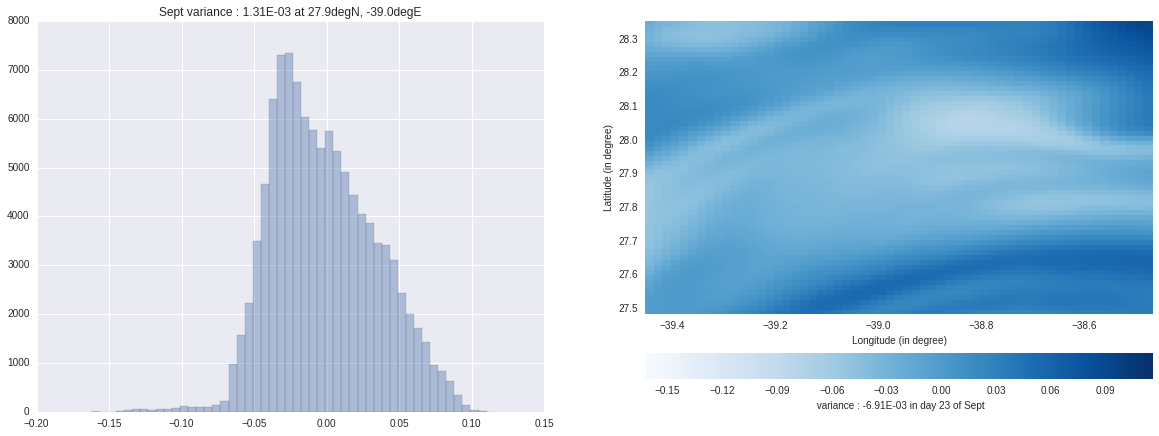

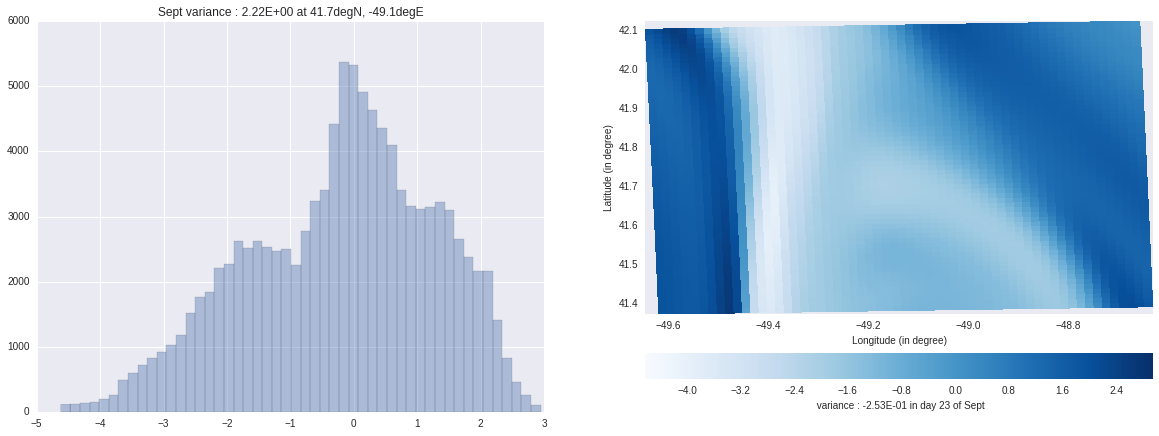

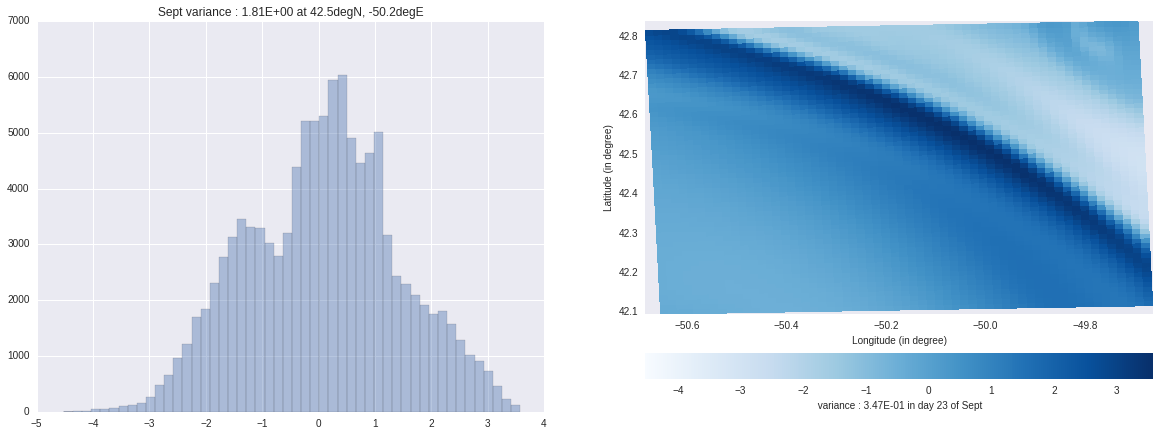

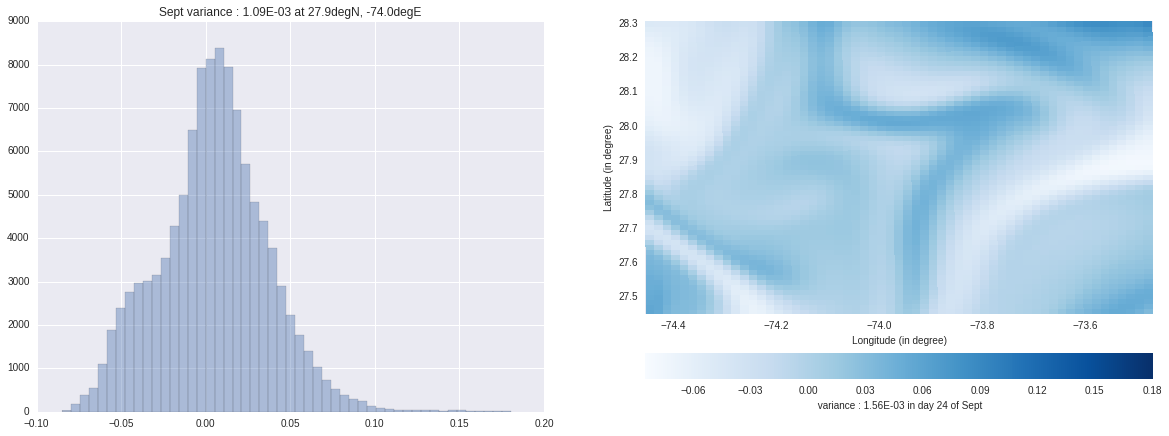

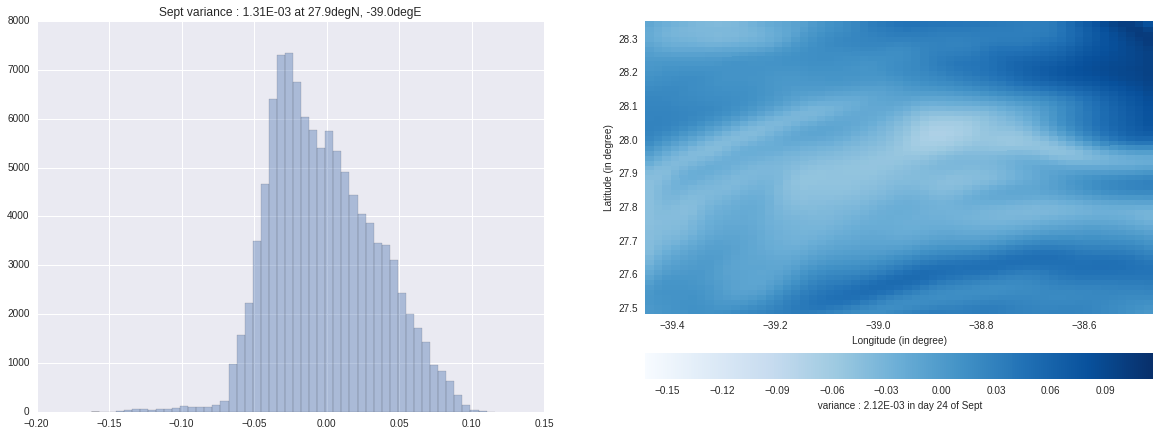

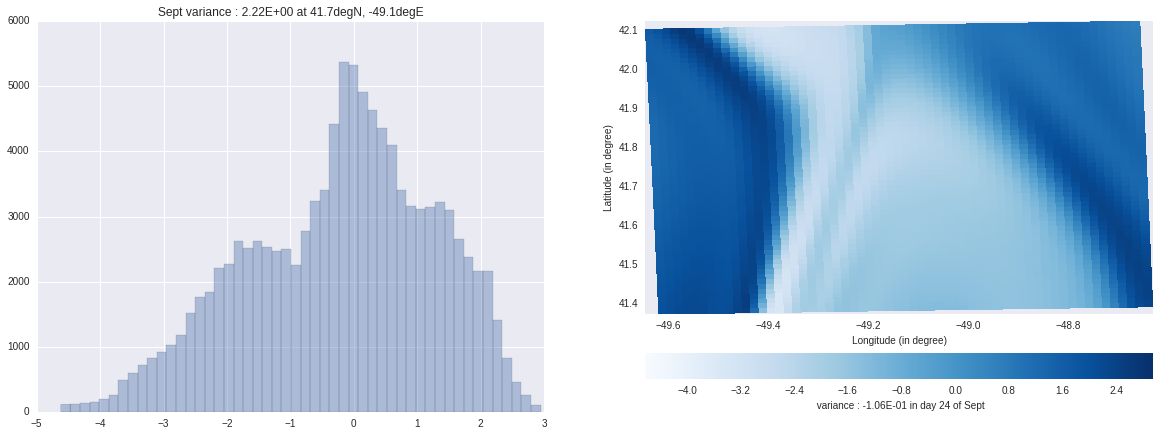

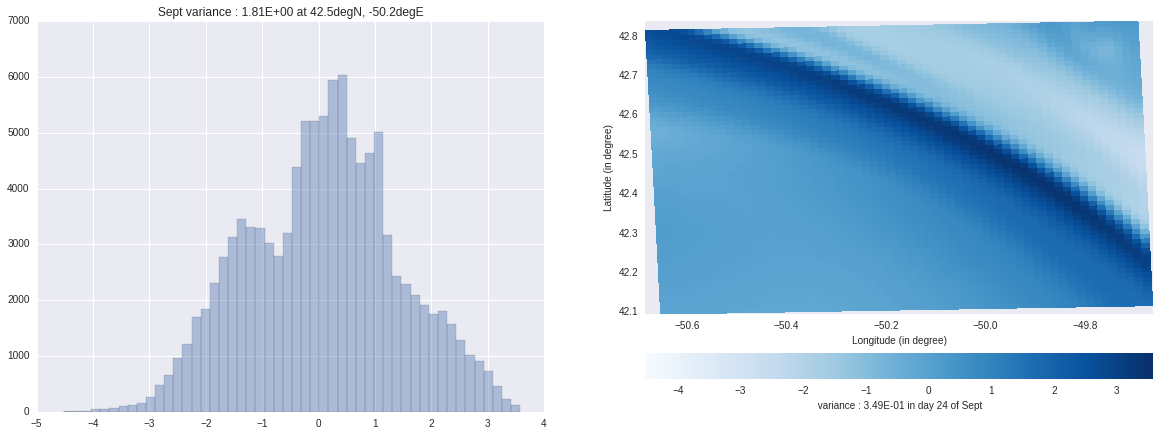

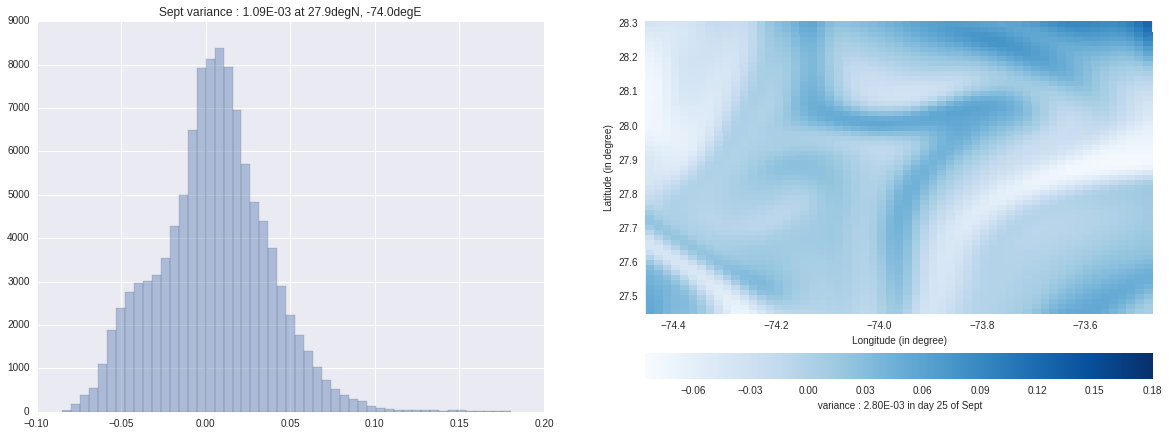

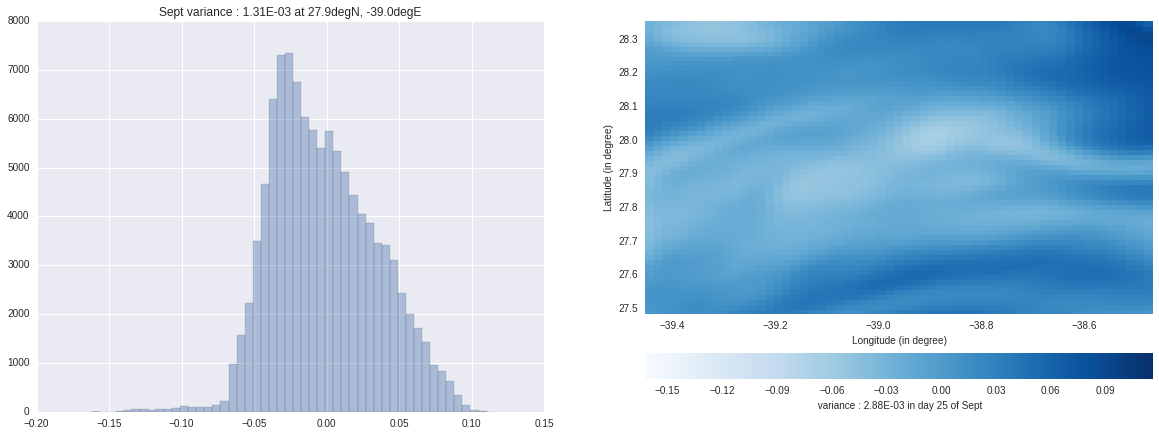

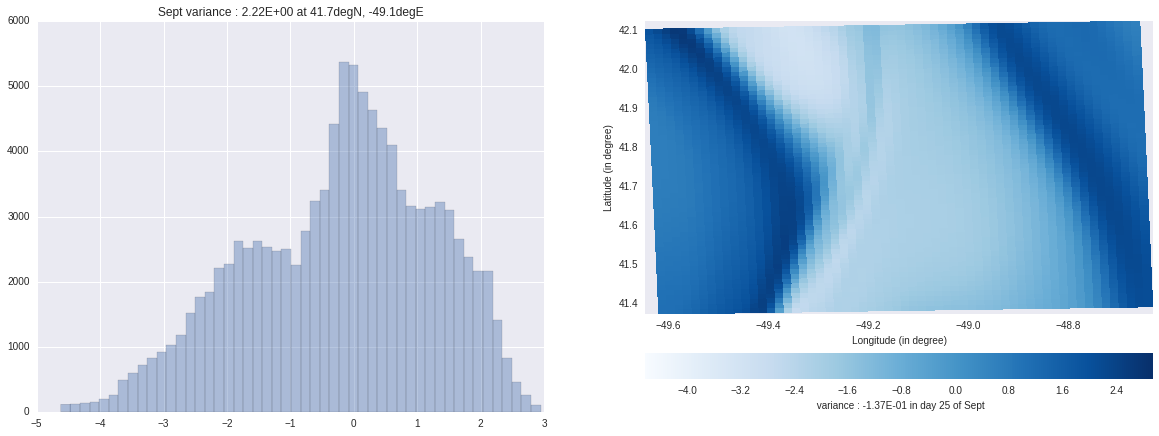

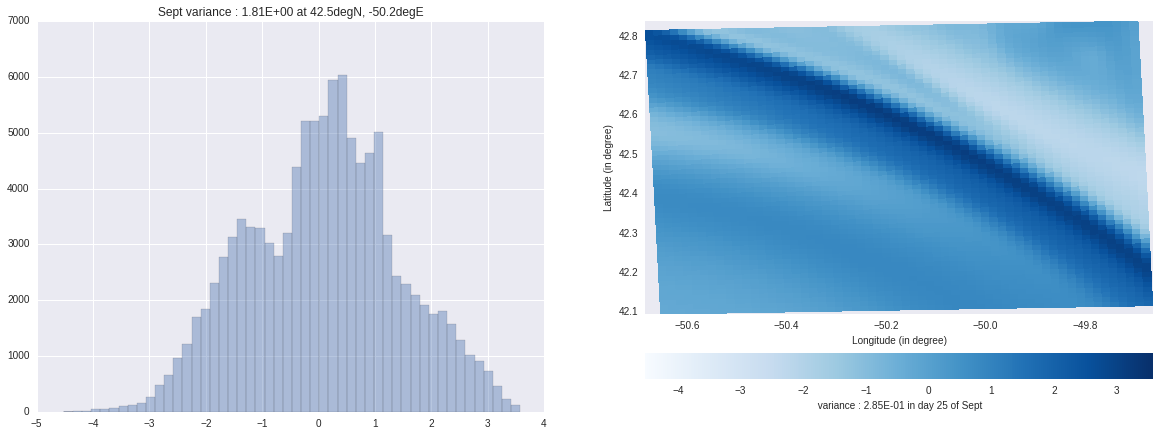

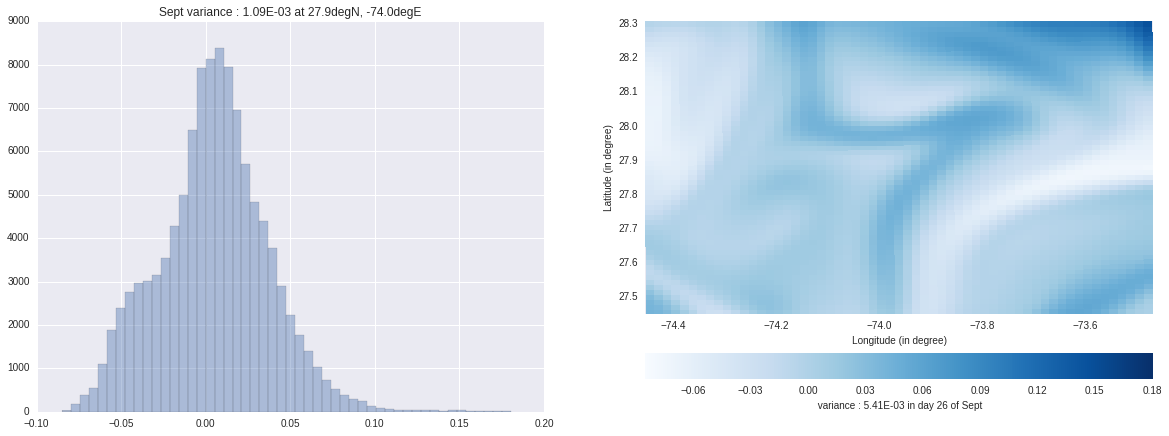

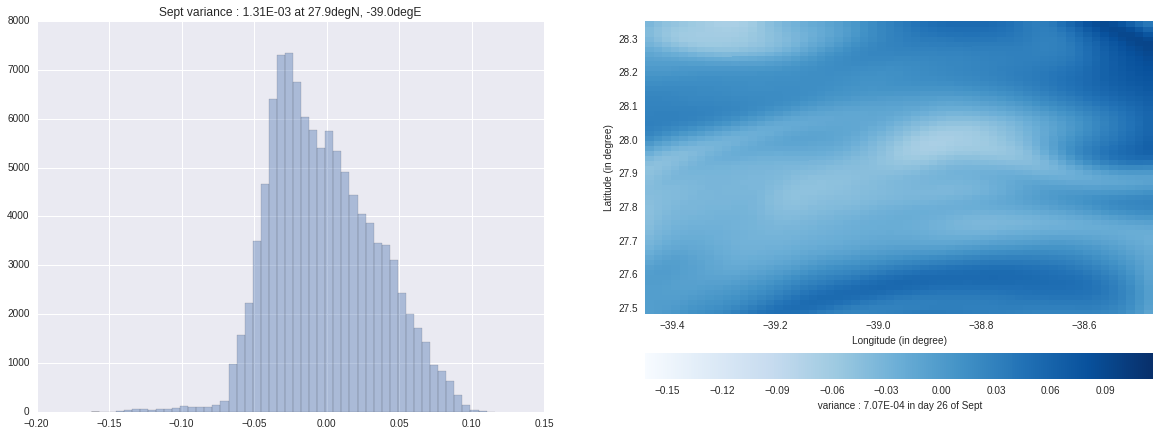

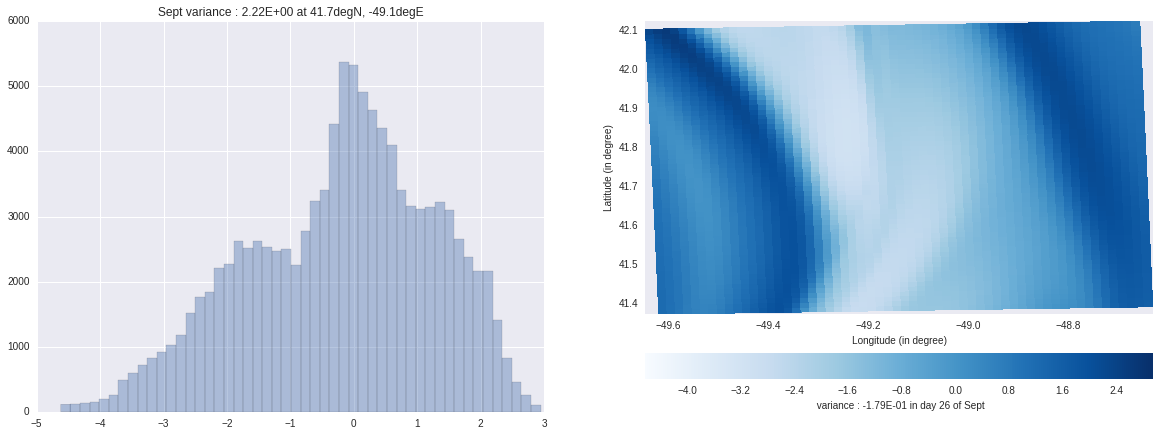

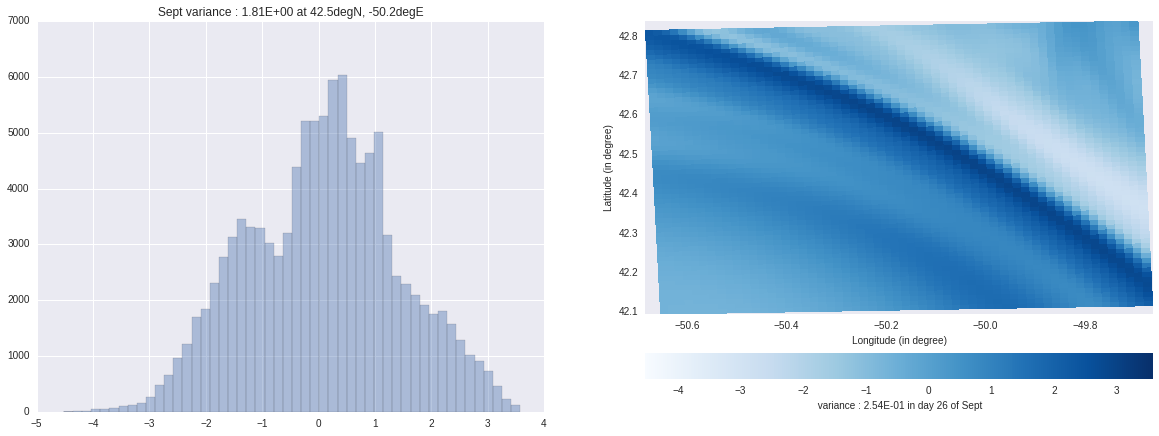

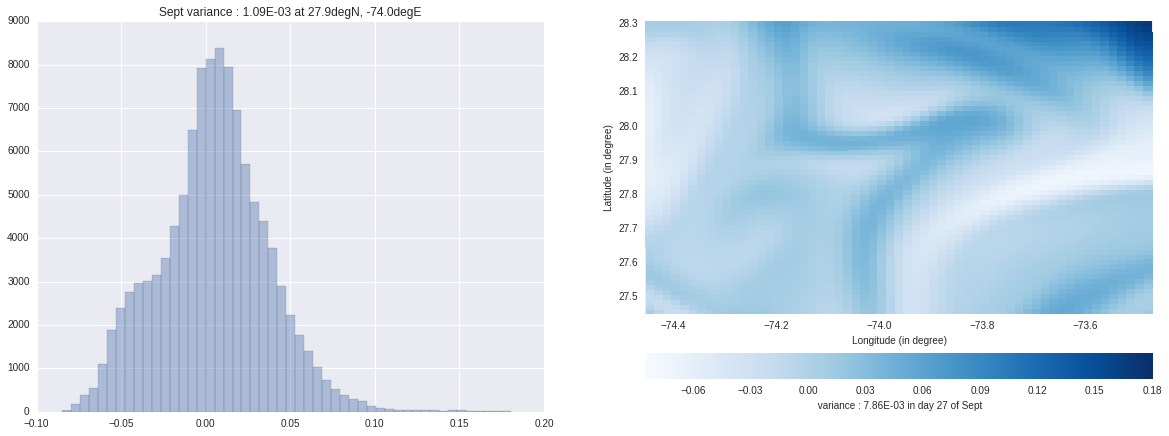

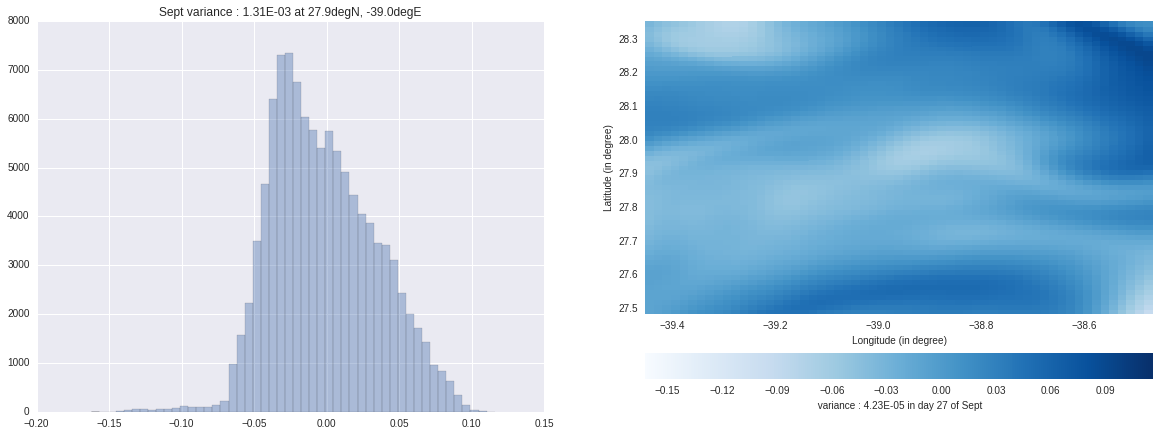

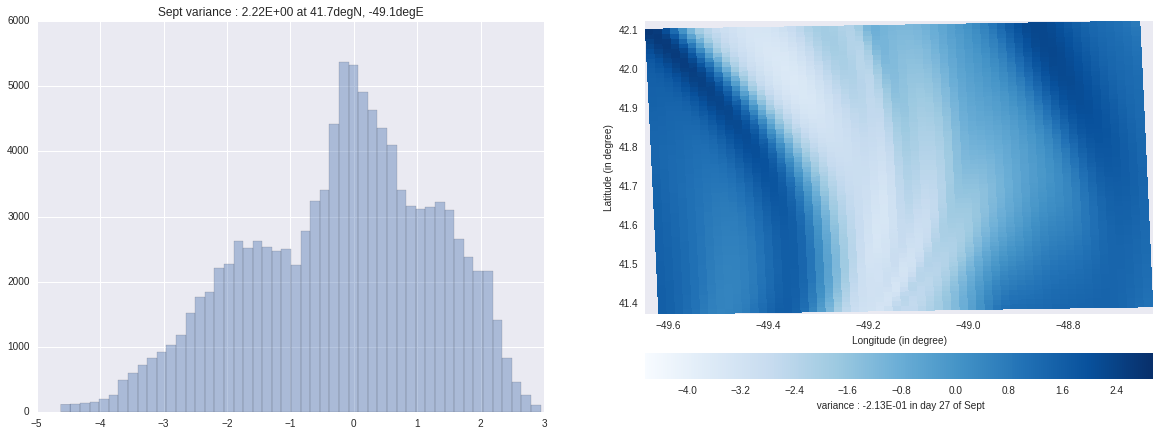

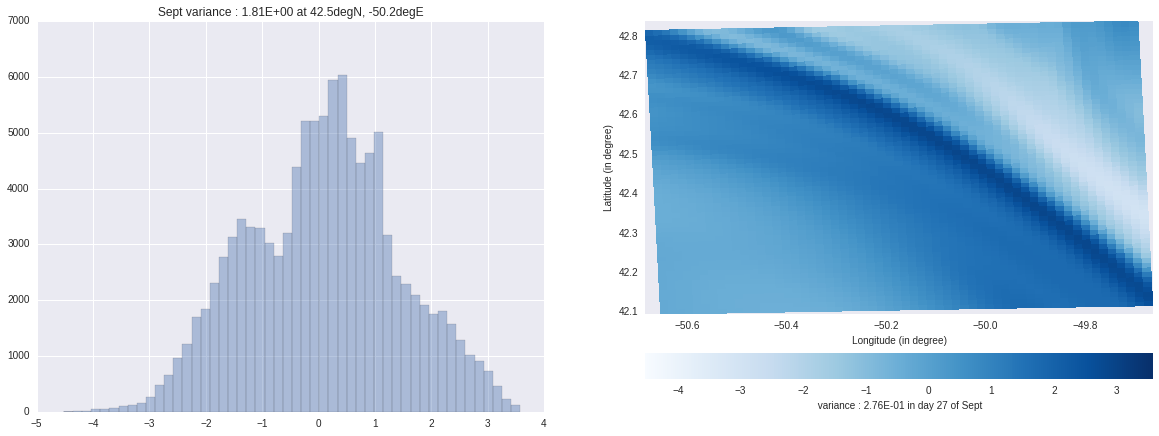

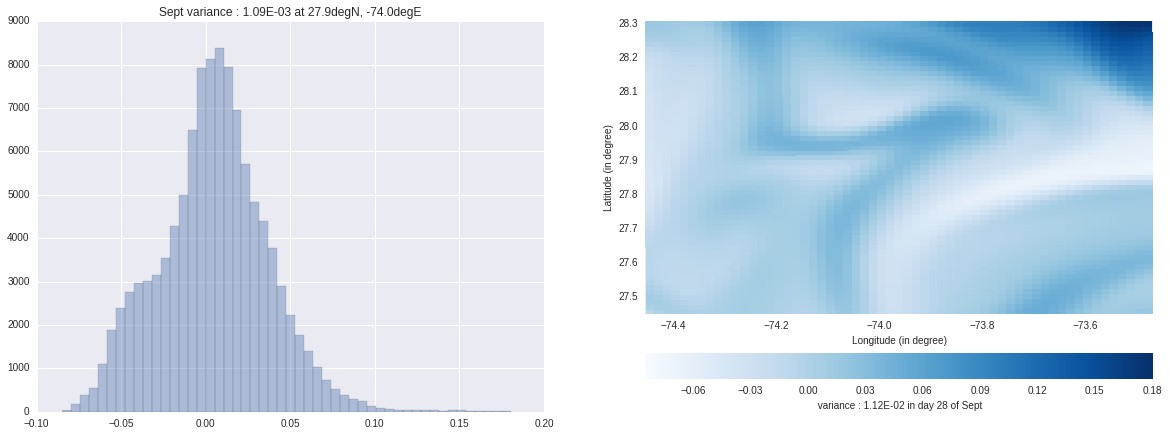

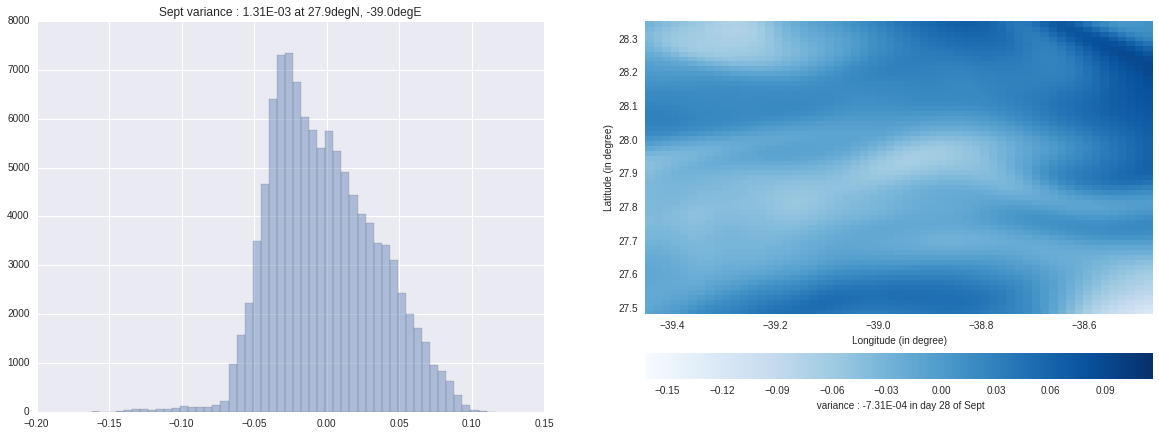

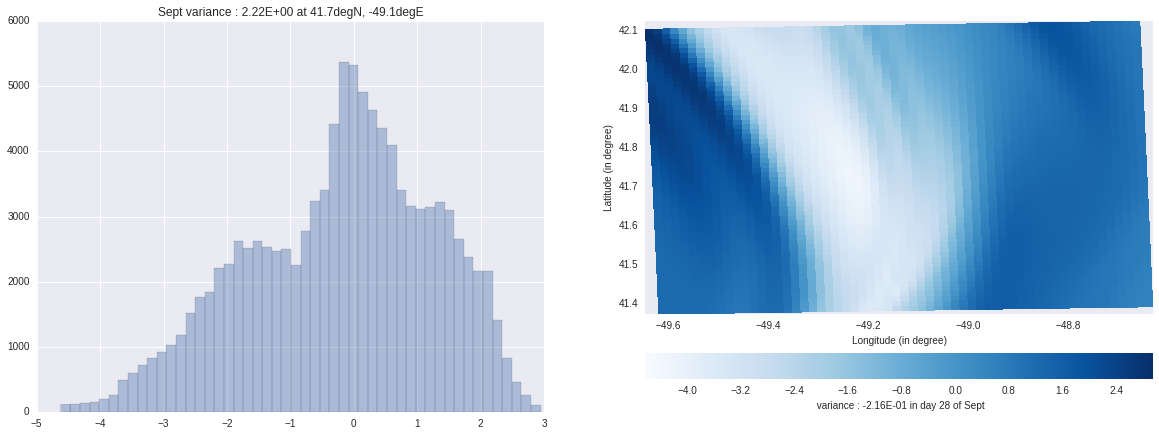

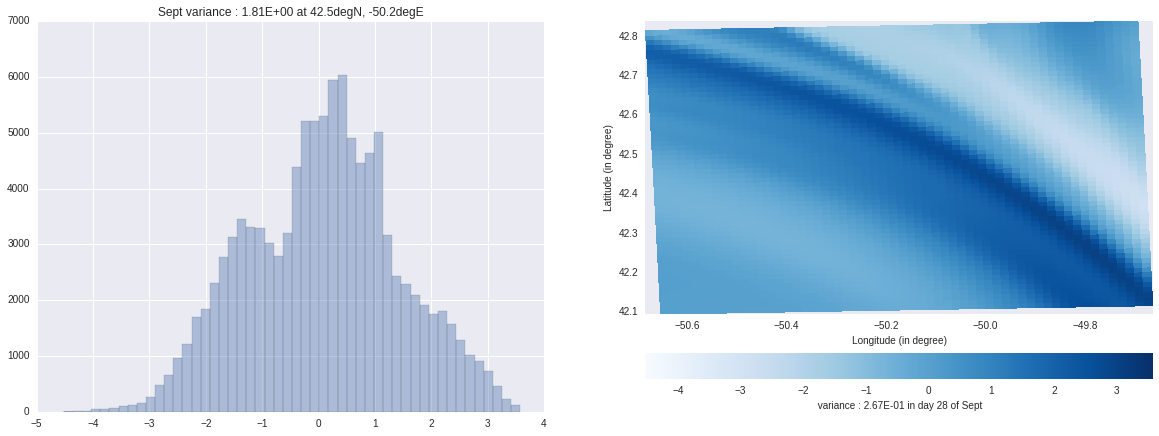

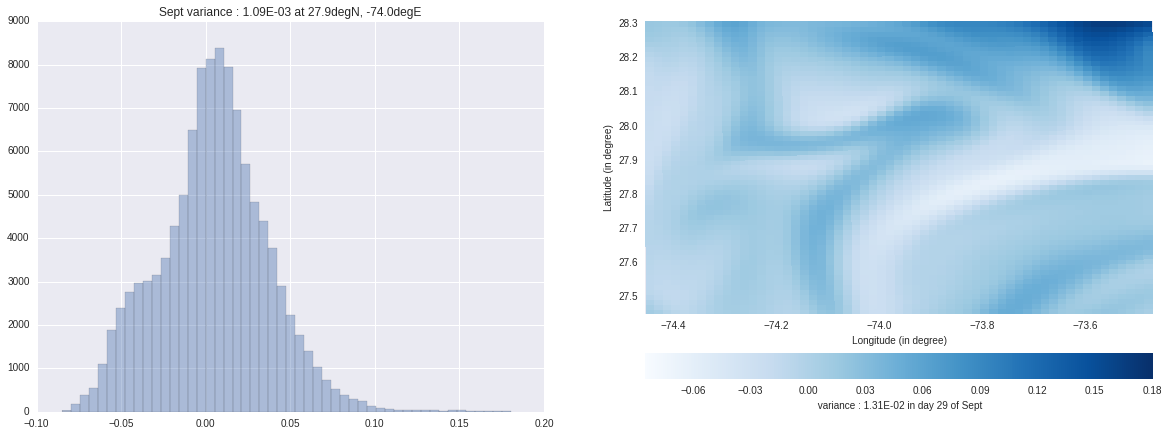

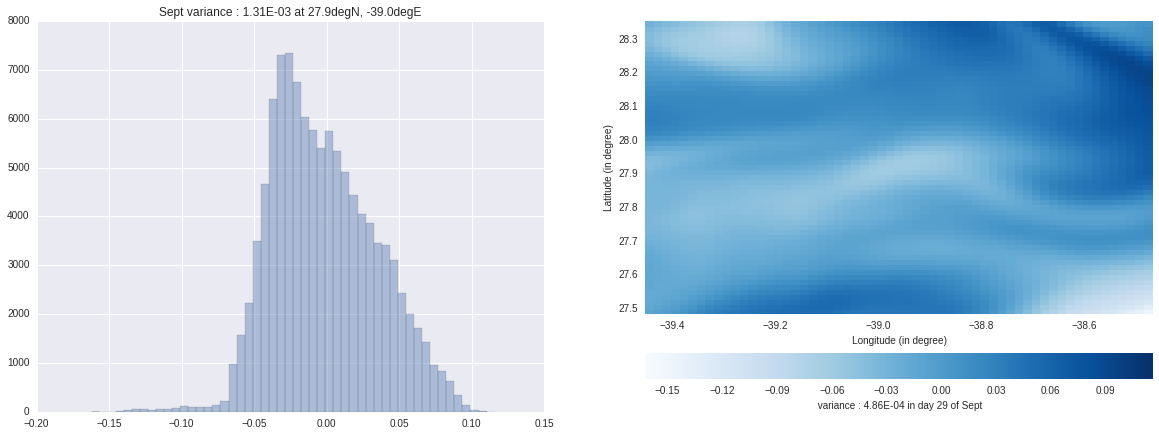

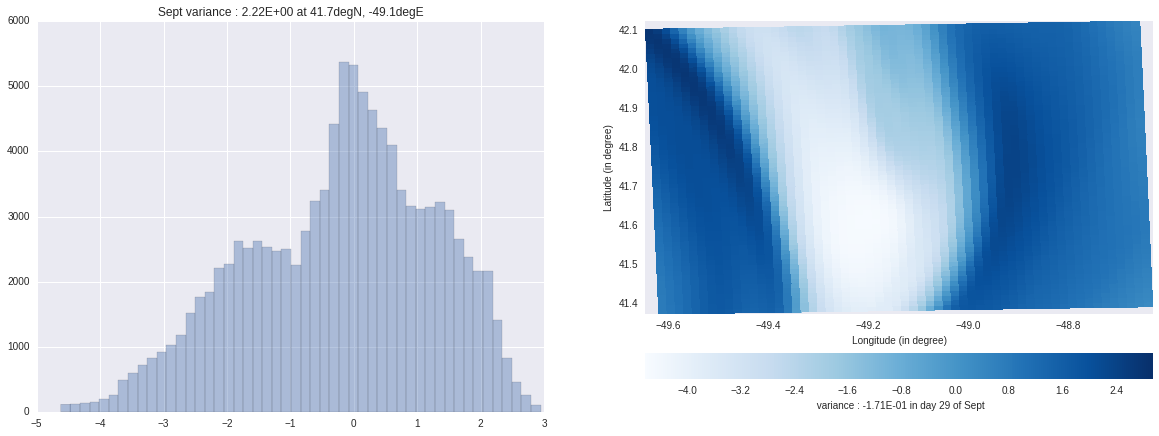

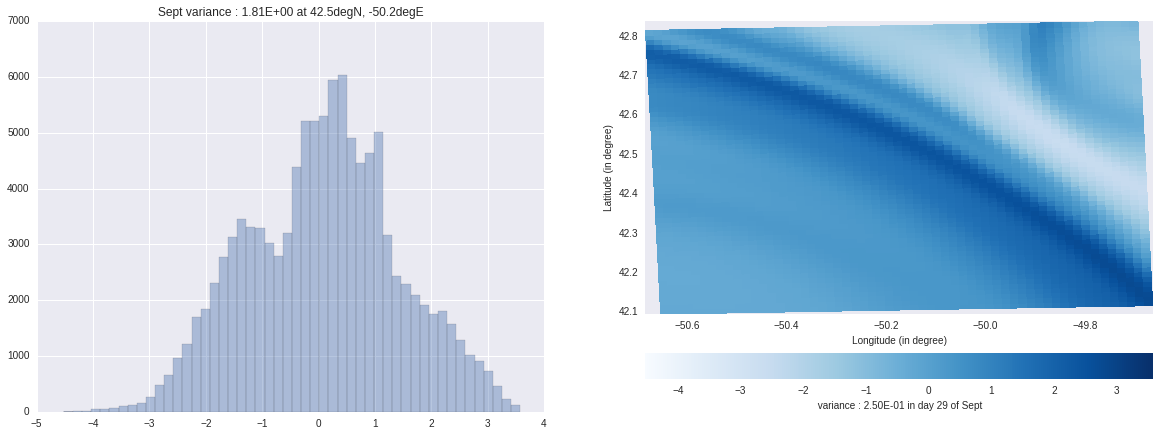

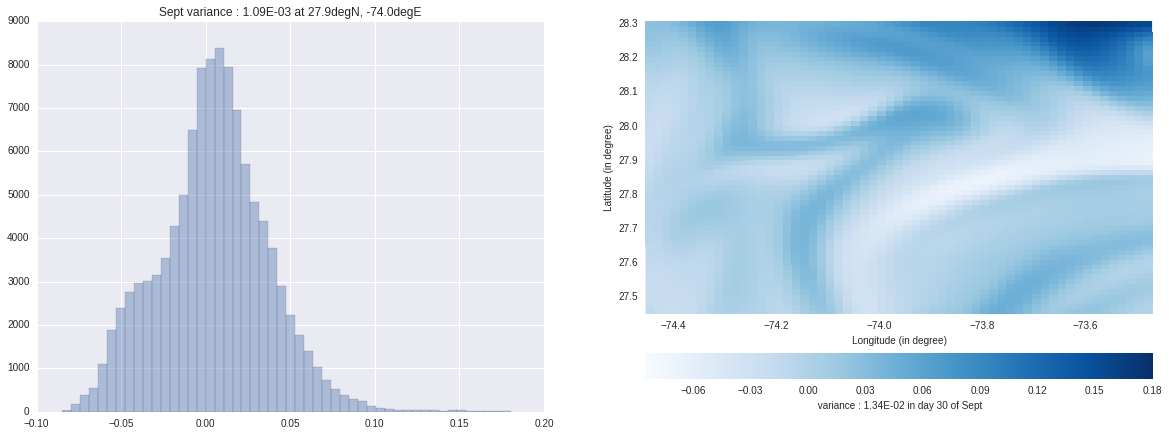

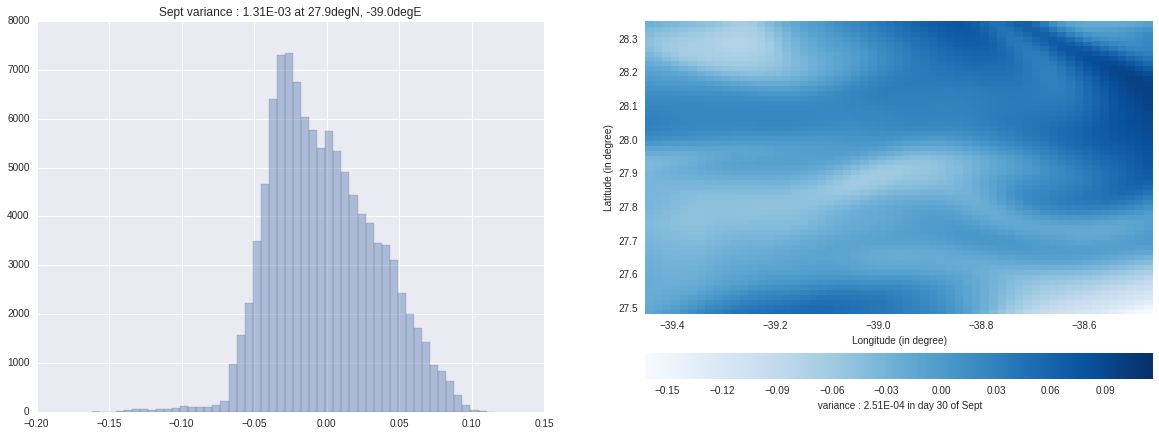

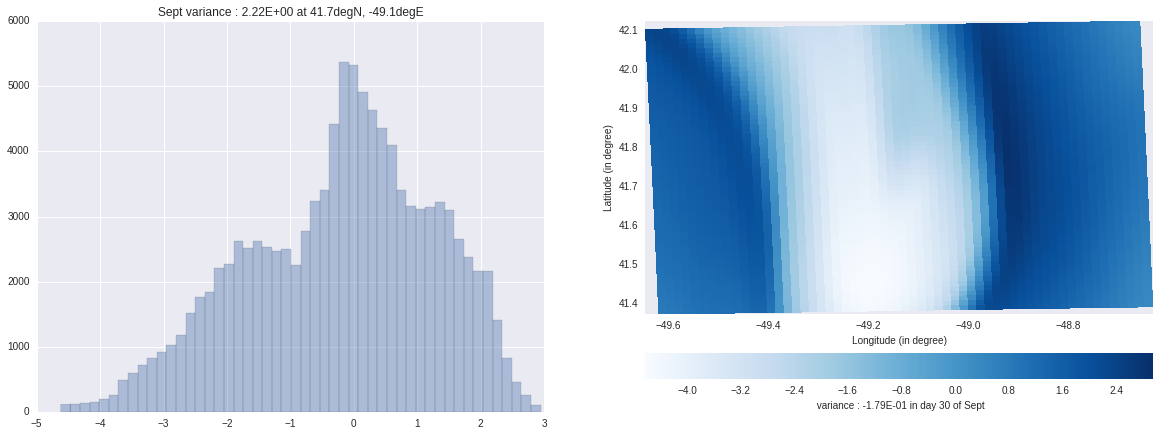

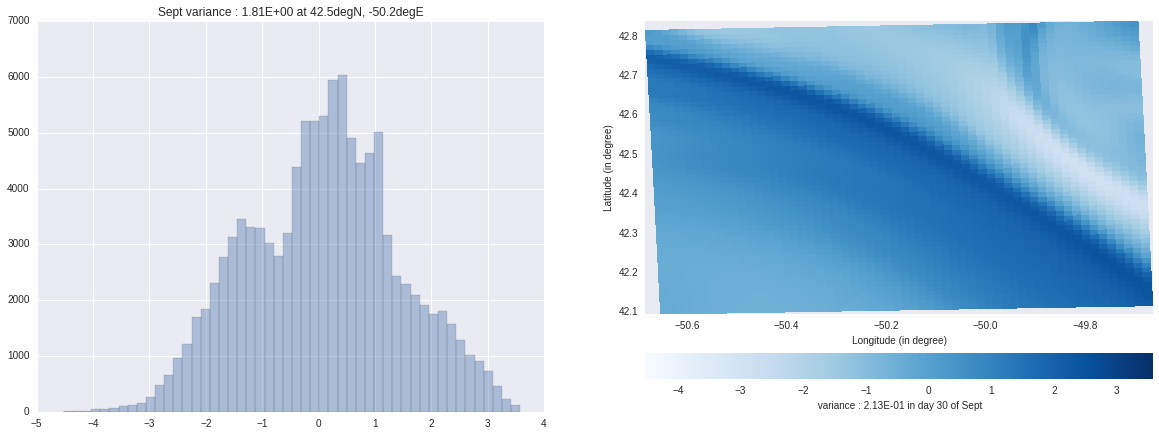

In [24]:
for t in np.arange(30):
    one_histo_and_snapshot('low1',wherelow09[0][0],wherelow09[1][0],9,t)
    one_histo_and_snapshot('low2',wherelow09[0][1],wherelow09[1][1],9,t)
    one_histo_and_snapshot('high1',wherehigh09[0][0],wherehigh09[1][0],9,t)
    one_histo_and_snapshot('high2',wherehigh09[0][1],wherehigh09[1][1],9,t)
    